In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import colors
import aplpy
import astropy.wcs as wcs
import imf


In [4]:
### load constants and functions
# Image information and assumptions
distance        = 8340. # distance to GC; Reid et al. 2014
#Temp            = 20.0
Wave            = (3.0e8/(226e9))
Wave0           = 1.3e-3
k0              = 0.899
nu              = 3.e08/Wave
nu0             = 3.e08/Wave0
beta            = 1.75
Kappag2d        = k0*((nu/nu0)**beta)
g2d             = 100.0
Kappa           = Kappag2d / g2d
mu              = 2.8 # express everything in H2

dustTemp = 20

# Constants
G = 6.67408e-11
msun = 1.989e33
mh = 1.6737236e-27
pc2cm = 3.08567758e18
as2persr = 4.25e10 
percm2perm = 1.0e6
JyperSr_to_JyperPix = (3.0462*(10**-4))*((0.00013888888888)**2) ### 
JyperSr_to_Jyperassqr = ((np.pi*180.)**(-2))*(3600**(-1))
hplanck = 6.63e-34
clight = 2.99792e8
kboltzmann = 1.381e-23
sin1yr = 3.15569e7
arcsec2pc = distance/((360./(2.*np.pi))*60.*60.)

In [5]:
def planck_wave( Wave, Temp ):

    # Planck function using wavelength

    planck_conv_wave = 1.e-26 * clight / Wave**2.0

    planck = ((2.0*hplanck*clight**2.0)/(Wave**5.0))*(1.0/(np.exp((hplanck*clight)/(Wave*kboltzmann*Temp))-1.0))
    planck = planck/planck_conv_wave

    return planck

def mass_calc_submm( Wave, Temp, Kappa, Integrated_Flux, Obj_Dist ):

    Obj_Dist = Obj_Dist * pc2cm
    #from planck_func import planck_wave
    B = planck_wave( Wave, Temp )
    Mass = (Obj_Dist**2. * Integrated_Flux) / ( Kappa * B )
    Mass = Mass / msun
    return Mass

In [6]:
### flux to mass for point source for simulated observation source recovery tests
### FOR JY/BEAM POINT SOURCES
### OR JY/PIX POINT SOURCES
point_flux = 0.15 ### jy/beam
#BMAJ    =   9.391762150659E-04                                                  
#BMIN    =   8.101911677255E-04
BMAJ    =   9.207714266247E-04                                                  
BMIN    =   6.383301814397E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2

#flux_integrated = point_flux*(deg2_per_pix/deg2_per_beam)
#print flux_integrated
#mass = mass_calc_submm(Wave,dustTemp,Kappa,flux_integrated,distance)

point_flux_jy_per_pix = point_flux * (deg2_per_pix/deg2_per_beam)
print point_flux_jy_per_pix
point_flux_jy_per_pix = 0.05
mass = mass_calc_submm(Wave,50,Kappa,point_flux_jy_per_pix,distance)

print mass

0.00156703674605
27.3684966007


In [7]:
### NOISE CONVERSION FROM CATALOG VALUE TO SIMOBS VALUE
BMAJ    =   9.207714266247E-04                                                  
BMIN    =   6.383301814397E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2
#print deg2_per_beam/deg2_per_pix
deg2_per_sr = 3282.8
noise_jy_per_sr = 4.0e6
noise_jy_per_beam = noise_jy_per_sr*(deg2_per_beam/deg2_per_sr)
noise_jy_per_pix = noise_jy_per_sr*(deg2_per_pix/deg2_per_sr)
print noise_jy_per_pix
print noise_jy_per_beam

2.35044760044e-05
0.00224989708094


[130.13610413 125.80366175 121.47120311 117.13876073 112.80631835
 108.47385971 104.14141733  99.80897495  95.47651631  91.14407393
  86.81163155  82.47917291  78.14673053  73.81428815  69.48182951
  65.14938713  60.81694475  56.48448611  52.15204373  47.81960135
  43.48714271  39.15470033  34.82225795  30.48979931  26.15735693
  21.82491455  17.49245591  13.16001353   8.82757115   4.49511251
   0.16267013]


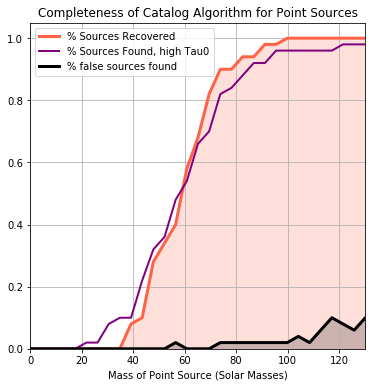

In [215]:
### Plot for mass vs percent found
### also average runs together
BMAJ    =   9.391762150659E-04
BMIN    =   8.101911677255E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2

found_avg = np.array([1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    0.98,  0.98,  0.94,  0.94,
                      0.9,   0.9,   0.82,  0.68,  0.58,  0.4,   0.34,  0.28,  0.1,   0.08,  0.,    0.,    0.,
                      0.,    0.,    0.,    0.,    0.,    0.  ])

hightau_avg = np.array([0.98,  0.98,  0.98,  0.96,  0.96,  0.96,  0.96,  0.96,  0.96,  0.92,  0.92,  0.88,
                        0.84,  0.82,  0.7,   0.66,  0.54,  0.48,  0.36,  0.32,  0.22,  0.1,   0.1,   0.08,
                        0.02,  0.02,  0.,    0.,    0.,    0.,    0.])

point_fluxes = np.array([0.08,        0.07733667,  0.07467333,  0.07201,     0.06934667,  0.06668333,
                         0.06402,     0.06135667,  0.05869333,  0.05603,     0.05336667,  0.05070333,
                         0.04804,     0.04537667,  0.04271333,  0.04005,     0.03738667,  0.03472333,
                         0.03206,     0.02939667,  0.02673333,  0.02407,     0.02140667,  0.01874333,
                         0.01608,     0.01341667,  0.01075333,  0.00809,     0.00542667,  0.00276333,
                         0.0001    ])
#fp_avg = np.array([1.4,  1.4,  1.4,  1.2,  0.8,  1.,   2.,   1.2,  0.8,  0.6,  0.2,  0.2,  0.2,  0.2,  0.,
#                     0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
#                     0. ])
fp_avg = np.array([ 1.,   0.6, 0.8,  1.,   0.6,  0.2,  0.4,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.,
                    0.,   0.,   0.2 , 0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                    0. ])
fp_avg = fp_avg/10.
#integrated_fluxes = point_fluxes*(deg2_per_pix/deg2_per_beam)
integrated_fluxes = point_fluxes
masses = mass_calc_submm(Wave,dustTemp,Kappa,integrated_fluxes,distance)
print masses

plt.close()
mrfig = plt.figure(3,figsize=(6,6))
mrfig.clf()
ax = mrfig.gca()
ax.plot(masses, found_avg,ls='-',color='tomato',linewidth='3.0', label='% Sources Recovered')
ax.plot(masses, hightau_avg,ls='-',color='purple',linewidth='2.0', label ='% Sources Found, high Tau0' )
ax.plot(masses, fp_avg,ls='-',color='k',linewidth='3.0',label='% false sources found')
plt.xlabel('Mass of Point Source (Solar Masses)')
#plt.ylabel('Percent Sources Found')
plt.title('Completeness of Catalog Algorithm for Point Sources')
ax.set_ylim(0,1.05)
ax.set_xlim(0,130.)
ax.grid()
fill = ax.fill_between(masses,found_avg, color='tomato',alpha=0.2,edgecolor='red',linewidth = '0.0')
fill = ax.fill_between(masses,fp_avg, color='k',alpha=0.2,edgecolor='k',linewidth = '0.0')
plt.legend()
mrfig.savefig(path+'simobs_percent.pdf',format='pdf')
plt.show()


In [207]:
### aplpy figures for simobs frames
def make_simobs_panel(path,inputfits1,inputfits2,maskfits,label):
    plt.close()
    fg_color='white'
    bg_color='black'
    contour_hdu = fits.open(path+maskfits)[0]
    data_hdu = fits.open(path+inputfits1)[0]
    print data_hdu.data.shape
    fig = plt.figure(figsize=(15, 5))#,facecolor=bg_color, edgecolor=fg_color)
    
    subplot1 = aplpy.FITSFigure(path+inputfits1,subplot=[0.1,0.1,0.35,0.8], slices = (2,3), 
                                figure = fig, convention='calabretta')
    vmin,vmax = -0.001,0.1
    subplot1.show_colorscale(vmin=vmin, vmax=vmax,cmap='inferno')
    #subplot.frame.set_color(fg_color)
    subplot1.set_nan_color(bg_color)
    subplot1.ticks.set_xspacing(0.02)
    subplot1.ticks.set_yspacing(0.02)
    subplot1.ticks.set_color('black')
    subplot1.tick_labels.set_xformat('d.dd')
    subplot1.tick_labels.set_yformat('d.dd')
    #subplot.ticks.set_color(fg_color)
    #subplot.recenter(xcenter, ycenter, width = 50. / 3600., height = 50. / 3600.)
    subplot1.add_label(0.35, 0.95, str(label), relative = True, weight = 'bold', size = 10, color = 'white')
    #subplot.show_markers(xcenter, ycenter, marker = '+', facecolor = 'red', edgecolor = 'red', s = 1000)
    subplot1.show_contour(path+maskfits,slices=(1,2),
                         colors = 'white', levels = [0.0,], linewidths = 0.7,
                         convention = 'calabretta', zorder = 10, linestyle = 'solid')
    subplot1.axis_labels.set_xtext('Galactic Longitude (degrees)')
    subplot1.axis_labels.set_ytext('Galactic Latitude (degrees)')
    subplot1.ticks.show()
    subplot1.add_scalebar(length=24./3600.)
    subplot1.scalebar.set_label('1 pc')
    subplot1.scalebar.set_color('white')
    subplot1.add_colorbar()
    
    subplot2 = aplpy.FITSFigure(path+inputfits2,subplot=[0.5,0.1,0.35,0.8], slices = (2,3), 
                                figure = fig, convention='calabretta')
    vmin,vmax = -0.001,0.1
    subplot2.show_colorscale(vmin=vmin, vmax=vmax,cmap='inferno')
    #subplot.frame.set_color(fg_color)
    subplot2.set_nan_color(bg_color)
    subplot2.ticks.set_xspacing(0.02)
    subplot2.ticks.set_yspacing(0.02)
    subplot2.ticks.set_color('black')
    subplot2.tick_labels.set_xformat('d.dd')
    subplot2.tick_labels.set_yformat('d.dd')
    subplot2.add_label(0.35, 0.95, str(label), relative = True, weight = 'bold', size = 10, color = 'white')
    plt.scatter(transformed_pix[1],transformed_pix[0],color='limegreen',marker='x')
    subplot2.show_contour(path+maskfits,slices=(1,2),
                         colors = 'white', levels = [0.0,], linewidths = 0.7,
                         convention = 'calabretta', zorder = 10, linestyle = 'solid')
    subplot2.axis_labels.set_xtext('Galactic Longitude (degrees)')
    subplot2.axis_labels.set_ytext('Galactic Latitude (degrees)')
    subplot2.ticks.show()
    subplot2.add_scalebar(length=24./3600.)
    subplot2.scalebar.set_label('1 pc')
    subplot2.scalebar.set_color('white')
    subplot2.add_colorbar()
    
    plt.plot()
    #plt.tight_layout()
    #subplot.tick_labels.set_font(color=fg_color)
    #subplot.axis_labels.set_font(color=fg_color)
    #subplot.axis_labels.set_color(fg_color)
    #fig.tight_layout()
    fig.savefig(path+'simobs_example.pdf',format='pdf')
    #plt.show()
    

(1, 1, 200, 200)
INFO: Setting slices=[0, 0] [aplpy.core]


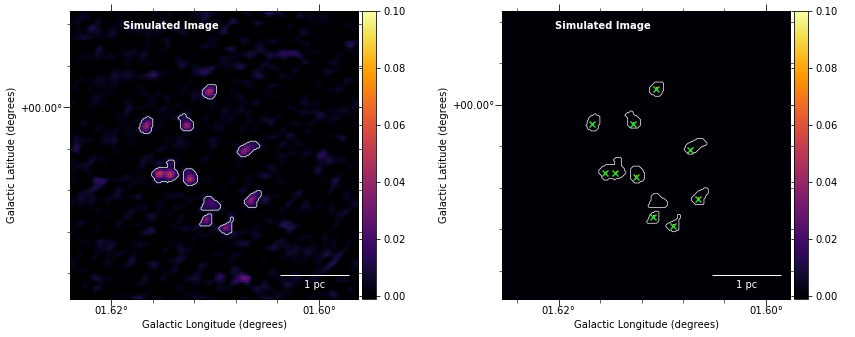

In [208]:
path = '/Users/hph/cmzoom_catalog/simobserve_1-11-19/'
make_simobs_panel(path,'final_noregrid_image_4-6-19_noisy0.fits','initial_temp_image_4-6-19_noisy0.fits',
                  'temp_mask_4-6-19_noisy0.fits','Simulated Image')
plt.show()

In [166]:
initial_hdu = fits.open(path+'initial_temp_image_4-6-19_noisy0.fits')[0]
final_hdu = fits.open(path+'final_noregrid_image_4-6-19_noisy0.fits')[0]
initial_data = initial_hdu.data
initial_hdu.header.remove('CRVAL3')
initial_hdu.header.remove('CRVAL4')
initial_hdu.header.remove('CTYPE3')
initial_hdu.header.remove('CTYPE4')
initial_hdu.header.remove('CDELT3')
initial_hdu.header.remove('CDELT4')
initial_hdu.header.remove('CUNIT3')
initial_hdu.header.remove('CUNIT4')
initial_hdu.header.remove('CRPIX3')
initial_hdu.header.remove('CRPIX4')
initial_hdu.header.remove('PC03_01')
initial_hdu.header.remove('PC03_02')
initial_hdu.header.remove('PC03_03')
initial_hdu.header.remove('PC03_04')
initial_hdu.header.remove('PC04_01')
initial_hdu.header.remove('PC04_02')
initial_hdu.header.remove('PC04_03')
initial_hdu.header.remove('PC04_04')
initial_hdu.header.remove('PC01_03')
initial_hdu.header.remove('PC01_04')
initial_hdu.header.remove('PC02_03')
initial_hdu.header.remove('PC02_04')

final_hdu.header.remove('CRVAL3')
final_hdu.header.remove('CRVAL4')
final_hdu.header.remove('CTYPE3')
final_hdu.header.remove('CTYPE4')
final_hdu.header.remove('CDELT3')
final_hdu.header.remove('CDELT4')
final_hdu.header.remove('CUNIT3')
final_hdu.header.remove('CUNIT4')
final_hdu.header.remove('CRPIX3')
final_hdu.header.remove('CRPIX4')
final_hdu.header.remove('PC3_1')
final_hdu.header.remove('PC3_2')
final_hdu.header.remove('PC3_3')
final_hdu.header.remove('PC3_4')
final_hdu.header.remove('PC4_1')
final_hdu.header.remove('PC4_2')
final_hdu.header.remove('PC4_3')
final_hdu.header.remove('PC4_4')
final_hdu.header.remove('PC1_3')
final_hdu.header.remove('PC1_4')
final_hdu.header.remove('PC2_3')
final_hdu.header.remove('PC2_4')
final_hdu.header.remove('NAXIS3')
final_hdu.header.remove('NAXIS4')
final_hdu.header['NAXIS']=2


final_wcs = wcs.WCS(final_hdu)

print final_hdu.header
print np.where(initial_data!=0)
initial_wcs = wcs.WCS(initial_hdu.header)
initial_wcs
init_cond = np.where(initial_data!=0)
print initial_wcs
wcs_init = initial_wcs.wcs_pix2world(init_cond[0],init_cond[1],1)
#print wcs_init
transformed_pix = initial_wcs.wcs_world2pix(wcs_init[0],wcs_init[1],1)

SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    2                                                  NAXIS1  =                  200                                                  NAXIS2  =                  200                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   9.605898459752E-04                                                  BMIN    =   6.667590141296E-04                                                  BPA     =  -6.387192916870E+01                                                  BTYPE   = 'Intensity'                                                           OBJECT  = 'sim_compact.sma.cmzoom.compac

(200, 200)


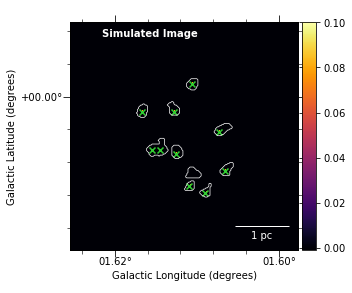

In [167]:
path = '/Users/hph/cmzoom_catalog/simobserve_1-11-19/'
make_simobs_panel(path,'initial_temp_image_4-6-19_noisy0.fits','temp_mask_4-6-19_noisy0.fits','Simulated Image')
plt.show()

In [6]:
BMAJ    =   9.207714266247E-04                                                  
BMIN    =   6.383301814397E-04 
deg2_per_beam = np.pi*BMAJ*BMIN
deg2_per_pix = (1.388888888889E-04)**2
print (deg2_per_beam/deg2_per_pix)/2

47.8610346498


In [95]:
#### Make IMF figure
lim_vals = np.linspace(10,200,40)
num_massive_avg = np.zeros(len(lim_vals))
for j in range(len(lim_vals)):
    has_massive = np.zeros(1000)
    for i in range(1000):
        if len(np.where(imf.make_cluster(lim_vals[j])>10)[0])!=0: has_massive[i]=1
    num_massive_avg[j]=has_massive.sum()/1000

Total cluster mass is 10.039 (limit was 10)
Total cluster mass is 8.73671 (limit was 10)
Total cluster mass is 12.7247 (limit was 10)
Total cluster mass is 11.216 (limit was 10)
Total cluster mass is 10.3126 (limit was 10)
Total cluster mass is 4.25209 (limit was 10)
Total cluster mass is 12.6071 (limit was 10)
Total cluster mass is 9.97946 (limit was 10)
Total cluster mass is 10.0259 (limit was 10)
Total cluster mass is 9.91607 (limit was 10)
Total cluster mass is 9.42848 (limit was 10)
Total cluster mass is 10.0563 (limit was 10)
Total cluster mass is 11.086 (limit was 10)
Total cluster mass is 10.4301 (limit was 10)
Total cluster mass is 9.6497 (limit was 10)
Total cluster mass is 9.97223 (limit was 10)
Total cluster mass is 9.94975 (limit was 10)
Total cluster mass is 10.3756 (limit was 10)
Total cluster mass is 10.0837 (limit was 10)
Total cluster mass is 6.93728 (limit was 10)
Total cluster mass is 10.5672 (limit was 10)
Total cluster mass is 11.2523 (limit was 10)
Total cluster 

Total cluster mass is 10.5732 (limit was 10)
Total cluster mass is 8.14293 (limit was 10)
Total cluster mass is 8.96046 (limit was 10)
Total cluster mass is 31.7787 (limit was 10)
Total cluster mass is 8.11259 (limit was 10)
Total cluster mass is 12.0364 (limit was 10)
Total cluster mass is 10.0309 (limit was 10)
Total cluster mass is 4.73099 (limit was 10)
Total cluster mass is 10.2776 (limit was 10)
Total cluster mass is 10.0748 (limit was 10)
Total cluster mass is 10.351 (limit was 10)
Total cluster mass is 12.4793 (limit was 10)
Total cluster mass is 10.002 (limit was 10)
Total cluster mass is 9.92227 (limit was 10)
Total cluster mass is 10.295 (limit was 10)
Total cluster mass is 8.5103 (limit was 10)
Total cluster mass is 10.468 (limit was 10)
Total cluster mass is 10.6003 (limit was 10)
Total cluster mass is 9.81831 (limit was 10)
Total cluster mass is 10.0555 (limit was 10)
Total cluster mass is 10.1113 (limit was 10)
Total cluster mass is 5.49135 (limit was 10)
Total cluster m

Total cluster mass is 9.98335 (limit was 10)
Total cluster mass is 10.7566 (limit was 10)
Total cluster mass is 10.1418 (limit was 10)
Total cluster mass is 9.97895 (limit was 10)
Total cluster mass is 12.4152 (limit was 10)
Total cluster mass is 10.0268 (limit was 10)
Total cluster mass is 7.3825 (limit was 10)
Total cluster mass is 10.2134 (limit was 10)
Total cluster mass is 9.98046 (limit was 10)
Total cluster mass is 10.0472 (limit was 10)
Total cluster mass is 9.96045 (limit was 10)
Total cluster mass is 9.1691 (limit was 10)
Total cluster mass is 9.34792 (limit was 10)
Total cluster mass is 10.5684 (limit was 10)
Total cluster mass is 10.0843 (limit was 10)
Total cluster mass is 9.65439 (limit was 10)
Total cluster mass is 11.4404 (limit was 10)
Total cluster mass is 9.84899 (limit was 10)
Total cluster mass is 10.0322 (limit was 10)
Total cluster mass is 5.73242 (limit was 10)
Total cluster mass is 9.88868 (limit was 10)
Total cluster mass is 10.0146 (limit was 10)
Total cluste

Total cluster mass is 9.86368 (limit was 10)
Total cluster mass is 10.328 (limit was 10)
Total cluster mass is 10.9903 (limit was 10)
Total cluster mass is 9.99473 (limit was 10)
Total cluster mass is 9.99316 (limit was 10)
Total cluster mass is 10.0518 (limit was 10)
Total cluster mass is 10.5111 (limit was 10)
Total cluster mass is 10.2484 (limit was 10)
Total cluster mass is 10.0167 (limit was 10)
Total cluster mass is 12.0639 (limit was 10)
Total cluster mass is 9.95708 (limit was 10)
Total cluster mass is 9.95495 (limit was 10)
Total cluster mass is 10.0256 (limit was 10)
Total cluster mass is 10.0013 (limit was 10)
Total cluster mass is 18.4138 (limit was 10)
Total cluster mass is 9.50115 (limit was 10)
Total cluster mass is 9.98656 (limit was 10)
Total cluster mass is 9.93 (limit was 10)
Total cluster mass is 10.266 (limit was 10)
Total cluster mass is 9.67823 (limit was 10)
Total cluster mass is 9.67996 (limit was 10)
Total cluster mass is 9.92232 (limit was 10)
Total cluster m

Total cluster mass is 24.3571 (limit was 14.8718)
Total cluster mass is 14.2017 (limit was 14.8718)
Total cluster mass is 14.6292 (limit was 14.8718)
Total cluster mass is 15.7164 (limit was 14.8718)
Total cluster mass is 18.9412 (limit was 14.8718)
Total cluster mass is 20.0892 (limit was 14.8718)
Total cluster mass is 14.8736 (limit was 14.8718)
Total cluster mass is 14.8662 (limit was 14.8718)
Total cluster mass is 14.6305 (limit was 14.8718)
Total cluster mass is 14.9356 (limit was 14.8718)
Total cluster mass is 14.8844 (limit was 14.8718)
Total cluster mass is 14.3191 (limit was 14.8718)
Total cluster mass is 14.8691 (limit was 14.8718)
Total cluster mass is 14.8869 (limit was 14.8718)
Total cluster mass is 12.3578 (limit was 14.8718)
Total cluster mass is 14.9409 (limit was 14.8718)
Total cluster mass is 13.6766 (limit was 14.8718)
Total cluster mass is 14.9875 (limit was 14.8718)
Total cluster mass is 0.26566 (limit was 14.8718)
Total cluster mass is 14.7589 (limit was 14.8718)


Total cluster mass is 14.8689 (limit was 14.8718)
Total cluster mass is 14.9837 (limit was 14.8718)
Total cluster mass is 14.8546 (limit was 14.8718)
Total cluster mass is 14.634 (limit was 14.8718)
Total cluster mass is 14.8571 (limit was 14.8718)
Total cluster mass is 14.8337 (limit was 14.8718)
Total cluster mass is 15.136 (limit was 14.8718)
Total cluster mass is 15.0469 (limit was 14.8718)
Total cluster mass is 13.569 (limit was 14.8718)
Total cluster mass is 16.2187 (limit was 14.8718)
Total cluster mass is 14.4331 (limit was 14.8718)
Total cluster mass is 16.218 (limit was 14.8718)
Total cluster mass is 14.9719 (limit was 14.8718)
Total cluster mass is 12.6578 (limit was 14.8718)
Total cluster mass is 16.2677 (limit was 14.8718)
Total cluster mass is 17.3343 (limit was 14.8718)
Total cluster mass is 13.7141 (limit was 14.8718)
Total cluster mass is 14.8421 (limit was 14.8718)
Total cluster mass is 14.9106 (limit was 14.8718)
Total cluster mass is 13.3889 (limit was 14.8718)
Tota

Total cluster mass is 14.9791 (limit was 14.8718)
Total cluster mass is 16.5773 (limit was 14.8718)
Total cluster mass is 14.8995 (limit was 14.8718)
Total cluster mass is 14.9115 (limit was 14.8718)
Total cluster mass is 14.7859 (limit was 14.8718)
Total cluster mass is 14.1963 (limit was 14.8718)
Total cluster mass is 14.8701 (limit was 14.8718)
Total cluster mass is 7.94211 (limit was 14.8718)
Total cluster mass is 14.7769 (limit was 14.8718)
Total cluster mass is 12.6464 (limit was 14.8718)
Total cluster mass is 15.0264 (limit was 14.8718)
Total cluster mass is 14.6262 (limit was 14.8718)
Total cluster mass is 14.9764 (limit was 14.8718)
Total cluster mass is 10.7868 (limit was 14.8718)
Total cluster mass is 15.3436 (limit was 14.8718)
Total cluster mass is 13.2307 (limit was 14.8718)
Total cluster mass is 14.7442 (limit was 14.8718)
Total cluster mass is 13.8038 (limit was 14.8718)
Total cluster mass is 14.962 (limit was 14.8718)
Total cluster mass is 14.8776 (limit was 14.8718)
T

Total cluster mass is 14.8916 (limit was 14.8718)
Total cluster mass is 14.9622 (limit was 14.8718)
Total cluster mass is 19.77 (limit was 14.8718)
Total cluster mass is 14.9602 (limit was 14.8718)
Total cluster mass is 14.8892 (limit was 14.8718)
Total cluster mass is 15.4817 (limit was 14.8718)
Total cluster mass is 14.8839 (limit was 14.8718)
Total cluster mass is 18.1986 (limit was 14.8718)
Total cluster mass is 14.0898 (limit was 14.8718)
Total cluster mass is 14.6215 (limit was 14.8718)
Total cluster mass is 15.0013 (limit was 14.8718)
Total cluster mass is 15.1402 (limit was 14.8718)
Total cluster mass is 14.7033 (limit was 14.8718)
Total cluster mass is 14.6445 (limit was 14.8718)
Total cluster mass is 14.3246 (limit was 14.8718)
Total cluster mass is 14.0222 (limit was 14.8718)
Total cluster mass is 13.5742 (limit was 14.8718)
Total cluster mass is 15.8752 (limit was 14.8718)
Total cluster mass is 18.9907 (limit was 14.8718)
Total cluster mass is 15.1424 (limit was 14.8718)
To

Total cluster mass is 14.5341 (limit was 14.8718)
Total cluster mass is 15.2692 (limit was 14.8718)
Total cluster mass is 14.9281 (limit was 14.8718)
Total cluster mass is 14.798 (limit was 14.8718)
Total cluster mass is 12.5495 (limit was 14.8718)
Total cluster mass is 15.5067 (limit was 14.8718)
Total cluster mass is 18.392 (limit was 14.8718)
Total cluster mass is 15.2255 (limit was 14.8718)
Total cluster mass is 14.9461 (limit was 14.8718)
Total cluster mass is 15.0411 (limit was 14.8718)
Total cluster mass is 14.8622 (limit was 14.8718)
Total cluster mass is 14.9566 (limit was 14.8718)
Total cluster mass is 14.9544 (limit was 14.8718)
Total cluster mass is 14.346 (limit was 14.8718)
Total cluster mass is 14.1124 (limit was 14.8718)
Total cluster mass is 14.8609 (limit was 14.8718)
Total cluster mass is 15.8865 (limit was 14.8718)
Total cluster mass is 14.8584 (limit was 14.8718)
Total cluster mass is 20.1174 (limit was 14.8718)
Total cluster mass is 15.6195 (limit was 14.8718)
Tot

Total cluster mass is 19.7433 (limit was 19.7436)
Total cluster mass is 19.5833 (limit was 19.7436)
Total cluster mass is 22.2875 (limit was 19.7436)
Total cluster mass is 20.3636 (limit was 19.7436)
Total cluster mass is 19.8198 (limit was 19.7436)
Total cluster mass is 19.7125 (limit was 19.7436)
Total cluster mass is 19.7824 (limit was 19.7436)
Total cluster mass is 21.9944 (limit was 19.7436)
Total cluster mass is 20.4245 (limit was 19.7436)
Total cluster mass is 19.8021 (limit was 19.7436)
Total cluster mass is 19.9724 (limit was 19.7436)
Total cluster mass is 19.7134 (limit was 19.7436)
Total cluster mass is 19.4509 (limit was 19.7436)
Total cluster mass is 18.2244 (limit was 19.7436)
Total cluster mass is 19.8358 (limit was 19.7436)
Total cluster mass is 19.7883 (limit was 19.7436)
Total cluster mass is 19.7705 (limit was 19.7436)
Total cluster mass is 14.3952 (limit was 19.7436)
Total cluster mass is 19.7189 (limit was 19.7436)
Total cluster mass is 4.41228 (limit was 19.7436)


Total cluster mass is 19.9424 (limit was 19.7436)
Total cluster mass is 20.3933 (limit was 19.7436)
Total cluster mass is 19.6396 (limit was 19.7436)
Total cluster mass is 19.5241 (limit was 19.7436)
Total cluster mass is 19.5729 (limit was 19.7436)
Total cluster mass is 19.4471 (limit was 19.7436)
Total cluster mass is 19.778 (limit was 19.7436)
Total cluster mass is 19.793 (limit was 19.7436)
Total cluster mass is 15.4293 (limit was 19.7436)
Total cluster mass is 19.8035 (limit was 19.7436)
Total cluster mass is 18.2346 (limit was 19.7436)
Total cluster mass is 20.2664 (limit was 19.7436)
Total cluster mass is 5.81166 (limit was 19.7436)
Total cluster mass is 19.9285 (limit was 19.7436)
Total cluster mass is 19.7555 (limit was 19.7436)
Total cluster mass is 13.3295 (limit was 19.7436)
Total cluster mass is 19.131 (limit was 19.7436)
Total cluster mass is 19.3866 (limit was 19.7436)
Total cluster mass is 18.2143 (limit was 19.7436)
Total cluster mass is 20.1177 (limit was 19.7436)
Tot

Total cluster mass is 20.5816 (limit was 19.7436)
Total cluster mass is 17.1831 (limit was 19.7436)
Total cluster mass is 19.7386 (limit was 19.7436)
Total cluster mass is 19.6324 (limit was 19.7436)
Total cluster mass is 19.0517 (limit was 19.7436)
Total cluster mass is 20.7419 (limit was 19.7436)
Total cluster mass is 11.624 (limit was 19.7436)
Total cluster mass is 19.8824 (limit was 19.7436)
Total cluster mass is 19.8448 (limit was 19.7436)
Total cluster mass is 31.1896 (limit was 19.7436)
Total cluster mass is 19.7048 (limit was 19.7436)
Total cluster mass is 19.2815 (limit was 19.7436)
Total cluster mass is 19.6882 (limit was 19.7436)
Total cluster mass is 19.9071 (limit was 19.7436)
Total cluster mass is 19.094 (limit was 19.7436)
Total cluster mass is 19.7142 (limit was 19.7436)
Total cluster mass is 19.9505 (limit was 19.7436)
Total cluster mass is 19.2866 (limit was 19.7436)
Total cluster mass is 20.0072 (limit was 19.7436)
Total cluster mass is 24.8635 (limit was 19.7436)
To

Total cluster mass is 19.931 (limit was 19.7436)
Total cluster mass is 19.4081 (limit was 19.7436)
Total cluster mass is 14.1197 (limit was 19.7436)
Total cluster mass is 19.7248 (limit was 19.7436)
Total cluster mass is 19.8773 (limit was 19.7436)
Total cluster mass is 19.7405 (limit was 19.7436)
Total cluster mass is 21.668 (limit was 19.7436)
Total cluster mass is 15.8817 (limit was 19.7436)
Total cluster mass is 19.895 (limit was 19.7436)
Total cluster mass is 19.5783 (limit was 19.7436)
Total cluster mass is 19.7541 (limit was 19.7436)
Total cluster mass is 20.2495 (limit was 19.7436)
Total cluster mass is 19.289 (limit was 19.7436)
Total cluster mass is 18.9761 (limit was 19.7436)
Total cluster mass is 19.4021 (limit was 19.7436)
Total cluster mass is 19.7158 (limit was 19.7436)
Total cluster mass is 19.5628 (limit was 19.7436)
Total cluster mass is 19.7443 (limit was 19.7436)
Total cluster mass is 19.465 (limit was 19.7436)
Total cluster mass is 19.803 (limit was 19.7436)
Total 

Total cluster mass is 24.4358 (limit was 24.6154)
Total cluster mass is 24.8742 (limit was 24.6154)
Total cluster mass is 25.1818 (limit was 24.6154)
Total cluster mass is 24.7316 (limit was 24.6154)
Total cluster mass is 24.6418 (limit was 24.6154)
Total cluster mass is 24.6571 (limit was 24.6154)
Total cluster mass is 24.865 (limit was 24.6154)
Total cluster mass is 24.7333 (limit was 24.6154)
Total cluster mass is 24.7761 (limit was 24.6154)
Total cluster mass is 24.6285 (limit was 24.6154)
Total cluster mass is 23.0605 (limit was 24.6154)
Total cluster mass is 20.0764 (limit was 24.6154)
Total cluster mass is 25.177 (limit was 24.6154)
Total cluster mass is 24.0596 (limit was 24.6154)
Total cluster mass is 24.782 (limit was 24.6154)
Total cluster mass is 24.9143 (limit was 24.6154)
Total cluster mass is 24.3576 (limit was 24.6154)
Total cluster mass is 30.956 (limit was 24.6154)
Total cluster mass is 24.5034 (limit was 24.6154)
Total cluster mass is 24.2634 (limit was 24.6154)
Tota

Total cluster mass is 24.7262 (limit was 24.6154)
Total cluster mass is 24.8418 (limit was 24.6154)
Total cluster mass is 24.8159 (limit was 24.6154)
Total cluster mass is 23.3783 (limit was 24.6154)
Total cluster mass is 24.3223 (limit was 24.6154)
Total cluster mass is 24.3979 (limit was 24.6154)
Total cluster mass is 24.6883 (limit was 24.6154)
Total cluster mass is 24.7356 (limit was 24.6154)
Total cluster mass is 24.2317 (limit was 24.6154)
Total cluster mass is 25.5439 (limit was 24.6154)
Total cluster mass is 33.2349 (limit was 24.6154)
Total cluster mass is 24.8763 (limit was 24.6154)
Total cluster mass is 25.0149 (limit was 24.6154)
Total cluster mass is 23.0019 (limit was 24.6154)
Total cluster mass is 24.5371 (limit was 24.6154)
Total cluster mass is 24.5028 (limit was 24.6154)
Total cluster mass is 24.696 (limit was 24.6154)
Total cluster mass is 24.7299 (limit was 24.6154)
Total cluster mass is 24.6331 (limit was 24.6154)
Total cluster mass is 21.3372 (limit was 24.6154)
T

Total cluster mass is 24.663 (limit was 24.6154)
Total cluster mass is 24.684 (limit was 24.6154)
Total cluster mass is 24.5584 (limit was 24.6154)
Total cluster mass is 24.6066 (limit was 24.6154)
Total cluster mass is 24.6314 (limit was 24.6154)
Total cluster mass is 24.6328 (limit was 24.6154)
Total cluster mass is 24.6402 (limit was 24.6154)
Total cluster mass is 24.9534 (limit was 24.6154)
Total cluster mass is 24.6186 (limit was 24.6154)
Total cluster mass is 24.6593 (limit was 24.6154)
Total cluster mass is 24.6035 (limit was 24.6154)
Total cluster mass is 24.8081 (limit was 24.6154)
Total cluster mass is 24.6146 (limit was 24.6154)
Total cluster mass is 23.8022 (limit was 24.6154)
Total cluster mass is 24.4603 (limit was 24.6154)
Total cluster mass is 24.4903 (limit was 24.6154)
Total cluster mass is 24.4923 (limit was 24.6154)
Total cluster mass is 24.6907 (limit was 24.6154)
Total cluster mass is 24.6264 (limit was 24.6154)
Total cluster mass is 24.4954 (limit was 24.6154)
To

Total cluster mass is 25.1798 (limit was 24.6154)
Total cluster mass is 35.4946 (limit was 24.6154)
Total cluster mass is 25.6615 (limit was 24.6154)
Total cluster mass is 24.3428 (limit was 24.6154)
Total cluster mass is 25.6489 (limit was 24.6154)
Total cluster mass is 25.9069 (limit was 24.6154)
Total cluster mass is 25.0637 (limit was 24.6154)
Total cluster mass is 4.98431 (limit was 24.6154)
Total cluster mass is 35.4052 (limit was 24.6154)
Total cluster mass is 24.4656 (limit was 24.6154)
Total cluster mass is 24.6272 (limit was 24.6154)
Total cluster mass is 31.6548 (limit was 24.6154)
Total cluster mass is 9.89897 (limit was 24.6154)
Total cluster mass is 24.6738 (limit was 24.6154)
Total cluster mass is 25.0877 (limit was 24.6154)
Total cluster mass is 24.4829 (limit was 24.6154)
Total cluster mass is 21.8339 (limit was 24.6154)
Total cluster mass is 20.2828 (limit was 24.6154)
Total cluster mass is 24.732 (limit was 24.6154)
Total cluster mass is 22.3915 (limit was 24.6154)
T

Total cluster mass is 24.3641 (limit was 24.6154)
Total cluster mass is 23.6481 (limit was 24.6154)
Total cluster mass is 24.2084 (limit was 24.6154)
Total cluster mass is 24.6647 (limit was 24.6154)
Total cluster mass is 24.6152 (limit was 24.6154)
Total cluster mass is 24.5757 (limit was 24.6154)
Total cluster mass is 24.6415 (limit was 24.6154)
Total cluster mass is 24.6197 (limit was 24.6154)
Total cluster mass is 24.5121 (limit was 24.6154)
Total cluster mass is 2.51727 (limit was 24.6154)
Total cluster mass is 25.8779 (limit was 24.6154)
Total cluster mass is 25.3968 (limit was 24.6154)
Total cluster mass is 25.9533 (limit was 24.6154)
Total cluster mass is 25.0436 (limit was 24.6154)
Total cluster mass is 24.9463 (limit was 24.6154)
Total cluster mass is 23.9263 (limit was 24.6154)
Total cluster mass is 24.9034 (limit was 24.6154)
Total cluster mass is 24.8434 (limit was 24.6154)
Total cluster mass is 24.6244 (limit was 24.6154)
Total cluster mass is 24.1849 (limit was 24.6154)


Total cluster mass is 29.5278 (limit was 29.4872)
Total cluster mass is 27.7167 (limit was 29.4872)
Total cluster mass is 29.7645 (limit was 29.4872)
Total cluster mass is 29.3455 (limit was 29.4872)
Total cluster mass is 20.2522 (limit was 29.4872)
Total cluster mass is 29.387 (limit was 29.4872)
Total cluster mass is 30.0945 (limit was 29.4872)
Total cluster mass is 29.4923 (limit was 29.4872)
Total cluster mass is 28.9302 (limit was 29.4872)
Total cluster mass is 29.5358 (limit was 29.4872)
Total cluster mass is 29.3956 (limit was 29.4872)
Total cluster mass is 29.444 (limit was 29.4872)
Total cluster mass is 29.3179 (limit was 29.4872)
Total cluster mass is 29.4003 (limit was 29.4872)
Total cluster mass is 24.9661 (limit was 29.4872)
Total cluster mass is 29.4273 (limit was 29.4872)
Total cluster mass is 29.5955 (limit was 29.4872)
Total cluster mass is 29.307 (limit was 29.4872)
Total cluster mass is 29.2362 (limit was 29.4872)
Total cluster mass is 29.7226 (limit was 29.4872)
Tot

Total cluster mass is 29.4384 (limit was 29.4872)
Total cluster mass is 27.8081 (limit was 29.4872)
Total cluster mass is 30.0395 (limit was 29.4872)
Total cluster mass is 29.4807 (limit was 29.4872)
Total cluster mass is 29.5274 (limit was 29.4872)
Total cluster mass is 28.8045 (limit was 29.4872)
Total cluster mass is 29.2318 (limit was 29.4872)
Total cluster mass is 29.5132 (limit was 29.4872)
Total cluster mass is 28.4206 (limit was 29.4872)
Total cluster mass is 29.5059 (limit was 29.4872)
Total cluster mass is 29.4701 (limit was 29.4872)
Total cluster mass is 29.7661 (limit was 29.4872)
Total cluster mass is 29.8408 (limit was 29.4872)
Total cluster mass is 41.4002 (limit was 29.4872)
Total cluster mass is 29.592 (limit was 29.4872)
Total cluster mass is 28.7942 (limit was 29.4872)
Total cluster mass is 29.6668 (limit was 29.4872)
Total cluster mass is 29.4056 (limit was 29.4872)
Total cluster mass is 29.523 (limit was 29.4872)
Total cluster mass is 29.9514 (limit was 29.4872)
To

Total cluster mass is 29.37 (limit was 29.4872)
Total cluster mass is 30.088 (limit was 29.4872)
Total cluster mass is 29.2237 (limit was 29.4872)
Total cluster mass is 21.5786 (limit was 29.4872)
Total cluster mass is 29.0704 (limit was 29.4872)
Total cluster mass is 29.2866 (limit was 29.4872)
Total cluster mass is 29.6226 (limit was 29.4872)
Total cluster mass is 29.7783 (limit was 29.4872)
Total cluster mass is 29.3384 (limit was 29.4872)
Total cluster mass is 29.6441 (limit was 29.4872)
Total cluster mass is 28.3345 (limit was 29.4872)
Total cluster mass is 29.4036 (limit was 29.4872)
Total cluster mass is 29.1283 (limit was 29.4872)
Total cluster mass is 32.1592 (limit was 29.4872)
Total cluster mass is 29.7177 (limit was 29.4872)
Total cluster mass is 24.7248 (limit was 29.4872)
Total cluster mass is 30.3975 (limit was 29.4872)
Total cluster mass is 29.5056 (limit was 29.4872)
Total cluster mass is 28.903 (limit was 29.4872)
Total cluster mass is 29.5649 (limit was 29.4872)
Tota

Total cluster mass is 29.2764 (limit was 29.4872)
Total cluster mass is 30.1076 (limit was 29.4872)
Total cluster mass is 27.6759 (limit was 29.4872)
Total cluster mass is 29.4654 (limit was 29.4872)
Total cluster mass is 28.6531 (limit was 29.4872)
Total cluster mass is 29.4777 (limit was 29.4872)
Total cluster mass is 28.9516 (limit was 29.4872)
Total cluster mass is 29.9961 (limit was 29.4872)
Total cluster mass is 29.7374 (limit was 29.4872)
Total cluster mass is 29.0788 (limit was 29.4872)
Total cluster mass is 29.7769 (limit was 29.4872)
Total cluster mass is 12.8584 (limit was 29.4872)
Total cluster mass is 29.64 (limit was 29.4872)
Total cluster mass is 30.51 (limit was 29.4872)
Total cluster mass is 29.6246 (limit was 29.4872)
Total cluster mass is 29.3686 (limit was 29.4872)
Total cluster mass is 29.1833 (limit was 29.4872)
Total cluster mass is 29.3806 (limit was 29.4872)
Total cluster mass is 27.586 (limit was 29.4872)
Total cluster mass is 28.9445 (limit was 29.4872)
Total

Total cluster mass is 34.6573 (limit was 34.359)
Total cluster mass is 37.451 (limit was 34.359)
Total cluster mass is 37.0808 (limit was 34.359)
Total cluster mass is 34.3908 (limit was 34.359)
Total cluster mass is 31.1955 (limit was 34.359)
Total cluster mass is 34.3764 (limit was 34.359)
Total cluster mass is 34.2317 (limit was 34.359)
Total cluster mass is 34.2365 (limit was 34.359)
Total cluster mass is 34.3042 (limit was 34.359)
Total cluster mass is 34.3625 (limit was 34.359)
Total cluster mass is 33.791 (limit was 34.359)
Total cluster mass is 10.2919 (limit was 34.359)
Total cluster mass is 34.3507 (limit was 34.359)
Total cluster mass is 35.7169 (limit was 34.359)
Total cluster mass is 28.8612 (limit was 34.359)
Total cluster mass is 34.325 (limit was 34.359)
Total cluster mass is 52.5251 (limit was 34.359)
Total cluster mass is 35.1628 (limit was 34.359)
Total cluster mass is 34.6413 (limit was 34.359)
Total cluster mass is 34.2216 (limit was 34.359)
Total cluster mass is 3

Total cluster mass is 33.9501 (limit was 34.359)
Total cluster mass is 33.9467 (limit was 34.359)
Total cluster mass is 37.5279 (limit was 34.359)
Total cluster mass is 34.3611 (limit was 34.359)
Total cluster mass is 34.2652 (limit was 34.359)
Total cluster mass is 33.147 (limit was 34.359)
Total cluster mass is 34.3681 (limit was 34.359)
Total cluster mass is 34.1883 (limit was 34.359)
Total cluster mass is 33.9033 (limit was 34.359)
Total cluster mass is 32.7612 (limit was 34.359)
Total cluster mass is 34.3056 (limit was 34.359)
Total cluster mass is 34.3872 (limit was 34.359)
Total cluster mass is 26.2497 (limit was 34.359)
Total cluster mass is 34.308 (limit was 34.359)
Total cluster mass is 34.3468 (limit was 34.359)
Total cluster mass is 34.3661 (limit was 34.359)
Total cluster mass is 32.1215 (limit was 34.359)
Total cluster mass is 34.3732 (limit was 34.359)
Total cluster mass is 36.0791 (limit was 34.359)
Total cluster mass is 34.3447 (limit was 34.359)
Total cluster mass is 

Total cluster mass is 34.2601 (limit was 34.359)
Total cluster mass is 42.4498 (limit was 34.359)
Total cluster mass is 36.2749 (limit was 34.359)
Total cluster mass is 34.5192 (limit was 34.359)
Total cluster mass is 34.9726 (limit was 34.359)
Total cluster mass is 36.604 (limit was 34.359)
Total cluster mass is 34.3569 (limit was 34.359)
Total cluster mass is 34.3713 (limit was 34.359)
Total cluster mass is 34.4213 (limit was 34.359)
Total cluster mass is 40.2521 (limit was 34.359)
Total cluster mass is 34.3134 (limit was 34.359)
Total cluster mass is 34.3466 (limit was 34.359)
Total cluster mass is 34.3077 (limit was 34.359)
Total cluster mass is 34.1291 (limit was 34.359)
Total cluster mass is 33.774 (limit was 34.359)
Total cluster mass is 34.2968 (limit was 34.359)
Total cluster mass is 34.3902 (limit was 34.359)
Total cluster mass is 34.2033 (limit was 34.359)
Total cluster mass is 42.577 (limit was 34.359)
Total cluster mass is 34.1979 (limit was 34.359)
Total cluster mass is 3

Total cluster mass is 34.1842 (limit was 34.359)
Total cluster mass is 34.7813 (limit was 34.359)
Total cluster mass is 34.4247 (limit was 34.359)
Total cluster mass is 51.6179 (limit was 34.359)
Total cluster mass is 34.5334 (limit was 34.359)
Total cluster mass is 34.0587 (limit was 34.359)
Total cluster mass is 34.7561 (limit was 34.359)
Total cluster mass is 34.4105 (limit was 34.359)
Total cluster mass is 34.4414 (limit was 34.359)
Total cluster mass is 34.5198 (limit was 34.359)
Total cluster mass is 34.3446 (limit was 34.359)
Total cluster mass is 34.3739 (limit was 34.359)
Total cluster mass is 34.1884 (limit was 34.359)
Total cluster mass is 38.6367 (limit was 34.359)
Total cluster mass is 33.8998 (limit was 34.359)
Total cluster mass is 34.4604 (limit was 34.359)
Total cluster mass is 34.0474 (limit was 34.359)
Total cluster mass is 39.8505 (limit was 34.359)
Total cluster mass is 34.5723 (limit was 34.359)
Total cluster mass is 29.707 (limit was 34.359)
Total cluster mass is

Total cluster mass is 34.3057 (limit was 34.359)
Total cluster mass is 36.0102 (limit was 34.359)
Total cluster mass is 34.3504 (limit was 34.359)
Total cluster mass is 34.3108 (limit was 34.359)
Total cluster mass is 34.1599 (limit was 34.359)
Total cluster mass is 28.1306 (limit was 34.359)
Total cluster mass is 33.597 (limit was 34.359)
Total cluster mass is 35.5445 (limit was 34.359)
Total cluster mass is 34.3702 (limit was 34.359)
Total cluster mass is 35.4575 (limit was 34.359)
Total cluster mass is 40.1284 (limit was 34.359)
Total cluster mass is 34.3709 (limit was 34.359)
Total cluster mass is 34.4835 (limit was 34.359)
Total cluster mass is 34.2967 (limit was 34.359)
Total cluster mass is 34.2474 (limit was 34.359)
Total cluster mass is 34.275 (limit was 34.359)
Total cluster mass is 36.6119 (limit was 34.359)
Total cluster mass is 34.7062 (limit was 34.359)
Total cluster mass is 35.3202 (limit was 34.359)
Total cluster mass is 36.3174 (limit was 34.359)
Total cluster mass is 

Total cluster mass is 37.7423 (limit was 39.2308)
Total cluster mass is 49.9582 (limit was 39.2308)
Total cluster mass is 39.1419 (limit was 39.2308)
Total cluster mass is 39.7395 (limit was 39.2308)
Total cluster mass is 39.4464 (limit was 39.2308)
Total cluster mass is 39.153 (limit was 39.2308)
Total cluster mass is 38.9655 (limit was 39.2308)
Total cluster mass is 39.188 (limit was 39.2308)
Total cluster mass is 38.3364 (limit was 39.2308)
Total cluster mass is 38.4765 (limit was 39.2308)
Total cluster mass is 38.1195 (limit was 39.2308)
Total cluster mass is 41.3931 (limit was 39.2308)
Total cluster mass is 39.0859 (limit was 39.2308)
Total cluster mass is 39.5172 (limit was 39.2308)
Total cluster mass is 39.1945 (limit was 39.2308)
Total cluster mass is 39.2446 (limit was 39.2308)
Total cluster mass is 38.4722 (limit was 39.2308)
Total cluster mass is 39.1943 (limit was 39.2308)
Total cluster mass is 39.3386 (limit was 39.2308)
Total cluster mass is 39.3213 (limit was 39.2308)
To

Total cluster mass is 39.3109 (limit was 39.2308)
Total cluster mass is 38.8578 (limit was 39.2308)
Total cluster mass is 39.1874 (limit was 39.2308)
Total cluster mass is 39.2537 (limit was 39.2308)
Total cluster mass is 39.1428 (limit was 39.2308)
Total cluster mass is 37.0001 (limit was 39.2308)
Total cluster mass is 39.1369 (limit was 39.2308)
Total cluster mass is 39.5613 (limit was 39.2308)
Total cluster mass is 12.8174 (limit was 39.2308)
Total cluster mass is 34.8608 (limit was 39.2308)
Total cluster mass is 38.1189 (limit was 39.2308)
Total cluster mass is 39.3211 (limit was 39.2308)
Total cluster mass is 39.1487 (limit was 39.2308)
Total cluster mass is 39.1938 (limit was 39.2308)
Total cluster mass is 39.3502 (limit was 39.2308)
Total cluster mass is 39.1881 (limit was 39.2308)
Total cluster mass is 38.3738 (limit was 39.2308)
Total cluster mass is 39.2133 (limit was 39.2308)
Total cluster mass is 39.2678 (limit was 39.2308)
Total cluster mass is 39.3201 (limit was 39.2308)


Total cluster mass is 39.3178 (limit was 39.2308)
Total cluster mass is 37.1077 (limit was 39.2308)
Total cluster mass is 39.0521 (limit was 39.2308)
Total cluster mass is 37.9992 (limit was 39.2308)
Total cluster mass is 39.2712 (limit was 39.2308)
Total cluster mass is 39.0976 (limit was 39.2308)
Total cluster mass is 39.2311 (limit was 39.2308)
Total cluster mass is 39.5312 (limit was 39.2308)
Total cluster mass is 13.1986 (limit was 39.2308)
Total cluster mass is 39.2721 (limit was 39.2308)
Total cluster mass is 39.6672 (limit was 39.2308)
Total cluster mass is 39.1859 (limit was 39.2308)
Total cluster mass is 39.2756 (limit was 39.2308)
Total cluster mass is 39.0655 (limit was 39.2308)
Total cluster mass is 39.2328 (limit was 39.2308)
Total cluster mass is 34.1733 (limit was 39.2308)
Total cluster mass is 39.0028 (limit was 39.2308)
Total cluster mass is 39.3293 (limit was 39.2308)
Total cluster mass is 39.2154 (limit was 39.2308)
Total cluster mass is 39.126 (limit was 39.2308)
T

Total cluster mass is 39.2609 (limit was 39.2308)
Total cluster mass is 39.4505 (limit was 39.2308)
Total cluster mass is 39.2993 (limit was 39.2308)
Total cluster mass is 38.9803 (limit was 39.2308)
Total cluster mass is 39.4616 (limit was 39.2308)
Total cluster mass is 38.9678 (limit was 39.2308)
Total cluster mass is 38.9346 (limit was 39.2308)
Total cluster mass is 39.3435 (limit was 39.2308)
Total cluster mass is 39.5505 (limit was 39.2308)
Total cluster mass is 45.0195 (limit was 39.2308)
Total cluster mass is 37.5013 (limit was 39.2308)
Total cluster mass is 41.2787 (limit was 39.2308)
Total cluster mass is 39.5787 (limit was 39.2308)
Total cluster mass is 39.2403 (limit was 39.2308)
Total cluster mass is 39.2201 (limit was 39.2308)
Total cluster mass is 40.7846 (limit was 39.2308)
Total cluster mass is 39.2424 (limit was 39.2308)
Total cluster mass is 39.274 (limit was 39.2308)
Total cluster mass is 39.6222 (limit was 39.2308)
Total cluster mass is 39.3715 (limit was 39.2308)
T

Total cluster mass is 36.0751 (limit was 39.2308)
Total cluster mass is 51.5575 (limit was 39.2308)
Total cluster mass is 39.218 (limit was 39.2308)
Total cluster mass is 39.2499 (limit was 39.2308)
Total cluster mass is 47.543 (limit was 39.2308)
Total cluster mass is 37.2965 (limit was 39.2308)
Total cluster mass is 35.0299 (limit was 39.2308)
Total cluster mass is 36.5235 (limit was 39.2308)
Total cluster mass is 9.04802 (limit was 39.2308)
Total cluster mass is 39.1186 (limit was 39.2308)
Total cluster mass is 37.8732 (limit was 39.2308)
Total cluster mass is 29.9896 (limit was 39.2308)
Total cluster mass is 41.94 (limit was 39.2308)
Total cluster mass is 41.212 (limit was 39.2308)
Total cluster mass is 39.2496 (limit was 39.2308)
Total cluster mass is 39.1296 (limit was 39.2308)
Total cluster mass is 39.355 (limit was 39.2308)
Total cluster mass is 39.5622 (limit was 39.2308)
Total cluster mass is 39.2267 (limit was 39.2308)
Total cluster mass is 38.5921 (limit was 39.2308)
Total 

Total cluster mass is 51.1719 (limit was 44.1026)
Total cluster mass is 41.9223 (limit was 44.1026)
Total cluster mass is 44.3826 (limit was 44.1026)
Total cluster mass is 44.333 (limit was 44.1026)
Total cluster mass is 37.3659 (limit was 44.1026)
Total cluster mass is 44.0863 (limit was 44.1026)
Total cluster mass is 44.2531 (limit was 44.1026)
Total cluster mass is 54.3367 (limit was 44.1026)
Total cluster mass is 48.5704 (limit was 44.1026)
Total cluster mass is 49.0206 (limit was 44.1026)
Total cluster mass is 44.0925 (limit was 44.1026)
Total cluster mass is 44.1002 (limit was 44.1026)
Total cluster mass is 41.9554 (limit was 44.1026)
Total cluster mass is 43.9541 (limit was 44.1026)
Total cluster mass is 48.8148 (limit was 44.1026)
Total cluster mass is 43.9763 (limit was 44.1026)
Total cluster mass is 44.0283 (limit was 44.1026)
Total cluster mass is 45.2683 (limit was 44.1026)
Total cluster mass is 44.1387 (limit was 44.1026)
Total cluster mass is 44.0608 (limit was 44.1026)
T

Total cluster mass is 43.3015 (limit was 44.1026)
Total cluster mass is 18.7499 (limit was 44.1026)
Total cluster mass is 43.5312 (limit was 44.1026)
Total cluster mass is 44.2925 (limit was 44.1026)
Total cluster mass is 44.0852 (limit was 44.1026)
Total cluster mass is 44.2798 (limit was 44.1026)
Total cluster mass is 43.909 (limit was 44.1026)
Total cluster mass is 43.9842 (limit was 44.1026)
Total cluster mass is 44.1002 (limit was 44.1026)
Total cluster mass is 44.0627 (limit was 44.1026)
Total cluster mass is 44.1167 (limit was 44.1026)
Total cluster mass is 42.2323 (limit was 44.1026)
Total cluster mass is 43.9842 (limit was 44.1026)
Total cluster mass is 44.0885 (limit was 44.1026)
Total cluster mass is 44.3851 (limit was 44.1026)
Total cluster mass is 44.2598 (limit was 44.1026)
Total cluster mass is 45.4275 (limit was 44.1026)
Total cluster mass is 44.8216 (limit was 44.1026)
Total cluster mass is 45.8775 (limit was 44.1026)
Total cluster mass is 44.4396 (limit was 44.1026)
T

Total cluster mass is 46.5006 (limit was 44.1026)
Total cluster mass is 44.0845 (limit was 44.1026)
Total cluster mass is 43.2293 (limit was 44.1026)
Total cluster mass is 44.4632 (limit was 44.1026)
Total cluster mass is 44.0685 (limit was 44.1026)
Total cluster mass is 44.0796 (limit was 44.1026)
Total cluster mass is 67.9928 (limit was 44.1026)
Total cluster mass is 44.2498 (limit was 44.1026)
Total cluster mass is 46.8099 (limit was 44.1026)
Total cluster mass is 44.4283 (limit was 44.1026)
Total cluster mass is 31.6726 (limit was 44.1026)
Total cluster mass is 36.4294 (limit was 44.1026)
Total cluster mass is 44.3265 (limit was 44.1026)
Total cluster mass is 44.083 (limit was 44.1026)
Total cluster mass is 35.1317 (limit was 44.1026)
Total cluster mass is 44.1394 (limit was 44.1026)
Total cluster mass is 43.3361 (limit was 44.1026)
Total cluster mass is 43.2369 (limit was 44.1026)
Total cluster mass is 43.1634 (limit was 44.1026)
Total cluster mass is 43.4498 (limit was 44.1026)
T

Total cluster mass is 40.7534 (limit was 44.1026)
Total cluster mass is 44.1906 (limit was 44.1026)
Total cluster mass is 44.2976 (limit was 44.1026)
Total cluster mass is 44.0661 (limit was 44.1026)
Total cluster mass is 43.7201 (limit was 44.1026)
Total cluster mass is 42.7409 (limit was 44.1026)
Total cluster mass is 45.678 (limit was 44.1026)
Total cluster mass is 49.1536 (limit was 44.1026)
Total cluster mass is 44.1555 (limit was 44.1026)
Total cluster mass is 44.8437 (limit was 44.1026)
Total cluster mass is 43.5959 (limit was 44.1026)
Total cluster mass is 45.6648 (limit was 44.1026)
Total cluster mass is 44.5601 (limit was 44.1026)
Total cluster mass is 44.131 (limit was 44.1026)
Total cluster mass is 44.2607 (limit was 44.1026)
Total cluster mass is 44.1251 (limit was 44.1026)
Total cluster mass is 43.8326 (limit was 44.1026)
Total cluster mass is 43.7937 (limit was 44.1026)
Total cluster mass is 44.0603 (limit was 44.1026)
Total cluster mass is 44.0804 (limit was 44.1026)
To

Total cluster mass is 44.4953 (limit was 44.1026)
Total cluster mass is 44.0682 (limit was 44.1026)
Total cluster mass is 44.1483 (limit was 44.1026)
Total cluster mass is 44.0757 (limit was 44.1026)
Total cluster mass is 56.8848 (limit was 44.1026)
Total cluster mass is 43.8297 (limit was 44.1026)
Total cluster mass is 55.2291 (limit was 48.9744)
Total cluster mass is 48.6695 (limit was 48.9744)
Total cluster mass is 50.7089 (limit was 48.9744)
Total cluster mass is 49.0842 (limit was 48.9744)
Total cluster mass is 48.9187 (limit was 48.9744)
Total cluster mass is 48.9034 (limit was 48.9744)
Total cluster mass is 61.4687 (limit was 48.9744)
Total cluster mass is 48.7095 (limit was 48.9744)
Total cluster mass is 44.4906 (limit was 48.9744)
Total cluster mass is 49.0331 (limit was 48.9744)
Total cluster mass is 48.0218 (limit was 48.9744)
Total cluster mass is 49.1232 (limit was 48.9744)
Total cluster mass is 49.4581 (limit was 48.9744)
Total cluster mass is 48.9029 (limit was 48.9744)


Total cluster mass is 48.9812 (limit was 48.9744)
Total cluster mass is 49.3226 (limit was 48.9744)
Total cluster mass is 48.8406 (limit was 48.9744)
Total cluster mass is 48.9074 (limit was 48.9744)
Total cluster mass is 49.0662 (limit was 48.9744)
Total cluster mass is 49.2518 (limit was 48.9744)
Total cluster mass is 50.2447 (limit was 48.9744)
Total cluster mass is 48.7047 (limit was 48.9744)
Total cluster mass is 50.0911 (limit was 48.9744)
Total cluster mass is 49.0288 (limit was 48.9744)
Total cluster mass is 48.5224 (limit was 48.9744)
Total cluster mass is 48.6385 (limit was 48.9744)
Total cluster mass is 49.084 (limit was 48.9744)
Total cluster mass is 49.1051 (limit was 48.9744)
Total cluster mass is 50.307 (limit was 48.9744)
Total cluster mass is 49.4842 (limit was 48.9744)
Total cluster mass is 51.4211 (limit was 48.9744)
Total cluster mass is 49.4165 (limit was 48.9744)
Total cluster mass is 48.9801 (limit was 48.9744)
Total cluster mass is 50.1924 (limit was 48.9744)
To

Total cluster mass is 67.1395 (limit was 48.9744)
Total cluster mass is 48.902 (limit was 48.9744)
Total cluster mass is 50.2486 (limit was 48.9744)
Total cluster mass is 47.9844 (limit was 48.9744)
Total cluster mass is 49.7328 (limit was 48.9744)
Total cluster mass is 49.4218 (limit was 48.9744)
Total cluster mass is 49.0492 (limit was 48.9744)
Total cluster mass is 47.006 (limit was 48.9744)
Total cluster mass is 49.205 (limit was 48.9744)
Total cluster mass is 55.5093 (limit was 48.9744)
Total cluster mass is 51.5055 (limit was 48.9744)
Total cluster mass is 49.0704 (limit was 48.9744)
Total cluster mass is 48.9964 (limit was 48.9744)
Total cluster mass is 48.8183 (limit was 48.9744)
Total cluster mass is 49.061 (limit was 48.9744)
Total cluster mass is 49.1962 (limit was 48.9744)
Total cluster mass is 49.0199 (limit was 48.9744)
Total cluster mass is 48.964 (limit was 48.9744)
Total cluster mass is 49.0586 (limit was 48.9744)
Total cluster mass is 48.7199 (limit was 48.9744)
Total

Total cluster mass is 48.9948 (limit was 48.9744)
Total cluster mass is 48.8502 (limit was 48.9744)
Total cluster mass is 48.9291 (limit was 48.9744)
Total cluster mass is 49.108 (limit was 48.9744)
Total cluster mass is 49.1926 (limit was 48.9744)
Total cluster mass is 48.9236 (limit was 48.9744)
Total cluster mass is 48.9728 (limit was 48.9744)
Total cluster mass is 48.7344 (limit was 48.9744)
Total cluster mass is 48.2199 (limit was 48.9744)
Total cluster mass is 48.9714 (limit was 48.9744)
Total cluster mass is 54.6162 (limit was 48.9744)
Total cluster mass is 48.987 (limit was 48.9744)
Total cluster mass is 50.0284 (limit was 48.9744)
Total cluster mass is 51.4997 (limit was 48.9744)
Total cluster mass is 49.0023 (limit was 48.9744)
Total cluster mass is 48.828 (limit was 48.9744)
Total cluster mass is 48.9671 (limit was 48.9744)
Total cluster mass is 47.0327 (limit was 48.9744)
Total cluster mass is 49.8989 (limit was 48.9744)
Total cluster mass is 50.582 (limit was 48.9744)
Tota

Total cluster mass is 49.0325 (limit was 48.9744)
Total cluster mass is 48.9325 (limit was 48.9744)
Total cluster mass is 48.99 (limit was 48.9744)
Total cluster mass is 49.3628 (limit was 48.9744)
Total cluster mass is 48.9597 (limit was 48.9744)
Total cluster mass is 48.8409 (limit was 48.9744)
Total cluster mass is 47.7877 (limit was 48.9744)
Total cluster mass is 48.8032 (limit was 48.9744)
Total cluster mass is 48.9198 (limit was 48.9744)
Total cluster mass is 48.9242 (limit was 48.9744)
Total cluster mass is 48.97 (limit was 48.9744)
Total cluster mass is 54.8949 (limit was 48.9744)
Total cluster mass is 44.8945 (limit was 48.9744)
Total cluster mass is 50.5269 (limit was 48.9744)
Total cluster mass is 49.0947 (limit was 48.9744)
Total cluster mass is 48.8519 (limit was 48.9744)
Total cluster mass is 48.4727 (limit was 48.9744)
Total cluster mass is 37.7923 (limit was 48.9744)
Total cluster mass is 51.4993 (limit was 48.9744)
Total cluster mass is 48.6409 (limit was 48.9744)
Tota

Total cluster mass is 49.0775 (limit was 48.9744)
Total cluster mass is 47.2731 (limit was 48.9744)
Total cluster mass is 47.9021 (limit was 48.9744)
Total cluster mass is 49.1401 (limit was 48.9744)
Total cluster mass is 49.0075 (limit was 48.9744)
Total cluster mass is 49.4085 (limit was 48.9744)
Total cluster mass is 46.8461 (limit was 48.9744)
Total cluster mass is 49.0756 (limit was 48.9744)
Total cluster mass is 48.9912 (limit was 48.9744)
Total cluster mass is 49.1581 (limit was 48.9744)
Total cluster mass is 48.8232 (limit was 48.9744)
Total cluster mass is 48.6948 (limit was 48.9744)
Total cluster mass is 48.8597 (limit was 48.9744)
Total cluster mass is 48.0302 (limit was 48.9744)
Total cluster mass is 40.3161 (limit was 48.9744)
Total cluster mass is 48.6094 (limit was 48.9744)
Total cluster mass is 46.9282 (limit was 48.9744)
Total cluster mass is 48.8605 (limit was 48.9744)
Total cluster mass is 49.0458 (limit was 48.9744)
Total cluster mass is 48.7103 (limit was 48.9744)


Total cluster mass is 53.8569 (limit was 53.8462)
Total cluster mass is 53.748 (limit was 53.8462)
Total cluster mass is 53.8743 (limit was 53.8462)
Total cluster mass is 52.8019 (limit was 53.8462)
Total cluster mass is 53.7672 (limit was 53.8462)
Total cluster mass is 53.8849 (limit was 53.8462)
Total cluster mass is 53.5069 (limit was 53.8462)
Total cluster mass is 59.0997 (limit was 53.8462)
Total cluster mass is 60.9766 (limit was 53.8462)
Total cluster mass is 56.8798 (limit was 53.8462)
Total cluster mass is 53.8366 (limit was 53.8462)
Total cluster mass is 53.9708 (limit was 53.8462)
Total cluster mass is 53.6143 (limit was 53.8462)
Total cluster mass is 54.1564 (limit was 53.8462)
Total cluster mass is 42.4663 (limit was 53.8462)
Total cluster mass is 53.8793 (limit was 53.8462)
Total cluster mass is 53.7766 (limit was 53.8462)
Total cluster mass is 53.7872 (limit was 53.8462)
Total cluster mass is 53.9065 (limit was 53.8462)
Total cluster mass is 55.2734 (limit was 53.8462)
T

Total cluster mass is 38.2209 (limit was 53.8462)
Total cluster mass is 53.8437 (limit was 53.8462)
Total cluster mass is 53.8873 (limit was 53.8462)
Total cluster mass is 53.9472 (limit was 53.8462)
Total cluster mass is 53.6638 (limit was 53.8462)
Total cluster mass is 53.4522 (limit was 53.8462)
Total cluster mass is 53.9622 (limit was 53.8462)
Total cluster mass is 53.8203 (limit was 53.8462)
Total cluster mass is 53.5775 (limit was 53.8462)
Total cluster mass is 53.7823 (limit was 53.8462)
Total cluster mass is 48.9999 (limit was 53.8462)
Total cluster mass is 53.6742 (limit was 53.8462)
Total cluster mass is 53.9324 (limit was 53.8462)
Total cluster mass is 58.2398 (limit was 53.8462)
Total cluster mass is 53.9891 (limit was 53.8462)
Total cluster mass is 54.4525 (limit was 53.8462)
Total cluster mass is 68.7007 (limit was 53.8462)
Total cluster mass is 53.8342 (limit was 53.8462)
Total cluster mass is 53.4447 (limit was 53.8462)
Total cluster mass is 54.1743 (limit was 53.8462)


Total cluster mass is 53.8436 (limit was 53.8462)
Total cluster mass is 53.8683 (limit was 53.8462)
Total cluster mass is 36.569 (limit was 53.8462)
Total cluster mass is 61.6555 (limit was 53.8462)
Total cluster mass is 52.2299 (limit was 53.8462)
Total cluster mass is 42.637 (limit was 53.8462)
Total cluster mass is 53.6585 (limit was 53.8462)
Total cluster mass is 54.1496 (limit was 53.8462)
Total cluster mass is 53.6625 (limit was 53.8462)
Total cluster mass is 53.8116 (limit was 53.8462)
Total cluster mass is 69.7838 (limit was 53.8462)
Total cluster mass is 60.3874 (limit was 53.8462)
Total cluster mass is 54.1383 (limit was 53.8462)
Total cluster mass is 54.2528 (limit was 53.8462)
Total cluster mass is 53.7624 (limit was 53.8462)
Total cluster mass is 55.0382 (limit was 53.8462)
Total cluster mass is 52.8937 (limit was 53.8462)
Total cluster mass is 53.8175 (limit was 53.8462)
Total cluster mass is 53.8182 (limit was 53.8462)
Total cluster mass is 54.5698 (limit was 53.8462)
To

Total cluster mass is 53.6438 (limit was 53.8462)
Total cluster mass is 59.616 (limit was 53.8462)
Total cluster mass is 54.4802 (limit was 53.8462)
Total cluster mass is 53.8529 (limit was 53.8462)
Total cluster mass is 33.4167 (limit was 53.8462)
Total cluster mass is 53.7969 (limit was 53.8462)
Total cluster mass is 53.4488 (limit was 53.8462)
Total cluster mass is 53.3867 (limit was 53.8462)
Total cluster mass is 53.8988 (limit was 53.8462)
Total cluster mass is 34.3553 (limit was 53.8462)
Total cluster mass is 53.8286 (limit was 53.8462)
Total cluster mass is 52.9242 (limit was 53.8462)
Total cluster mass is 51.2976 (limit was 53.8462)
Total cluster mass is 53.7016 (limit was 53.8462)
Total cluster mass is 53.8099 (limit was 53.8462)
Total cluster mass is 53.6005 (limit was 53.8462)
Total cluster mass is 51.609 (limit was 53.8462)
Total cluster mass is 54.0376 (limit was 53.8462)
Total cluster mass is 50.4643 (limit was 53.8462)
Total cluster mass is 53.7965 (limit was 53.8462)
To

Total cluster mass is 53.8719 (limit was 53.8462)
Total cluster mass is 53.1624 (limit was 53.8462)
Total cluster mass is 45.2895 (limit was 53.8462)
Total cluster mass is 54.6342 (limit was 53.8462)
Total cluster mass is 52.9309 (limit was 53.8462)
Total cluster mass is 53.4308 (limit was 53.8462)
Total cluster mass is 53.5895 (limit was 53.8462)
Total cluster mass is 53.3966 (limit was 53.8462)
Total cluster mass is 53.8283 (limit was 53.8462)
Total cluster mass is 53.6947 (limit was 53.8462)
Total cluster mass is 52.246 (limit was 53.8462)
Total cluster mass is 68.2646 (limit was 53.8462)
Total cluster mass is 55.3677 (limit was 53.8462)
Total cluster mass is 65.2562 (limit was 53.8462)
Total cluster mass is 53.7638 (limit was 53.8462)
Total cluster mass is 53.8212 (limit was 53.8462)
Total cluster mass is 53.7528 (limit was 53.8462)
Total cluster mass is 58.681 (limit was 53.8462)
Total cluster mass is 52.8925 (limit was 53.8462)
Total cluster mass is 54.4352 (limit was 53.8462)
To

Total cluster mass is 54.2753 (limit was 58.7179)
Total cluster mass is 60.0787 (limit was 58.7179)
Total cluster mass is 58.7882 (limit was 58.7179)
Total cluster mass is 60.0411 (limit was 58.7179)
Total cluster mass is 58.0034 (limit was 58.7179)
Total cluster mass is 58.4947 (limit was 58.7179)
Total cluster mass is 59.4474 (limit was 58.7179)
Total cluster mass is 58.0439 (limit was 58.7179)
Total cluster mass is 58.5667 (limit was 58.7179)
Total cluster mass is 60.5472 (limit was 58.7179)
Total cluster mass is 35.8434 (limit was 58.7179)
Total cluster mass is 57.5595 (limit was 58.7179)
Total cluster mass is 58.7304 (limit was 58.7179)
Total cluster mass is 84.0272 (limit was 58.7179)
Total cluster mass is 58.7355 (limit was 58.7179)
Total cluster mass is 58.6679 (limit was 58.7179)
Total cluster mass is 58.7383 (limit was 58.7179)
Total cluster mass is 72.3949 (limit was 58.7179)
Total cluster mass is 58.8023 (limit was 58.7179)
Total cluster mass is 58.7813 (limit was 58.7179)


Total cluster mass is 48.2661 (limit was 58.7179)
Total cluster mass is 58.0426 (limit was 58.7179)
Total cluster mass is 57.5293 (limit was 58.7179)
Total cluster mass is 74.5046 (limit was 58.7179)
Total cluster mass is 75.275 (limit was 58.7179)
Total cluster mass is 55.8272 (limit was 58.7179)
Total cluster mass is 60.4403 (limit was 58.7179)
Total cluster mass is 59.4554 (limit was 58.7179)
Total cluster mass is 59.3885 (limit was 58.7179)
Total cluster mass is 60.6388 (limit was 58.7179)
Total cluster mass is 59.658 (limit was 58.7179)
Total cluster mass is 58.8471 (limit was 58.7179)
Total cluster mass is 57.0358 (limit was 58.7179)
Total cluster mass is 58.376 (limit was 58.7179)
Total cluster mass is 57.9915 (limit was 58.7179)
Total cluster mass is 58.6481 (limit was 58.7179)
Total cluster mass is 59.0329 (limit was 58.7179)
Total cluster mass is 58.7417 (limit was 58.7179)
Total cluster mass is 58.754 (limit was 58.7179)
Total cluster mass is 58.732 (limit was 58.7179)
Total

Total cluster mass is 56.2726 (limit was 58.7179)
Total cluster mass is 58.7543 (limit was 58.7179)
Total cluster mass is 60.7424 (limit was 58.7179)
Total cluster mass is 58.5739 (limit was 58.7179)
Total cluster mass is 64.5042 (limit was 58.7179)
Total cluster mass is 58.7218 (limit was 58.7179)
Total cluster mass is 58.6728 (limit was 58.7179)
Total cluster mass is 59.4131 (limit was 58.7179)
Total cluster mass is 58.6846 (limit was 58.7179)
Total cluster mass is 35.7023 (limit was 58.7179)
Total cluster mass is 58.9445 (limit was 58.7179)
Total cluster mass is 59.6457 (limit was 58.7179)
Total cluster mass is 58.8486 (limit was 58.7179)
Total cluster mass is 73.5012 (limit was 58.7179)
Total cluster mass is 61.5031 (limit was 58.7179)
Total cluster mass is 58.6742 (limit was 58.7179)
Total cluster mass is 58.8505 (limit was 58.7179)
Total cluster mass is 55.4073 (limit was 58.7179)
Total cluster mass is 58.7936 (limit was 58.7179)
Total cluster mass is 61.0998 (limit was 58.7179)


Total cluster mass is 58.5402 (limit was 58.7179)
Total cluster mass is 59.3689 (limit was 58.7179)
Total cluster mass is 58.7105 (limit was 58.7179)
Total cluster mass is 58.8559 (limit was 58.7179)
Total cluster mass is 58.576 (limit was 58.7179)
Total cluster mass is 59.0679 (limit was 58.7179)
Total cluster mass is 59.2089 (limit was 58.7179)
Total cluster mass is 59.1408 (limit was 58.7179)
Total cluster mass is 58.7635 (limit was 58.7179)
Total cluster mass is 59.0051 (limit was 58.7179)
Total cluster mass is 55.6326 (limit was 58.7179)
Total cluster mass is 64.8764 (limit was 58.7179)
Total cluster mass is 58.7364 (limit was 58.7179)
Total cluster mass is 58.5396 (limit was 58.7179)
Total cluster mass is 60.3076 (limit was 58.7179)
Total cluster mass is 58.724 (limit was 58.7179)
Total cluster mass is 58.989 (limit was 58.7179)
Total cluster mass is 58.7237 (limit was 58.7179)
Total cluster mass is 58.7194 (limit was 58.7179)
Total cluster mass is 58.9915 (limit was 58.7179)
Tot

Total cluster mass is 58.5965 (limit was 58.7179)
Total cluster mass is 41.1903 (limit was 58.7179)
Total cluster mass is 57.5795 (limit was 58.7179)
Total cluster mass is 56.6746 (limit was 58.7179)
Total cluster mass is 58.4049 (limit was 58.7179)
Total cluster mass is 52.7439 (limit was 58.7179)
Total cluster mass is 56.9813 (limit was 58.7179)
Total cluster mass is 45.2941 (limit was 58.7179)
Total cluster mass is 58.7663 (limit was 58.7179)
Total cluster mass is 58.8455 (limit was 58.7179)
Total cluster mass is 58.8061 (limit was 58.7179)
Total cluster mass is 58.4821 (limit was 58.7179)
Total cluster mass is 58.8595 (limit was 58.7179)
Total cluster mass is 58.1684 (limit was 58.7179)
Total cluster mass is 58.7467 (limit was 58.7179)
Total cluster mass is 58.9369 (limit was 58.7179)
Total cluster mass is 58.3053 (limit was 58.7179)
Total cluster mass is 58.8069 (limit was 58.7179)
Total cluster mass is 45.5231 (limit was 58.7179)
Total cluster mass is 58.8294 (limit was 58.7179)


Total cluster mass is 63.0518 (limit was 63.5897)
Total cluster mass is 63.5864 (limit was 63.5897)
Total cluster mass is 62.4587 (limit was 63.5897)
Total cluster mass is 63.9658 (limit was 63.5897)
Total cluster mass is 63.4973 (limit was 63.5897)
Total cluster mass is 63.5762 (limit was 63.5897)
Total cluster mass is 63.5136 (limit was 63.5897)
Total cluster mass is 63.5997 (limit was 63.5897)
Total cluster mass is 63.2204 (limit was 63.5897)
Total cluster mass is 63.5201 (limit was 63.5897)
Total cluster mass is 63.354 (limit was 63.5897)
Total cluster mass is 63.1177 (limit was 63.5897)
Total cluster mass is 63.2805 (limit was 63.5897)
Total cluster mass is 63.481 (limit was 63.5897)
Total cluster mass is 81.7855 (limit was 63.5897)
Total cluster mass is 42.6559 (limit was 63.5897)
Total cluster mass is 63.557 (limit was 63.5897)
Total cluster mass is 64.527 (limit was 63.5897)
Total cluster mass is 41.1286 (limit was 63.5897)
Total cluster mass is 63.5379 (limit was 63.5897)
Tota

Total cluster mass is 62.1326 (limit was 63.5897)
Total cluster mass is 63.1921 (limit was 63.5897)
Total cluster mass is 63.5491 (limit was 63.5897)
Total cluster mass is 63.5291 (limit was 63.5897)
Total cluster mass is 66.9528 (limit was 63.5897)
Total cluster mass is 49.3852 (limit was 63.5897)
Total cluster mass is 63.6877 (limit was 63.5897)
Total cluster mass is 63.2067 (limit was 63.5897)
Total cluster mass is 63.3811 (limit was 63.5897)
Total cluster mass is 63.5126 (limit was 63.5897)
Total cluster mass is 63.7923 (limit was 63.5897)
Total cluster mass is 60.8845 (limit was 63.5897)
Total cluster mass is 63.5256 (limit was 63.5897)
Total cluster mass is 62.8867 (limit was 63.5897)
Total cluster mass is 63.6177 (limit was 63.5897)
Total cluster mass is 64.0358 (limit was 63.5897)
Total cluster mass is 65.0091 (limit was 63.5897)
Total cluster mass is 62.1721 (limit was 63.5897)
Total cluster mass is 63.4578 (limit was 63.5897)
Total cluster mass is 66.3833 (limit was 63.5897)


Total cluster mass is 58.2389 (limit was 63.5897)
Total cluster mass is 63.5102 (limit was 63.5897)
Total cluster mass is 69.2071 (limit was 63.5897)
Total cluster mass is 63.6847 (limit was 63.5897)
Total cluster mass is 68.127 (limit was 63.5897)
Total cluster mass is 39.5491 (limit was 63.5897)
Total cluster mass is 63.538 (limit was 63.5897)
Total cluster mass is 60.3594 (limit was 63.5897)
Total cluster mass is 62.9021 (limit was 63.5897)
Total cluster mass is 63.311 (limit was 63.5897)
Total cluster mass is 63.8067 (limit was 63.5897)
Total cluster mass is 63.5939 (limit was 63.5897)
Total cluster mass is 63.6514 (limit was 63.5897)
Total cluster mass is 63.7134 (limit was 63.5897)
Total cluster mass is 63.9254 (limit was 63.5897)
Total cluster mass is 63.507 (limit was 63.5897)
Total cluster mass is 63.5694 (limit was 63.5897)
Total cluster mass is 63.5312 (limit was 63.5897)
Total cluster mass is 64.5163 (limit was 63.5897)
Total cluster mass is 79.4481 (limit was 63.5897)
Tota

Total cluster mass is 63.498 (limit was 63.5897)
Total cluster mass is 63.5998 (limit was 63.5897)
Total cluster mass is 62.8603 (limit was 63.5897)
Total cluster mass is 63.8078 (limit was 63.5897)
Total cluster mass is 61.6675 (limit was 63.5897)
Total cluster mass is 63.6169 (limit was 63.5897)
Total cluster mass is 63.7092 (limit was 63.5897)
Total cluster mass is 63.4878 (limit was 63.5897)
Total cluster mass is 63.4604 (limit was 63.5897)
Total cluster mass is 63.69 (limit was 63.5897)
Total cluster mass is 60.9262 (limit was 63.5897)
Total cluster mass is 50.359 (limit was 63.5897)
Total cluster mass is 64.1173 (limit was 63.5897)
Total cluster mass is 63.5993 (limit was 63.5897)
Total cluster mass is 70.1585 (limit was 63.5897)
Total cluster mass is 64.1677 (limit was 63.5897)
Total cluster mass is 72.4318 (limit was 63.5897)
Total cluster mass is 62.5319 (limit was 63.5897)
Total cluster mass is 63.9054 (limit was 63.5897)
Total cluster mass is 69.2632 (limit was 63.5897)
Tota

Total cluster mass is 63.9279 (limit was 63.5897)
Total cluster mass is 62.5548 (limit was 63.5897)
Total cluster mass is 64.3002 (limit was 63.5897)
Total cluster mass is 63.491 (limit was 63.5897)
Total cluster mass is 59.9665 (limit was 63.5897)
Total cluster mass is 63.64 (limit was 63.5897)
Total cluster mass is 63.5557 (limit was 63.5897)
Total cluster mass is 63.3078 (limit was 63.5897)
Total cluster mass is 64.7881 (limit was 63.5897)
Total cluster mass is 63.5599 (limit was 63.5897)
Total cluster mass is 62.7551 (limit was 63.5897)
Total cluster mass is 62.9279 (limit was 63.5897)
Total cluster mass is 63.616 (limit was 63.5897)
Total cluster mass is 63.5825 (limit was 63.5897)
Total cluster mass is 63.7234 (limit was 63.5897)
Total cluster mass is 69.8404 (limit was 63.5897)
Total cluster mass is 63.8647 (limit was 63.5897)
Total cluster mass is 62.9403 (limit was 63.5897)
Total cluster mass is 63.1492 (limit was 63.5897)
Total cluster mass is 65.0422 (limit was 63.5897)
Tota

Total cluster mass is 68.3002 (limit was 68.4615)
Total cluster mass is 68.5988 (limit was 68.4615)
Total cluster mass is 68.7937 (limit was 68.4615)
Total cluster mass is 70.489 (limit was 68.4615)
Total cluster mass is 68.4834 (limit was 68.4615)
Total cluster mass is 68.5061 (limit was 68.4615)
Total cluster mass is 65.3121 (limit was 68.4615)
Total cluster mass is 68.6335 (limit was 68.4615)
Total cluster mass is 68.4208 (limit was 68.4615)
Total cluster mass is 71.4697 (limit was 68.4615)
Total cluster mass is 68.3874 (limit was 68.4615)
Total cluster mass is 67.6383 (limit was 68.4615)
Total cluster mass is 71.0701 (limit was 68.4615)
Total cluster mass is 68.5562 (limit was 68.4615)
Total cluster mass is 39.7062 (limit was 68.4615)
Total cluster mass is 68.206 (limit was 68.4615)
Total cluster mass is 68.3854 (limit was 68.4615)
Total cluster mass is 69.8658 (limit was 68.4615)
Total cluster mass is 67.82 (limit was 68.4615)
Total cluster mass is 67.4582 (limit was 68.4615)
Tota

Total cluster mass is 74.2405 (limit was 68.4615)
Total cluster mass is 68.2566 (limit was 68.4615)
Total cluster mass is 69.3056 (limit was 68.4615)
Total cluster mass is 68.5508 (limit was 68.4615)
Total cluster mass is 71.4091 (limit was 68.4615)
Total cluster mass is 68.4754 (limit was 68.4615)
Total cluster mass is 70.0093 (limit was 68.4615)
Total cluster mass is 68.3451 (limit was 68.4615)
Total cluster mass is 68.432 (limit was 68.4615)
Total cluster mass is 68.3876 (limit was 68.4615)
Total cluster mass is 68.0771 (limit was 68.4615)
Total cluster mass is 67.9707 (limit was 68.4615)
Total cluster mass is 64.7132 (limit was 68.4615)
Total cluster mass is 62.9197 (limit was 68.4615)
Total cluster mass is 68.3007 (limit was 68.4615)
Total cluster mass is 68.2636 (limit was 68.4615)
Total cluster mass is 68.4431 (limit was 68.4615)
Total cluster mass is 67.6364 (limit was 68.4615)
Total cluster mass is 57.8771 (limit was 68.4615)
Total cluster mass is 60.6435 (limit was 68.4615)
T

Total cluster mass is 68.5932 (limit was 68.4615)
Total cluster mass is 68.1358 (limit was 68.4615)
Total cluster mass is 68.6007 (limit was 68.4615)
Total cluster mass is 68.5036 (limit was 68.4615)
Total cluster mass is 68.0035 (limit was 68.4615)
Total cluster mass is 68.4368 (limit was 68.4615)
Total cluster mass is 71.6127 (limit was 68.4615)
Total cluster mass is 69.8303 (limit was 68.4615)
Total cluster mass is 66.1322 (limit was 68.4615)
Total cluster mass is 68.3349 (limit was 68.4615)
Total cluster mass is 68.362 (limit was 68.4615)
Total cluster mass is 68.7162 (limit was 68.4615)
Total cluster mass is 68.7325 (limit was 68.4615)
Total cluster mass is 68.4828 (limit was 68.4615)
Total cluster mass is 70.8195 (limit was 68.4615)
Total cluster mass is 67.9851 (limit was 68.4615)
Total cluster mass is 68.8292 (limit was 68.4615)
Total cluster mass is 68.5341 (limit was 68.4615)
Total cluster mass is 68.6489 (limit was 68.4615)
Total cluster mass is 75.6429 (limit was 68.4615)
T

Total cluster mass is 67.8001 (limit was 68.4615)
Total cluster mass is 68.4577 (limit was 68.4615)
Total cluster mass is 68.41 (limit was 68.4615)
Total cluster mass is 77.5349 (limit was 68.4615)
Total cluster mass is 66.1648 (limit was 68.4615)
Total cluster mass is 67.8176 (limit was 68.4615)
Total cluster mass is 68.6378 (limit was 68.4615)
Total cluster mass is 67.7022 (limit was 68.4615)
Total cluster mass is 73.0709 (limit was 68.4615)
Total cluster mass is 68.2381 (limit was 68.4615)
Total cluster mass is 69.1186 (limit was 68.4615)
Total cluster mass is 71.8746 (limit was 68.4615)
Total cluster mass is 68.1692 (limit was 68.4615)
Total cluster mass is 80.8121 (limit was 68.4615)
Total cluster mass is 73.2589 (limit was 68.4615)
Total cluster mass is 68.4096 (limit was 68.4615)
Total cluster mass is 101.631 (limit was 68.4615)
Total cluster mass is 68.3919 (limit was 68.4615)
Total cluster mass is 69.249 (limit was 68.4615)
Total cluster mass is 68.445 (limit was 68.4615)
Tota

Total cluster mass is 68.0354 (limit was 68.4615)
Total cluster mass is 68.4309 (limit was 68.4615)
Total cluster mass is 64.3628 (limit was 68.4615)
Total cluster mass is 71.4823 (limit was 68.4615)
Total cluster mass is 68.5804 (limit was 68.4615)
Total cluster mass is 68.0879 (limit was 68.4615)
Total cluster mass is 68.2774 (limit was 68.4615)
Total cluster mass is 69.0503 (limit was 68.4615)
Total cluster mass is 67.8789 (limit was 68.4615)
Total cluster mass is 67.8677 (limit was 68.4615)
Total cluster mass is 68.4563 (limit was 68.4615)
Total cluster mass is 68.1394 (limit was 68.4615)
Total cluster mass is 67.0698 (limit was 68.4615)
Total cluster mass is 68.5969 (limit was 68.4615)
Total cluster mass is 68.3646 (limit was 68.4615)
Total cluster mass is 68.3542 (limit was 68.4615)
Total cluster mass is 68.371 (limit was 68.4615)
Total cluster mass is 68.7911 (limit was 68.4615)
Total cluster mass is 68.4958 (limit was 68.4615)
Total cluster mass is 68.0316 (limit was 68.4615)
T

Total cluster mass is 72.3995 (limit was 73.3333)
Total cluster mass is 73.3189 (limit was 73.3333)
Total cluster mass is 72.9696 (limit was 73.3333)
Total cluster mass is 73.1306 (limit was 73.3333)
Total cluster mass is 73.7594 (limit was 73.3333)
Total cluster mass is 73.2837 (limit was 73.3333)
Total cluster mass is 73.405 (limit was 73.3333)
Total cluster mass is 73.306 (limit was 73.3333)
Total cluster mass is 73.4919 (limit was 73.3333)
Total cluster mass is 73.4248 (limit was 73.3333)
Total cluster mass is 73.3702 (limit was 73.3333)
Total cluster mass is 67.3183 (limit was 73.3333)
Total cluster mass is 73.2111 (limit was 73.3333)
Total cluster mass is 73.1806 (limit was 73.3333)
Total cluster mass is 73.4402 (limit was 73.3333)
Total cluster mass is 70.321 (limit was 73.3333)
Total cluster mass is 73.3349 (limit was 73.3333)
Total cluster mass is 73.3597 (limit was 73.3333)
Total cluster mass is 73.2197 (limit was 73.3333)
Total cluster mass is 73.3211 (limit was 73.3333)
Tot

Total cluster mass is 73.3598 (limit was 73.3333)
Total cluster mass is 72.7879 (limit was 73.3333)
Total cluster mass is 64.7421 (limit was 73.3333)
Total cluster mass is 73.3988 (limit was 73.3333)
Total cluster mass is 67.7323 (limit was 73.3333)
Total cluster mass is 73.6984 (limit was 73.3333)
Total cluster mass is 72.8615 (limit was 73.3333)
Total cluster mass is 73.1884 (limit was 73.3333)
Total cluster mass is 74.854 (limit was 73.3333)
Total cluster mass is 73.3779 (limit was 73.3333)
Total cluster mass is 73.7214 (limit was 73.3333)
Total cluster mass is 73.3256 (limit was 73.3333)
Total cluster mass is 73.3531 (limit was 73.3333)
Total cluster mass is 72.1567 (limit was 73.3333)
Total cluster mass is 84.0082 (limit was 73.3333)
Total cluster mass is 73.3066 (limit was 73.3333)
Total cluster mass is 72.6858 (limit was 73.3333)
Total cluster mass is 73.3562 (limit was 73.3333)
Total cluster mass is 72.9298 (limit was 73.3333)
Total cluster mass is 73.9634 (limit was 73.3333)
T

Total cluster mass is 72.6828 (limit was 73.3333)
Total cluster mass is 81.0502 (limit was 73.3333)
Total cluster mass is 73.364 (limit was 73.3333)
Total cluster mass is 73.2354 (limit was 73.3333)
Total cluster mass is 73.4294 (limit was 73.3333)
Total cluster mass is 68.0974 (limit was 73.3333)
Total cluster mass is 73.1394 (limit was 73.3333)
Total cluster mass is 72.6617 (limit was 73.3333)
Total cluster mass is 73.3314 (limit was 73.3333)
Total cluster mass is 72.2728 (limit was 73.3333)
Total cluster mass is 108.674 (limit was 73.3333)
Total cluster mass is 75.8799 (limit was 73.3333)
Total cluster mass is 73.2853 (limit was 73.3333)
Total cluster mass is 72.2788 (limit was 73.3333)
Total cluster mass is 73.3651 (limit was 73.3333)
Total cluster mass is 73.277 (limit was 73.3333)
Total cluster mass is 73.2942 (limit was 73.3333)
Total cluster mass is 73.3357 (limit was 73.3333)
Total cluster mass is 73.3428 (limit was 73.3333)
Total cluster mass is 47.1614 (limit was 73.3333)
To

Total cluster mass is 72.4095 (limit was 73.3333)
Total cluster mass is 73.209 (limit was 73.3333)
Total cluster mass is 73.0073 (limit was 73.3333)
Total cluster mass is 69.3708 (limit was 73.3333)
Total cluster mass is 86.8566 (limit was 73.3333)
Total cluster mass is 73.3213 (limit was 73.3333)
Total cluster mass is 73.2367 (limit was 73.3333)
Total cluster mass is 74.7738 (limit was 73.3333)
Total cluster mass is 73.3697 (limit was 73.3333)
Total cluster mass is 73.4166 (limit was 73.3333)
Total cluster mass is 73.6613 (limit was 73.3333)
Total cluster mass is 79.8641 (limit was 73.3333)
Total cluster mass is 67.4175 (limit was 73.3333)
Total cluster mass is 73.1343 (limit was 73.3333)
Total cluster mass is 69.2518 (limit was 73.3333)
Total cluster mass is 70.5545 (limit was 73.3333)
Total cluster mass is 71.7451 (limit was 73.3333)
Total cluster mass is 73.3097 (limit was 73.3333)
Total cluster mass is 76.2702 (limit was 73.3333)
Total cluster mass is 73.3677 (limit was 73.3333)
T

Total cluster mass is 73.8937 (limit was 73.3333)
Total cluster mass is 73.5454 (limit was 73.3333)
Total cluster mass is 76.8387 (limit was 73.3333)
Total cluster mass is 73.3267 (limit was 73.3333)
Total cluster mass is 73.2542 (limit was 73.3333)
Total cluster mass is 73.6599 (limit was 73.3333)
Total cluster mass is 77.4673 (limit was 73.3333)
Total cluster mass is 71.8468 (limit was 73.3333)
Total cluster mass is 56.6874 (limit was 73.3333)
Total cluster mass is 73.2881 (limit was 73.3333)
Total cluster mass is 72.4321 (limit was 73.3333)
Total cluster mass is 80.0512 (limit was 73.3333)
Total cluster mass is 67.3442 (limit was 73.3333)
Total cluster mass is 73.0977 (limit was 73.3333)
Total cluster mass is 73.3084 (limit was 73.3333)
Total cluster mass is 74.0495 (limit was 73.3333)
Total cluster mass is 71.766 (limit was 73.3333)
Total cluster mass is 69.1092 (limit was 73.3333)
Total cluster mass is 73.3647 (limit was 73.3333)
Total cluster mass is 73.5813 (limit was 73.3333)
T

Total cluster mass is 78.2274 (limit was 78.2051)
Total cluster mass is 78.2017 (limit was 78.2051)
Total cluster mass is 77.9329 (limit was 78.2051)
Total cluster mass is 79.1457 (limit was 78.2051)
Total cluster mass is 78.1541 (limit was 78.2051)
Total cluster mass is 78.2455 (limit was 78.2051)
Total cluster mass is 78.0926 (limit was 78.2051)
Total cluster mass is 78.0181 (limit was 78.2051)
Total cluster mass is 78.1402 (limit was 78.2051)
Total cluster mass is 78.1845 (limit was 78.2051)
Total cluster mass is 78.0349 (limit was 78.2051)
Total cluster mass is 80.9928 (limit was 78.2051)
Total cluster mass is 78.2048 (limit was 78.2051)
Total cluster mass is 76.0231 (limit was 78.2051)
Total cluster mass is 76.2763 (limit was 78.2051)
Total cluster mass is 93.6636 (limit was 78.2051)
Total cluster mass is 76.509 (limit was 78.2051)
Total cluster mass is 78.2126 (limit was 78.2051)
Total cluster mass is 59.3555 (limit was 78.2051)
Total cluster mass is 77.6464 (limit was 78.2051)
T

Total cluster mass is 75.4182 (limit was 78.2051)
Total cluster mass is 78.2076 (limit was 78.2051)
Total cluster mass is 79.0629 (limit was 78.2051)
Total cluster mass is 78.0289 (limit was 78.2051)
Total cluster mass is 81.0028 (limit was 78.2051)
Total cluster mass is 82.4402 (limit was 78.2051)
Total cluster mass is 78.6557 (limit was 78.2051)
Total cluster mass is 78.0144 (limit was 78.2051)
Total cluster mass is 77.9821 (limit was 78.2051)
Total cluster mass is 78.144 (limit was 78.2051)
Total cluster mass is 78.3059 (limit was 78.2051)
Total cluster mass is 78.263 (limit was 78.2051)
Total cluster mass is 78.4523 (limit was 78.2051)
Total cluster mass is 78.1899 (limit was 78.2051)
Total cluster mass is 73.2781 (limit was 78.2051)
Total cluster mass is 78.3645 (limit was 78.2051)
Total cluster mass is 78.1104 (limit was 78.2051)
Total cluster mass is 78.2887 (limit was 78.2051)
Total cluster mass is 78.2532 (limit was 78.2051)
Total cluster mass is 78.1739 (limit was 78.2051)
To

Total cluster mass is 80.2294 (limit was 78.2051)
Total cluster mass is 78.5866 (limit was 78.2051)
Total cluster mass is 78.162 (limit was 78.2051)
Total cluster mass is 78.4293 (limit was 78.2051)
Total cluster mass is 78.4625 (limit was 78.2051)
Total cluster mass is 78.0016 (limit was 78.2051)
Total cluster mass is 78.056 (limit was 78.2051)
Total cluster mass is 78.2134 (limit was 78.2051)
Total cluster mass is 78.2543 (limit was 78.2051)
Total cluster mass is 83.7863 (limit was 78.2051)
Total cluster mass is 78.9357 (limit was 78.2051)
Total cluster mass is 83.8055 (limit was 78.2051)
Total cluster mass is 78.2785 (limit was 78.2051)
Total cluster mass is 78.0062 (limit was 78.2051)
Total cluster mass is 78.1232 (limit was 78.2051)
Total cluster mass is 78.1171 (limit was 78.2051)
Total cluster mass is 78.2225 (limit was 78.2051)
Total cluster mass is 78.21 (limit was 78.2051)
Total cluster mass is 76.5776 (limit was 78.2051)
Total cluster mass is 73.292 (limit was 78.2051)
Total

Total cluster mass is 78.2243 (limit was 78.2051)
Total cluster mass is 72.2487 (limit was 78.2051)
Total cluster mass is 78.0803 (limit was 78.2051)
Total cluster mass is 78.3066 (limit was 78.2051)
Total cluster mass is 78.1742 (limit was 78.2051)
Total cluster mass is 78.2021 (limit was 78.2051)
Total cluster mass is 78.2315 (limit was 78.2051)
Total cluster mass is 78.8404 (limit was 78.2051)
Total cluster mass is 89.7331 (limit was 78.2051)
Total cluster mass is 77.9848 (limit was 78.2051)
Total cluster mass is 78.3959 (limit was 78.2051)
Total cluster mass is 78.5192 (limit was 78.2051)
Total cluster mass is 78.1486 (limit was 78.2051)
Total cluster mass is 78.4455 (limit was 78.2051)
Total cluster mass is 84.2427 (limit was 78.2051)
Total cluster mass is 78.244 (limit was 78.2051)
Total cluster mass is 78.8395 (limit was 78.2051)
Total cluster mass is 78.0044 (limit was 78.2051)
Total cluster mass is 77.9823 (limit was 78.2051)
Total cluster mass is 79.6206 (limit was 78.2051)
T

Total cluster mass is 77.9222 (limit was 78.2051)
Total cluster mass is 71.581 (limit was 78.2051)
Total cluster mass is 111.208 (limit was 78.2051)
Total cluster mass is 77.9765 (limit was 78.2051)
Total cluster mass is 79.4496 (limit was 78.2051)
Total cluster mass is 125.848 (limit was 78.2051)
Total cluster mass is 78.7937 (limit was 78.2051)
Total cluster mass is 99.2046 (limit was 78.2051)
Total cluster mass is 75.8457 (limit was 78.2051)
Total cluster mass is 77.662 (limit was 78.2051)
Total cluster mass is 83.1031 (limit was 78.2051)
Total cluster mass is 78.43 (limit was 78.2051)
Total cluster mass is 78.1269 (limit was 78.2051)
Total cluster mass is 79.6577 (limit was 78.2051)
Total cluster mass is 78.6297 (limit was 78.2051)
Total cluster mass is 78.3686 (limit was 78.2051)
Total cluster mass is 91.826 (limit was 78.2051)
Total cluster mass is 77.6073 (limit was 78.2051)
Total cluster mass is 78.1624 (limit was 78.2051)
Total cluster mass is 80.0007 (limit was 78.2051)
Total

Total cluster mass is 83.048 (limit was 83.0769)
Total cluster mass is 114.275 (limit was 83.0769)
Total cluster mass is 83.3093 (limit was 83.0769)
Total cluster mass is 83.0542 (limit was 83.0769)
Total cluster mass is 82.708 (limit was 83.0769)
Total cluster mass is 83.8558 (limit was 83.0769)
Total cluster mass is 84.2297 (limit was 83.0769)
Total cluster mass is 83.1756 (limit was 83.0769)
Total cluster mass is 82.6556 (limit was 83.0769)
Total cluster mass is 83.0333 (limit was 83.0769)
Total cluster mass is 82.9341 (limit was 83.0769)
Total cluster mass is 84.3863 (limit was 83.0769)
Total cluster mass is 77.9562 (limit was 83.0769)
Total cluster mass is 83.2066 (limit was 83.0769)
Total cluster mass is 82.8294 (limit was 83.0769)
Total cluster mass is 82.7021 (limit was 83.0769)
Total cluster mass is 83.2302 (limit was 83.0769)
Total cluster mass is 82.9998 (limit was 83.0769)
Total cluster mass is 83.3043 (limit was 83.0769)
Total cluster mass is 81.6596 (limit was 83.0769)
To

Total cluster mass is 70.3598 (limit was 83.0769)
Total cluster mass is 82.8132 (limit was 83.0769)
Total cluster mass is 83.0727 (limit was 83.0769)
Total cluster mass is 67.0488 (limit was 83.0769)
Total cluster mass is 82.9511 (limit was 83.0769)
Total cluster mass is 87.4688 (limit was 83.0769)
Total cluster mass is 83.2927 (limit was 83.0769)
Total cluster mass is 83.5693 (limit was 83.0769)
Total cluster mass is 82.7546 (limit was 83.0769)
Total cluster mass is 83.0855 (limit was 83.0769)
Total cluster mass is 83.5339 (limit was 83.0769)
Total cluster mass is 110.622 (limit was 83.0769)
Total cluster mass is 83.1379 (limit was 83.0769)
Total cluster mass is 83.0762 (limit was 83.0769)
Total cluster mass is 82.4191 (limit was 83.0769)
Total cluster mass is 82.7236 (limit was 83.0769)
Total cluster mass is 83.1103 (limit was 83.0769)
Total cluster mass is 82.5545 (limit was 83.0769)
Total cluster mass is 83.3048 (limit was 83.0769)
Total cluster mass is 82.8825 (limit was 83.0769)


Total cluster mass is 83.132 (limit was 83.0769)
Total cluster mass is 82.9722 (limit was 83.0769)
Total cluster mass is 83.086 (limit was 83.0769)
Total cluster mass is 83.1468 (limit was 83.0769)
Total cluster mass is 82.8913 (limit was 83.0769)
Total cluster mass is 82.9322 (limit was 83.0769)
Total cluster mass is 94.5387 (limit was 83.0769)
Total cluster mass is 83.1125 (limit was 83.0769)
Total cluster mass is 85.6547 (limit was 83.0769)
Total cluster mass is 82.9144 (limit was 83.0769)
Total cluster mass is 83.0219 (limit was 83.0769)
Total cluster mass is 83.1788 (limit was 83.0769)
Total cluster mass is 81.8488 (limit was 83.0769)
Total cluster mass is 83.0766 (limit was 83.0769)
Total cluster mass is 84.133 (limit was 83.0769)
Total cluster mass is 83.1409 (limit was 83.0769)
Total cluster mass is 82.9724 (limit was 83.0769)
Total cluster mass is 87.0487 (limit was 83.0769)
Total cluster mass is 82.8122 (limit was 83.0769)
Total cluster mass is 84.3197 (limit was 83.0769)
Tot

Total cluster mass is 82.8562 (limit was 83.0769)
Total cluster mass is 83.1385 (limit was 83.0769)
Total cluster mass is 83.0964 (limit was 83.0769)
Total cluster mass is 86.1001 (limit was 83.0769)
Total cluster mass is 83.1144 (limit was 83.0769)
Total cluster mass is 83.0359 (limit was 83.0769)
Total cluster mass is 82.873 (limit was 83.0769)
Total cluster mass is 119.35 (limit was 83.0769)
Total cluster mass is 83.0779 (limit was 83.0769)
Total cluster mass is 83.1472 (limit was 83.0769)
Total cluster mass is 83.1311 (limit was 83.0769)
Total cluster mass is 82.8731 (limit was 83.0769)
Total cluster mass is 95.4646 (limit was 83.0769)
Total cluster mass is 81.648 (limit was 83.0769)
Total cluster mass is 82.9147 (limit was 83.0769)
Total cluster mass is 82.8942 (limit was 83.0769)
Total cluster mass is 84.5097 (limit was 83.0769)
Total cluster mass is 81.979 (limit was 83.0769)
Total cluster mass is 83.4928 (limit was 83.0769)
Total cluster mass is 83.3946 (limit was 83.0769)
Tota

Total cluster mass is 83.1199 (limit was 83.0769)
Total cluster mass is 83.0728 (limit was 83.0769)
Total cluster mass is 82.9899 (limit was 83.0769)
Total cluster mass is 83.114 (limit was 83.0769)
Total cluster mass is 84.5114 (limit was 83.0769)
Total cluster mass is 83.0718 (limit was 83.0769)
Total cluster mass is 83.0027 (limit was 83.0769)
Total cluster mass is 83.0077 (limit was 83.0769)
Total cluster mass is 83.4459 (limit was 83.0769)
Total cluster mass is 82.9886 (limit was 83.0769)
Total cluster mass is 82.7563 (limit was 83.0769)
Total cluster mass is 83.1471 (limit was 83.0769)
Total cluster mass is 83.0328 (limit was 83.0769)
Total cluster mass is 82.9903 (limit was 83.0769)
Total cluster mass is 83.5994 (limit was 83.0769)
Total cluster mass is 83.0929 (limit was 83.0769)
Total cluster mass is 103.059 (limit was 83.0769)
Total cluster mass is 83.1047 (limit was 83.0769)
Total cluster mass is 82.3455 (limit was 83.0769)
Total cluster mass is 83.9597 (limit was 83.0769)
T

Total cluster mass is 87.9384 (limit was 87.9487)
Total cluster mass is 87.5801 (limit was 87.9487)
Total cluster mass is 87.29 (limit was 87.9487)
Total cluster mass is 85.8537 (limit was 87.9487)
Total cluster mass is 89.0406 (limit was 87.9487)
Total cluster mass is 87.9144 (limit was 87.9487)
Total cluster mass is 86.6365 (limit was 87.9487)
Total cluster mass is 88.0816 (limit was 87.9487)
Total cluster mass is 88.2502 (limit was 87.9487)
Total cluster mass is 99.2103 (limit was 87.9487)
Total cluster mass is 88.2207 (limit was 87.9487)
Total cluster mass is 88.2153 (limit was 87.9487)
Total cluster mass is 107.271 (limit was 87.9487)
Total cluster mass is 87.8839 (limit was 87.9487)
Total cluster mass is 87.8867 (limit was 87.9487)
Total cluster mass is 99.1097 (limit was 87.9487)
Total cluster mass is 87.8013 (limit was 87.9487)
Total cluster mass is 90.394 (limit was 87.9487)
Total cluster mass is 88.3322 (limit was 87.9487)
Total cluster mass is 87.8051 (limit was 87.9487)
Tot

Total cluster mass is 88.0119 (limit was 87.9487)
Total cluster mass is 87.4558 (limit was 87.9487)
Total cluster mass is 88.7399 (limit was 87.9487)
Total cluster mass is 120.871 (limit was 87.9487)
Total cluster mass is 87.643 (limit was 87.9487)
Total cluster mass is 80.8121 (limit was 87.9487)
Total cluster mass is 87.6456 (limit was 87.9487)
Total cluster mass is 91.2693 (limit was 87.9487)
Total cluster mass is 87.8686 (limit was 87.9487)
Total cluster mass is 88.6787 (limit was 87.9487)
Total cluster mass is 86.9654 (limit was 87.9487)
Total cluster mass is 87.4417 (limit was 87.9487)
Total cluster mass is 87.9189 (limit was 87.9487)
Total cluster mass is 87.6364 (limit was 87.9487)
Total cluster mass is 88.2833 (limit was 87.9487)
Total cluster mass is 88.3334 (limit was 87.9487)
Total cluster mass is 87.5124 (limit was 87.9487)
Total cluster mass is 87.9997 (limit was 87.9487)
Total cluster mass is 87.8809 (limit was 87.9487)
Total cluster mass is 88.1428 (limit was 87.9487)
T

Total cluster mass is 87.922 (limit was 87.9487)
Total cluster mass is 87.8904 (limit was 87.9487)
Total cluster mass is 87.4721 (limit was 87.9487)
Total cluster mass is 87.9751 (limit was 87.9487)
Total cluster mass is 87.7005 (limit was 87.9487)
Total cluster mass is 88.5382 (limit was 87.9487)
Total cluster mass is 88.1921 (limit was 87.9487)
Total cluster mass is 88.2672 (limit was 87.9487)
Total cluster mass is 41.6569 (limit was 87.9487)
Total cluster mass is 87.4292 (limit was 87.9487)
Total cluster mass is 87.909 (limit was 87.9487)
Total cluster mass is 87.8859 (limit was 87.9487)
Total cluster mass is 88.2147 (limit was 87.9487)
Total cluster mass is 89.3381 (limit was 87.9487)
Total cluster mass is 85.3689 (limit was 87.9487)
Total cluster mass is 83.8492 (limit was 87.9487)
Total cluster mass is 87.497 (limit was 87.9487)
Total cluster mass is 86.5637 (limit was 87.9487)
Total cluster mass is 87.3692 (limit was 87.9487)
Total cluster mass is 87.8214 (limit was 87.9487)
Tot

Total cluster mass is 87.8804 (limit was 87.9487)
Total cluster mass is 88.51 (limit was 87.9487)
Total cluster mass is 87.912 (limit was 87.9487)
Total cluster mass is 88.1238 (limit was 87.9487)
Total cluster mass is 88.8608 (limit was 87.9487)
Total cluster mass is 86.2891 (limit was 87.9487)
Total cluster mass is 87.9499 (limit was 87.9487)
Total cluster mass is 87.7115 (limit was 87.9487)
Total cluster mass is 89.1815 (limit was 87.9487)
Total cluster mass is 89.1156 (limit was 87.9487)
Total cluster mass is 87.9371 (limit was 87.9487)
Total cluster mass is 88.0708 (limit was 87.9487)
Total cluster mass is 89.5601 (limit was 87.9487)
Total cluster mass is 86.1523 (limit was 87.9487)
Total cluster mass is 86.4898 (limit was 87.9487)
Total cluster mass is 88.146 (limit was 87.9487)
Total cluster mass is 113.972 (limit was 87.9487)
Total cluster mass is 87.9895 (limit was 87.9487)
Total cluster mass is 87.8878 (limit was 87.9487)
Total cluster mass is 87.8455 (limit was 87.9487)
Tota

Total cluster mass is 87.9267 (limit was 87.9487)
Total cluster mass is 88.023 (limit was 87.9487)
Total cluster mass is 87.5915 (limit was 87.9487)
Total cluster mass is 88.4313 (limit was 87.9487)
Total cluster mass is 87.4696 (limit was 87.9487)
Total cluster mass is 82.4873 (limit was 87.9487)
Total cluster mass is 87.999 (limit was 87.9487)
Total cluster mass is 87.9049 (limit was 87.9487)
Total cluster mass is 82.4582 (limit was 87.9487)
Total cluster mass is 87.9141 (limit was 87.9487)
Total cluster mass is 87.7869 (limit was 87.9487)
Total cluster mass is 87.7143 (limit was 87.9487)
Total cluster mass is 92.4132 (limit was 87.9487)
Total cluster mass is 72.0079 (limit was 87.9487)
Total cluster mass is 87.9177 (limit was 87.9487)
Total cluster mass is 115.69 (limit was 87.9487)
Total cluster mass is 87.963 (limit was 87.9487)
Total cluster mass is 89.0731 (limit was 87.9487)
Total cluster mass is 106.207 (limit was 87.9487)
Total cluster mass is 88.6948 (limit was 87.9487)
Tota

Total cluster mass is 93.631 (limit was 92.8205)
Total cluster mass is 90.3504 (limit was 92.8205)
Total cluster mass is 93.2253 (limit was 92.8205)
Total cluster mass is 92.7114 (limit was 92.8205)
Total cluster mass is 92.1627 (limit was 92.8205)
Total cluster mass is 89.4871 (limit was 92.8205)
Total cluster mass is 92.9088 (limit was 92.8205)
Total cluster mass is 91.5879 (limit was 92.8205)
Total cluster mass is 92.7475 (limit was 92.8205)
Total cluster mass is 92.7066 (limit was 92.8205)
Total cluster mass is 99.335 (limit was 92.8205)
Total cluster mass is 76.1697 (limit was 92.8205)
Total cluster mass is 93.0343 (limit was 92.8205)
Total cluster mass is 92.8465 (limit was 92.8205)
Total cluster mass is 93.2478 (limit was 92.8205)
Total cluster mass is 92.3603 (limit was 92.8205)
Total cluster mass is 92.9764 (limit was 92.8205)
Total cluster mass is 94.2858 (limit was 92.8205)
Total cluster mass is 88.7516 (limit was 92.8205)
Total cluster mass is 92.6821 (limit was 92.8205)
To

Total cluster mass is 87.06 (limit was 92.8205)
Total cluster mass is 93.2423 (limit was 92.8205)
Total cluster mass is 92.7707 (limit was 92.8205)
Total cluster mass is 93.202 (limit was 92.8205)
Total cluster mass is 92.8573 (limit was 92.8205)
Total cluster mass is 88.6231 (limit was 92.8205)
Total cluster mass is 92.8264 (limit was 92.8205)
Total cluster mass is 92.4081 (limit was 92.8205)
Total cluster mass is 106.047 (limit was 92.8205)
Total cluster mass is 113.596 (limit was 92.8205)
Total cluster mass is 102.972 (limit was 92.8205)
Total cluster mass is 87.9881 (limit was 92.8205)
Total cluster mass is 93.1902 (limit was 92.8205)
Total cluster mass is 93.1755 (limit was 92.8205)
Total cluster mass is 100.428 (limit was 92.8205)
Total cluster mass is 81.7805 (limit was 92.8205)
Total cluster mass is 92.2981 (limit was 92.8205)
Total cluster mass is 92.9362 (limit was 92.8205)
Total cluster mass is 92.7989 (limit was 92.8205)
Total cluster mass is 91.6098 (limit was 92.8205)
Tot

Total cluster mass is 92.0175 (limit was 92.8205)
Total cluster mass is 93.1174 (limit was 92.8205)
Total cluster mass is 92.6085 (limit was 92.8205)
Total cluster mass is 93.5531 (limit was 92.8205)
Total cluster mass is 83.3861 (limit was 92.8205)
Total cluster mass is 109.683 (limit was 92.8205)
Total cluster mass is 92.7186 (limit was 92.8205)
Total cluster mass is 92.8726 (limit was 92.8205)
Total cluster mass is 91.5861 (limit was 92.8205)
Total cluster mass is 92.4858 (limit was 92.8205)
Total cluster mass is 92.6587 (limit was 92.8205)
Total cluster mass is 130.686 (limit was 92.8205)
Total cluster mass is 92.4935 (limit was 92.8205)
Total cluster mass is 92.416 (limit was 92.8205)
Total cluster mass is 92.8541 (limit was 92.8205)
Total cluster mass is 89.1469 (limit was 92.8205)
Total cluster mass is 92.765 (limit was 92.8205)
Total cluster mass is 92.6205 (limit was 92.8205)
Total cluster mass is 89.8247 (limit was 92.8205)
Total cluster mass is 92.8889 (limit was 92.8205)
To

Total cluster mass is 92.6529 (limit was 92.8205)
Total cluster mass is 92.7589 (limit was 92.8205)
Total cluster mass is 92.6272 (limit was 92.8205)
Total cluster mass is 92.8523 (limit was 92.8205)
Total cluster mass is 92.8463 (limit was 92.8205)
Total cluster mass is 92.7506 (limit was 92.8205)
Total cluster mass is 92.7334 (limit was 92.8205)
Total cluster mass is 93.1529 (limit was 92.8205)
Total cluster mass is 88.1824 (limit was 92.8205)
Total cluster mass is 92.838 (limit was 92.8205)
Total cluster mass is 93.0482 (limit was 92.8205)
Total cluster mass is 93.0011 (limit was 92.8205)
Total cluster mass is 92.5358 (limit was 92.8205)
Total cluster mass is 93.022 (limit was 92.8205)
Total cluster mass is 90.3562 (limit was 92.8205)
Total cluster mass is 92.8247 (limit was 92.8205)
Total cluster mass is 92.2102 (limit was 92.8205)
Total cluster mass is 91.9707 (limit was 92.8205)
Total cluster mass is 92.7809 (limit was 92.8205)
Total cluster mass is 92.9923 (limit was 92.8205)
To

Total cluster mass is 92.7665 (limit was 92.8205)
Total cluster mass is 91.7904 (limit was 92.8205)
Total cluster mass is 92.7076 (limit was 92.8205)
Total cluster mass is 93.3089 (limit was 92.8205)
Total cluster mass is 92.9031 (limit was 92.8205)
Total cluster mass is 92.6228 (limit was 92.8205)
Total cluster mass is 92.7979 (limit was 92.8205)
Total cluster mass is 94.5026 (limit was 92.8205)
Total cluster mass is 92.8772 (limit was 92.8205)
Total cluster mass is 101.668 (limit was 92.8205)
Total cluster mass is 92.7835 (limit was 92.8205)
Total cluster mass is 92.7837 (limit was 92.8205)
Total cluster mass is 93.7874 (limit was 92.8205)
Total cluster mass is 92.9723 (limit was 92.8205)
Total cluster mass is 92.7599 (limit was 92.8205)
Total cluster mass is 92.811 (limit was 92.8205)
Total cluster mass is 92.6775 (limit was 92.8205)
Total cluster mass is 93.0888 (limit was 92.8205)
Total cluster mass is 92.0376 (limit was 92.8205)
Total cluster mass is 92.8116 (limit was 92.8205)
T

Total cluster mass is 97.6274 (limit was 97.6923)
Total cluster mass is 98.7563 (limit was 97.6923)
Total cluster mass is 97.723 (limit was 97.6923)
Total cluster mass is 97.792 (limit was 97.6923)
Total cluster mass is 97.695 (limit was 97.6923)
Total cluster mass is 97.6839 (limit was 97.6923)
Total cluster mass is 95.9733 (limit was 97.6923)
Total cluster mass is 96.6024 (limit was 97.6923)
Total cluster mass is 97.7887 (limit was 97.6923)
Total cluster mass is 97.9339 (limit was 97.6923)
Total cluster mass is 97.7584 (limit was 97.6923)
Total cluster mass is 95.1565 (limit was 97.6923)
Total cluster mass is 97.6264 (limit was 97.6923)
Total cluster mass is 97.746 (limit was 97.6923)
Total cluster mass is 97.6871 (limit was 97.6923)
Total cluster mass is 100.438 (limit was 97.6923)
Total cluster mass is 97.4714 (limit was 97.6923)
Total cluster mass is 97.7277 (limit was 97.6923)
Total cluster mass is 96.3609 (limit was 97.6923)
Total cluster mass is 96.975 (limit was 97.6923)
Total

Total cluster mass is 97.5092 (limit was 97.6923)
Total cluster mass is 96.2998 (limit was 97.6923)
Total cluster mass is 98.4272 (limit was 97.6923)
Total cluster mass is 99.5926 (limit was 97.6923)
Total cluster mass is 97.7188 (limit was 97.6923)
Total cluster mass is 102.118 (limit was 97.6923)
Total cluster mass is 94.8279 (limit was 97.6923)
Total cluster mass is 96.8332 (limit was 97.6923)
Total cluster mass is 97.4174 (limit was 97.6923)
Total cluster mass is 97.449 (limit was 97.6923)
Total cluster mass is 96.5451 (limit was 97.6923)
Total cluster mass is 97.664 (limit was 97.6923)
Total cluster mass is 97.669 (limit was 97.6923)
Total cluster mass is 97.8884 (limit was 97.6923)
Total cluster mass is 97.741 (limit was 97.6923)
Total cluster mass is 117.871 (limit was 97.6923)
Total cluster mass is 100.532 (limit was 97.6923)
Total cluster mass is 97.6495 (limit was 97.6923)
Total cluster mass is 97.2104 (limit was 97.6923)
Total cluster mass is 88.8385 (limit was 97.6923)
Tota

Total cluster mass is 98.5197 (limit was 97.6923)
Total cluster mass is 97.4207 (limit was 97.6923)
Total cluster mass is 97.1804 (limit was 97.6923)
Total cluster mass is 97.692 (limit was 97.6923)
Total cluster mass is 97.678 (limit was 97.6923)
Total cluster mass is 97.7891 (limit was 97.6923)
Total cluster mass is 97.6441 (limit was 97.6923)
Total cluster mass is 97.3561 (limit was 97.6923)
Total cluster mass is 97.7836 (limit was 97.6923)
Total cluster mass is 97.6645 (limit was 97.6923)
Total cluster mass is 74.1613 (limit was 97.6923)
Total cluster mass is 93.2284 (limit was 97.6923)
Total cluster mass is 97.5056 (limit was 97.6923)
Total cluster mass is 97.7658 (limit was 97.6923)
Total cluster mass is 97.5101 (limit was 97.6923)
Total cluster mass is 97.7991 (limit was 97.6923)
Total cluster mass is 97.555 (limit was 97.6923)
Total cluster mass is 102.573 (limit was 97.6923)
Total cluster mass is 97.9946 (limit was 97.6923)
Total cluster mass is 97.8785 (limit was 97.6923)
Tot

Total cluster mass is 97.5269 (limit was 97.6923)
Total cluster mass is 92.0028 (limit was 97.6923)
Total cluster mass is 97.7468 (limit was 97.6923)
Total cluster mass is 98.1462 (limit was 97.6923)
Total cluster mass is 96.5589 (limit was 97.6923)
Total cluster mass is 96.3905 (limit was 97.6923)
Total cluster mass is 97.297 (limit was 97.6923)
Total cluster mass is 96.7621 (limit was 97.6923)
Total cluster mass is 100.898 (limit was 97.6923)
Total cluster mass is 97.6071 (limit was 97.6923)
Total cluster mass is 97.7555 (limit was 97.6923)
Total cluster mass is 97.1263 (limit was 97.6923)
Total cluster mass is 98.9633 (limit was 97.6923)
Total cluster mass is 84.3692 (limit was 97.6923)
Total cluster mass is 105.17 (limit was 97.6923)
Total cluster mass is 97.4892 (limit was 97.6923)
Total cluster mass is 97.6793 (limit was 97.6923)
Total cluster mass is 98.0063 (limit was 97.6923)
Total cluster mass is 79.2022 (limit was 97.6923)
Total cluster mass is 97.7101 (limit was 97.6923)
To

Total cluster mass is 97.775 (limit was 97.6923)
Total cluster mass is 106.548 (limit was 97.6923)
Total cluster mass is 97.6232 (limit was 97.6923)
Total cluster mass is 97.1687 (limit was 97.6923)
Total cluster mass is 97.6907 (limit was 97.6923)
Total cluster mass is 97.7401 (limit was 97.6923)
Total cluster mass is 98.8413 (limit was 97.6923)
Total cluster mass is 97.5344 (limit was 97.6923)
Total cluster mass is 98.7438 (limit was 97.6923)
Total cluster mass is 97.7439 (limit was 97.6923)
Total cluster mass is 97.7193 (limit was 97.6923)
Total cluster mass is 98.0767 (limit was 97.6923)
Total cluster mass is 100.546 (limit was 97.6923)
Total cluster mass is 97.7988 (limit was 97.6923)
Total cluster mass is 97.8585 (limit was 97.6923)
Total cluster mass is 66.9416 (limit was 97.6923)
Total cluster mass is 99.4176 (limit was 97.6923)
Total cluster mass is 97.2418 (limit was 97.6923)
Total cluster mass is 97.4837 (limit was 97.6923)
Total cluster mass is 97.4635 (limit was 97.6923)
T

Total cluster mass is 102.28 (limit was 102.564)
Total cluster mass is 102.738 (limit was 102.564)
Total cluster mass is 102.694 (limit was 102.564)
Total cluster mass is 102.1 (limit was 102.564)
Total cluster mass is 78.7095 (limit was 102.564)
Total cluster mass is 102.107 (limit was 102.564)
Total cluster mass is 112.506 (limit was 102.564)
Total cluster mass is 103.065 (limit was 102.564)
Total cluster mass is 100.052 (limit was 102.564)
Total cluster mass is 102.475 (limit was 102.564)
Total cluster mass is 125.34 (limit was 102.564)
Total cluster mass is 102.322 (limit was 102.564)
Total cluster mass is 102.117 (limit was 102.564)
Total cluster mass is 102.575 (limit was 102.564)
Total cluster mass is 102.369 (limit was 102.564)
Total cluster mass is 102.527 (limit was 102.564)
Total cluster mass is 102.577 (limit was 102.564)
Total cluster mass is 102.43 (limit was 102.564)
Total cluster mass is 102.565 (limit was 102.564)
Total cluster mass is 101.846 (limit was 102.564)
Total

Total cluster mass is 102.302 (limit was 102.564)
Total cluster mass is 105.113 (limit was 102.564)
Total cluster mass is 104.65 (limit was 102.564)
Total cluster mass is 108.498 (limit was 102.564)
Total cluster mass is 102.792 (limit was 102.564)
Total cluster mass is 103.588 (limit was 102.564)
Total cluster mass is 102.554 (limit was 102.564)
Total cluster mass is 103.823 (limit was 102.564)
Total cluster mass is 116.073 (limit was 102.564)
Total cluster mass is 102.7 (limit was 102.564)
Total cluster mass is 102.611 (limit was 102.564)
Total cluster mass is 102.944 (limit was 102.564)
Total cluster mass is 102.506 (limit was 102.564)
Total cluster mass is 102.076 (limit was 102.564)
Total cluster mass is 102.594 (limit was 102.564)
Total cluster mass is 104.039 (limit was 102.564)
Total cluster mass is 118.823 (limit was 102.564)
Total cluster mass is 102.551 (limit was 102.564)
Total cluster mass is 102.572 (limit was 102.564)
Total cluster mass is 102.316 (limit was 102.564)
Tot

Total cluster mass is 103.599 (limit was 102.564)
Total cluster mass is 103.554 (limit was 102.564)
Total cluster mass is 99.8483 (limit was 102.564)
Total cluster mass is 102.507 (limit was 102.564)
Total cluster mass is 102.793 (limit was 102.564)
Total cluster mass is 105.748 (limit was 102.564)
Total cluster mass is 102.489 (limit was 102.564)
Total cluster mass is 102.499 (limit was 102.564)
Total cluster mass is 102.239 (limit was 102.564)
Total cluster mass is 102.194 (limit was 102.564)
Total cluster mass is 102.575 (limit was 102.564)
Total cluster mass is 102.534 (limit was 102.564)
Total cluster mass is 102.533 (limit was 102.564)
Total cluster mass is 102.611 (limit was 102.564)
Total cluster mass is 102.451 (limit was 102.564)
Total cluster mass is 101.129 (limit was 102.564)
Total cluster mass is 102.61 (limit was 102.564)
Total cluster mass is 98.8185 (limit was 102.564)
Total cluster mass is 107.344 (limit was 102.564)
Total cluster mass is 85.5683 (limit was 102.564)
T

Total cluster mass is 102.395 (limit was 102.564)
Total cluster mass is 104.75 (limit was 102.564)
Total cluster mass is 102.563 (limit was 102.564)
Total cluster mass is 102.244 (limit was 102.564)
Total cluster mass is 102.569 (limit was 102.564)
Total cluster mass is 103.319 (limit was 102.564)
Total cluster mass is 104.506 (limit was 102.564)
Total cluster mass is 102.533 (limit was 102.564)
Total cluster mass is 102.509 (limit was 102.564)
Total cluster mass is 103.571 (limit was 102.564)
Total cluster mass is 101.4 (limit was 102.564)
Total cluster mass is 102.46 (limit was 102.564)
Total cluster mass is 102.201 (limit was 102.564)
Total cluster mass is 109.799 (limit was 102.564)
Total cluster mass is 102.367 (limit was 102.564)
Total cluster mass is 102.563 (limit was 102.564)
Total cluster mass is 102.4 (limit was 102.564)
Total cluster mass is 102.877 (limit was 102.564)
Total cluster mass is 102.6 (limit was 102.564)
Total cluster mass is 102.748 (limit was 102.564)
Total cl

Total cluster mass is 101.86 (limit was 102.564)
Total cluster mass is 102.062 (limit was 102.564)
Total cluster mass is 103.512 (limit was 102.564)
Total cluster mass is 100.843 (limit was 102.564)
Total cluster mass is 102.276 (limit was 102.564)
Total cluster mass is 102.495 (limit was 102.564)
Total cluster mass is 102.589 (limit was 102.564)
Total cluster mass is 91.5501 (limit was 102.564)
Total cluster mass is 102.729 (limit was 102.564)
Total cluster mass is 114.368 (limit was 102.564)
Total cluster mass is 102.473 (limit was 102.564)
Total cluster mass is 102.478 (limit was 102.564)
Total cluster mass is 104.613 (limit was 102.564)
Total cluster mass is 102.809 (limit was 102.564)
Total cluster mass is 102.636 (limit was 102.564)
Total cluster mass is 100.623 (limit was 102.564)
Total cluster mass is 102.909 (limit was 102.564)
Total cluster mass is 100.674 (limit was 102.564)
Total cluster mass is 102.551 (limit was 102.564)
Total cluster mass is 102.634 (limit was 102.564)
T

Total cluster mass is 107.122 (limit was 107.436)
Total cluster mass is 107.452 (limit was 107.436)
Total cluster mass is 107.785 (limit was 107.436)
Total cluster mass is 107.475 (limit was 107.436)
Total cluster mass is 107.336 (limit was 107.436)
Total cluster mass is 107.481 (limit was 107.436)
Total cluster mass is 107.885 (limit was 107.436)
Total cluster mass is 104.638 (limit was 107.436)
Total cluster mass is 104.702 (limit was 107.436)
Total cluster mass is 107.617 (limit was 107.436)
Total cluster mass is 107.467 (limit was 107.436)
Total cluster mass is 108.741 (limit was 107.436)
Total cluster mass is 108.777 (limit was 107.436)
Total cluster mass is 101.63 (limit was 107.436)
Total cluster mass is 107.869 (limit was 107.436)
Total cluster mass is 107.473 (limit was 107.436)
Total cluster mass is 107.407 (limit was 107.436)
Total cluster mass is 107.537 (limit was 107.436)
Total cluster mass is 126.501 (limit was 107.436)
Total cluster mass is 107.973 (limit was 107.436)
T

Total cluster mass is 108.319 (limit was 107.436)
Total cluster mass is 107.08 (limit was 107.436)
Total cluster mass is 107.399 (limit was 107.436)
Total cluster mass is 106.663 (limit was 107.436)
Total cluster mass is 107.763 (limit was 107.436)
Total cluster mass is 105.9 (limit was 107.436)
Total cluster mass is 107.528 (limit was 107.436)
Total cluster mass is 107.216 (limit was 107.436)
Total cluster mass is 107.464 (limit was 107.436)
Total cluster mass is 91.9755 (limit was 107.436)
Total cluster mass is 105.606 (limit was 107.436)
Total cluster mass is 107.467 (limit was 107.436)
Total cluster mass is 107.57 (limit was 107.436)
Total cluster mass is 110.018 (limit was 107.436)
Total cluster mass is 107.527 (limit was 107.436)
Total cluster mass is 106.149 (limit was 107.436)
Total cluster mass is 105.822 (limit was 107.436)
Total cluster mass is 108.248 (limit was 107.436)
Total cluster mass is 107.416 (limit was 107.436)
Total cluster mass is 106.735 (limit was 107.436)
Tota

Total cluster mass is 107.004 (limit was 107.436)
Total cluster mass is 108.094 (limit was 107.436)
Total cluster mass is 108.476 (limit was 107.436)
Total cluster mass is 107.431 (limit was 107.436)
Total cluster mass is 105.856 (limit was 107.436)
Total cluster mass is 107.98 (limit was 107.436)
Total cluster mass is 106.989 (limit was 107.436)
Total cluster mass is 106.635 (limit was 107.436)
Total cluster mass is 107.437 (limit was 107.436)
Total cluster mass is 107.485 (limit was 107.436)
Total cluster mass is 107.482 (limit was 107.436)
Total cluster mass is 97.176 (limit was 107.436)
Total cluster mass is 107.408 (limit was 107.436)
Total cluster mass is 108.607 (limit was 107.436)
Total cluster mass is 114.995 (limit was 107.436)
Total cluster mass is 107.762 (limit was 107.436)
Total cluster mass is 118.19 (limit was 107.436)
Total cluster mass is 107.363 (limit was 107.436)
Total cluster mass is 127.118 (limit was 107.436)
Total cluster mass is 107.471 (limit was 107.436)
Tot

Total cluster mass is 107.28 (limit was 107.436)
Total cluster mass is 107.451 (limit was 107.436)
Total cluster mass is 107.012 (limit was 107.436)
Total cluster mass is 107.636 (limit was 107.436)
Total cluster mass is 112.048 (limit was 107.436)
Total cluster mass is 107.256 (limit was 107.436)
Total cluster mass is 107.498 (limit was 107.436)
Total cluster mass is 106.963 (limit was 107.436)
Total cluster mass is 107.194 (limit was 107.436)
Total cluster mass is 111.076 (limit was 107.436)
Total cluster mass is 107.071 (limit was 107.436)
Total cluster mass is 114.685 (limit was 107.436)
Total cluster mass is 107.083 (limit was 107.436)
Total cluster mass is 91.8255 (limit was 107.436)
Total cluster mass is 109.885 (limit was 107.436)
Total cluster mass is 107.637 (limit was 107.436)
Total cluster mass is 102.694 (limit was 107.436)
Total cluster mass is 107.628 (limit was 107.436)
Total cluster mass is 107.363 (limit was 107.436)
Total cluster mass is 106.305 (limit was 107.436)
T

Total cluster mass is 129.655 (limit was 112.308)
Total cluster mass is 112.173 (limit was 112.308)
Total cluster mass is 112.137 (limit was 112.308)
Total cluster mass is 122.271 (limit was 112.308)
Total cluster mass is 135.188 (limit was 112.308)
Total cluster mass is 112.178 (limit was 112.308)
Total cluster mass is 112.189 (limit was 112.308)
Total cluster mass is 129.779 (limit was 112.308)
Total cluster mass is 112.201 (limit was 112.308)
Total cluster mass is 112.315 (limit was 112.308)
Total cluster mass is 109.278 (limit was 112.308)
Total cluster mass is 113.492 (limit was 112.308)
Total cluster mass is 112.344 (limit was 112.308)
Total cluster mass is 112.724 (limit was 112.308)
Total cluster mass is 112.373 (limit was 112.308)
Total cluster mass is 120.817 (limit was 112.308)
Total cluster mass is 97.2671 (limit was 112.308)
Total cluster mass is 114.346 (limit was 112.308)
Total cluster mass is 114.006 (limit was 112.308)
Total cluster mass is 113.221 (limit was 112.308)


Total cluster mass is 112.297 (limit was 112.308)
Total cluster mass is 112.247 (limit was 112.308)
Total cluster mass is 109.672 (limit was 112.308)
Total cluster mass is 112.423 (limit was 112.308)
Total cluster mass is 112.196 (limit was 112.308)
Total cluster mass is 111.684 (limit was 112.308)
Total cluster mass is 112.07 (limit was 112.308)
Total cluster mass is 112.242 (limit was 112.308)
Total cluster mass is 112.249 (limit was 112.308)
Total cluster mass is 104.392 (limit was 112.308)
Total cluster mass is 111.872 (limit was 112.308)
Total cluster mass is 111.987 (limit was 112.308)
Total cluster mass is 112.331 (limit was 112.308)
Total cluster mass is 112.082 (limit was 112.308)
Total cluster mass is 112.321 (limit was 112.308)
Total cluster mass is 112.255 (limit was 112.308)
Total cluster mass is 112.554 (limit was 112.308)
Total cluster mass is 110.948 (limit was 112.308)
Total cluster mass is 112.474 (limit was 112.308)
Total cluster mass is 112.09 (limit was 112.308)
To

Total cluster mass is 112.306 (limit was 112.308)
Total cluster mass is 119.168 (limit was 112.308)
Total cluster mass is 112.939 (limit was 112.308)
Total cluster mass is 112.242 (limit was 112.308)
Total cluster mass is 112.76 (limit was 112.308)
Total cluster mass is 112.34 (limit was 112.308)
Total cluster mass is 112.361 (limit was 112.308)
Total cluster mass is 112.452 (limit was 112.308)
Total cluster mass is 112.281 (limit was 112.308)
Total cluster mass is 112.143 (limit was 112.308)
Total cluster mass is 112.293 (limit was 112.308)
Total cluster mass is 112.857 (limit was 112.308)
Total cluster mass is 112.028 (limit was 112.308)
Total cluster mass is 112.238 (limit was 112.308)
Total cluster mass is 114.36 (limit was 112.308)
Total cluster mass is 110.983 (limit was 112.308)
Total cluster mass is 94.6805 (limit was 112.308)
Total cluster mass is 112.152 (limit was 112.308)
Total cluster mass is 112.713 (limit was 112.308)
Total cluster mass is 112.324 (limit was 112.308)
Tot

Total cluster mass is 112.036 (limit was 112.308)
Total cluster mass is 112.411 (limit was 112.308)
Total cluster mass is 108.474 (limit was 112.308)
Total cluster mass is 111.97 (limit was 112.308)
Total cluster mass is 112.313 (limit was 112.308)
Total cluster mass is 114.281 (limit was 112.308)
Total cluster mass is 112.103 (limit was 112.308)
Total cluster mass is 112.274 (limit was 112.308)
Total cluster mass is 113.361 (limit was 112.308)
Total cluster mass is 112.036 (limit was 112.308)
Total cluster mass is 112.449 (limit was 112.308)
Total cluster mass is 109.692 (limit was 112.308)
Total cluster mass is 112.298 (limit was 112.308)
Total cluster mass is 114.273 (limit was 112.308)
Total cluster mass is 112.193 (limit was 112.308)
Total cluster mass is 66.1644 (limit was 112.308)
Total cluster mass is 114.293 (limit was 112.308)
Total cluster mass is 127.31 (limit was 112.308)
Total cluster mass is 127.828 (limit was 112.308)
Total cluster mass is 112.315 (limit was 112.308)
To

Total cluster mass is 115.39 (limit was 112.308)
Total cluster mass is 112.33 (limit was 112.308)
Total cluster mass is 112.246 (limit was 112.308)
Total cluster mass is 112.293 (limit was 112.308)
Total cluster mass is 112.622 (limit was 112.308)
Total cluster mass is 112.037 (limit was 112.308)
Total cluster mass is 112.614 (limit was 112.308)
Total cluster mass is 113.349 (limit was 112.308)
Total cluster mass is 112.123 (limit was 112.308)
Total cluster mass is 115.073 (limit was 112.308)
Total cluster mass is 112.514 (limit was 112.308)
Total cluster mass is 112.334 (limit was 112.308)
Total cluster mass is 112.397 (limit was 112.308)
Total cluster mass is 112.294 (limit was 112.308)
Total cluster mass is 112.494 (limit was 112.308)
Total cluster mass is 112.209 (limit was 112.308)
Total cluster mass is 111.428 (limit was 112.308)
Total cluster mass is 114.177 (limit was 112.308)
Total cluster mass is 111.871 (limit was 112.308)
Total cluster mass is 112.21 (limit was 112.308)
Tot

Total cluster mass is 117.183 (limit was 117.179)
Total cluster mass is 117.685 (limit was 117.179)
Total cluster mass is 117.782 (limit was 117.179)
Total cluster mass is 117.423 (limit was 117.179)
Total cluster mass is 116.359 (limit was 117.179)
Total cluster mass is 117.276 (limit was 117.179)
Total cluster mass is 116.458 (limit was 117.179)
Total cluster mass is 117.432 (limit was 117.179)
Total cluster mass is 117.087 (limit was 117.179)
Total cluster mass is 117.353 (limit was 117.179)
Total cluster mass is 117.49 (limit was 117.179)
Total cluster mass is 117.26 (limit was 117.179)
Total cluster mass is 117.058 (limit was 117.179)
Total cluster mass is 118.228 (limit was 117.179)
Total cluster mass is 117.195 (limit was 117.179)
Total cluster mass is 117.17 (limit was 117.179)
Total cluster mass is 114.861 (limit was 117.179)
Total cluster mass is 117.253 (limit was 117.179)
Total cluster mass is 117.153 (limit was 117.179)
Total cluster mass is 117.486 (limit was 117.179)
Tot

Total cluster mass is 117.269 (limit was 117.179)
Total cluster mass is 117.145 (limit was 117.179)
Total cluster mass is 117.825 (limit was 117.179)
Total cluster mass is 119.397 (limit was 117.179)
Total cluster mass is 117.215 (limit was 117.179)
Total cluster mass is 117.152 (limit was 117.179)
Total cluster mass is 117.3 (limit was 117.179)
Total cluster mass is 117.11 (limit was 117.179)
Total cluster mass is 114.58 (limit was 117.179)
Total cluster mass is 117.123 (limit was 117.179)
Total cluster mass is 116.929 (limit was 117.179)
Total cluster mass is 116.999 (limit was 117.179)
Total cluster mass is 117.196 (limit was 117.179)
Total cluster mass is 117.674 (limit was 117.179)
Total cluster mass is 117.063 (limit was 117.179)
Total cluster mass is 117.313 (limit was 117.179)
Total cluster mass is 116.987 (limit was 117.179)
Total cluster mass is 116.883 (limit was 117.179)
Total cluster mass is 117.086 (limit was 117.179)
Total cluster mass is 117.331 (limit was 117.179)
Tota

Total cluster mass is 117.061 (limit was 117.179)
Total cluster mass is 117.524 (limit was 117.179)
Total cluster mass is 115.154 (limit was 117.179)
Total cluster mass is 117.214 (limit was 117.179)
Total cluster mass is 115.883 (limit was 117.179)
Total cluster mass is 116.775 (limit was 117.179)
Total cluster mass is 117.085 (limit was 117.179)
Total cluster mass is 116.314 (limit was 117.179)
Total cluster mass is 106.374 (limit was 117.179)
Total cluster mass is 117.248 (limit was 117.179)
Total cluster mass is 117.76 (limit was 117.179)
Total cluster mass is 117.13 (limit was 117.179)
Total cluster mass is 112.306 (limit was 117.179)
Total cluster mass is 117.184 (limit was 117.179)
Total cluster mass is 117.45 (limit was 117.179)
Total cluster mass is 116.959 (limit was 117.179)
Total cluster mass is 116.965 (limit was 117.179)
Total cluster mass is 115.209 (limit was 117.179)
Total cluster mass is 117.384 (limit was 117.179)
Total cluster mass is 110.66 (limit was 117.179)
Tota

Total cluster mass is 117.251 (limit was 117.179)
Total cluster mass is 106.378 (limit was 117.179)
Total cluster mass is 117.145 (limit was 117.179)
Total cluster mass is 112.114 (limit was 117.179)
Total cluster mass is 113.113 (limit was 117.179)
Total cluster mass is 116.579 (limit was 117.179)
Total cluster mass is 118.019 (limit was 117.179)
Total cluster mass is 117.562 (limit was 117.179)
Total cluster mass is 116.838 (limit was 117.179)
Total cluster mass is 117.07 (limit was 117.179)
Total cluster mass is 117.185 (limit was 117.179)
Total cluster mass is 117.229 (limit was 117.179)
Total cluster mass is 117.449 (limit was 117.179)
Total cluster mass is 116.61 (limit was 117.179)
Total cluster mass is 117.613 (limit was 117.179)
Total cluster mass is 118.2 (limit was 117.179)
Total cluster mass is 117.466 (limit was 117.179)
Total cluster mass is 117.165 (limit was 117.179)
Total cluster mass is 117.243 (limit was 117.179)
Total cluster mass is 117.183 (limit was 117.179)
Tota

Total cluster mass is 117.438 (limit was 117.179)
Total cluster mass is 116.9 (limit was 117.179)
Total cluster mass is 117.338 (limit was 117.179)
Total cluster mass is 116.997 (limit was 117.179)
Total cluster mass is 116.48 (limit was 117.179)
Total cluster mass is 113.272 (limit was 117.179)
Total cluster mass is 117.391 (limit was 117.179)
Total cluster mass is 117.068 (limit was 117.179)
Total cluster mass is 116.922 (limit was 117.179)
Total cluster mass is 117.943 (limit was 117.179)
Total cluster mass is 116.902 (limit was 117.179)
Total cluster mass is 116.875 (limit was 117.179)
Total cluster mass is 117.171 (limit was 117.179)
Total cluster mass is 116.266 (limit was 117.179)
Total cluster mass is 117.18 (limit was 117.179)
Total cluster mass is 117.223 (limit was 117.179)
Total cluster mass is 116.883 (limit was 117.179)
Total cluster mass is 117.217 (limit was 117.179)
Total cluster mass is 116.725 (limit was 117.179)
Total cluster mass is 117.169 (limit was 117.179)
Tota

Total cluster mass is 113.761 (limit was 122.051)
Total cluster mass is 122.075 (limit was 122.051)
Total cluster mass is 121.906 (limit was 122.051)
Total cluster mass is 114.091 (limit was 122.051)
Total cluster mass is 122.058 (limit was 122.051)
Total cluster mass is 122.009 (limit was 122.051)
Total cluster mass is 121.941 (limit was 122.051)
Total cluster mass is 117.51 (limit was 122.051)
Total cluster mass is 122.149 (limit was 122.051)
Total cluster mass is 121.959 (limit was 122.051)
Total cluster mass is 122.273 (limit was 122.051)
Total cluster mass is 123.889 (limit was 122.051)
Total cluster mass is 122.323 (limit was 122.051)
Total cluster mass is 121.772 (limit was 122.051)
Total cluster mass is 122.025 (limit was 122.051)
Total cluster mass is 102.375 (limit was 122.051)
Total cluster mass is 122.788 (limit was 122.051)
Total cluster mass is 122.048 (limit was 122.051)
Total cluster mass is 122.014 (limit was 122.051)
Total cluster mass is 122.803 (limit was 122.051)
T

Total cluster mass is 122.15 (limit was 122.051)
Total cluster mass is 122.141 (limit was 122.051)
Total cluster mass is 121.992 (limit was 122.051)
Total cluster mass is 122.169 (limit was 122.051)
Total cluster mass is 122.697 (limit was 122.051)
Total cluster mass is 122.083 (limit was 122.051)
Total cluster mass is 126.108 (limit was 122.051)
Total cluster mass is 122.303 (limit was 122.051)
Total cluster mass is 122.122 (limit was 122.051)
Total cluster mass is 121.283 (limit was 122.051)
Total cluster mass is 122.055 (limit was 122.051)
Total cluster mass is 116.299 (limit was 122.051)
Total cluster mass is 122.005 (limit was 122.051)
Total cluster mass is 121.999 (limit was 122.051)
Total cluster mass is 122.139 (limit was 122.051)
Total cluster mass is 120.935 (limit was 122.051)
Total cluster mass is 121.998 (limit was 122.051)
Total cluster mass is 122.117 (limit was 122.051)
Total cluster mass is 122.131 (limit was 122.051)
Total cluster mass is 112.533 (limit was 122.051)
T

Total cluster mass is 122.125 (limit was 122.051)
Total cluster mass is 122.04 (limit was 122.051)
Total cluster mass is 122.101 (limit was 122.051)
Total cluster mass is 121.856 (limit was 122.051)
Total cluster mass is 120.633 (limit was 122.051)
Total cluster mass is 122.191 (limit was 122.051)
Total cluster mass is 121.341 (limit was 122.051)
Total cluster mass is 122.693 (limit was 122.051)
Total cluster mass is 122.236 (limit was 122.051)
Total cluster mass is 122.267 (limit was 122.051)
Total cluster mass is 122.03 (limit was 122.051)
Total cluster mass is 122.063 (limit was 122.051)
Total cluster mass is 122.183 (limit was 122.051)
Total cluster mass is 128.511 (limit was 122.051)
Total cluster mass is 122.635 (limit was 122.051)
Total cluster mass is 119.296 (limit was 122.051)
Total cluster mass is 121.545 (limit was 122.051)
Total cluster mass is 122.051 (limit was 122.051)
Total cluster mass is 122.078 (limit was 122.051)
Total cluster mass is 121.76 (limit was 122.051)
Tot

Total cluster mass is 122.006 (limit was 122.051)
Total cluster mass is 122.113 (limit was 122.051)
Total cluster mass is 115.088 (limit was 122.051)
Total cluster mass is 121.866 (limit was 122.051)
Total cluster mass is 121.851 (limit was 122.051)
Total cluster mass is 121.505 (limit was 122.051)
Total cluster mass is 121.647 (limit was 122.051)
Total cluster mass is 122.154 (limit was 122.051)
Total cluster mass is 122.176 (limit was 122.051)
Total cluster mass is 121.864 (limit was 122.051)
Total cluster mass is 122.099 (limit was 122.051)
Total cluster mass is 122.026 (limit was 122.051)
Total cluster mass is 127.028 (limit was 122.051)
Total cluster mass is 105.591 (limit was 122.051)
Total cluster mass is 130.814 (limit was 122.051)
Total cluster mass is 122.122 (limit was 122.051)
Total cluster mass is 125.45 (limit was 122.051)
Total cluster mass is 122.416 (limit was 122.051)
Total cluster mass is 125.326 (limit was 122.051)
Total cluster mass is 122.531 (limit was 122.051)
T

Total cluster mass is 121.479 (limit was 122.051)
Total cluster mass is 122.04 (limit was 122.051)
Total cluster mass is 121.729 (limit was 122.051)
Total cluster mass is 122.047 (limit was 122.051)
Total cluster mass is 121.774 (limit was 122.051)
Total cluster mass is 121.756 (limit was 122.051)
Total cluster mass is 122.797 (limit was 122.051)
Total cluster mass is 121.871 (limit was 122.051)
Total cluster mass is 125.967 (limit was 122.051)
Total cluster mass is 120.277 (limit was 122.051)
Total cluster mass is 122.03 (limit was 122.051)
Total cluster mass is 121.934 (limit was 122.051)
Total cluster mass is 119.698 (limit was 122.051)
Total cluster mass is 121.331 (limit was 122.051)
Total cluster mass is 109.464 (limit was 122.051)
Total cluster mass is 122.763 (limit was 122.051)
Total cluster mass is 122.037 (limit was 122.051)
Total cluster mass is 121.864 (limit was 122.051)
Total cluster mass is 122.253 (limit was 122.051)
Total cluster mass is 116.861 (limit was 122.051)
To

Total cluster mass is 127.488 (limit was 126.923)
Total cluster mass is 126.008 (limit was 126.923)
Total cluster mass is 141.545 (limit was 126.923)
Total cluster mass is 126.94 (limit was 126.923)
Total cluster mass is 124.646 (limit was 126.923)
Total cluster mass is 126.902 (limit was 126.923)
Total cluster mass is 126.689 (limit was 126.923)
Total cluster mass is 126.956 (limit was 126.923)
Total cluster mass is 127.184 (limit was 126.923)
Total cluster mass is 126.791 (limit was 126.923)
Total cluster mass is 126.567 (limit was 126.923)
Total cluster mass is 127.188 (limit was 126.923)
Total cluster mass is 125.478 (limit was 126.923)
Total cluster mass is 126.85 (limit was 126.923)
Total cluster mass is 126.592 (limit was 126.923)
Total cluster mass is 91.6261 (limit was 126.923)
Total cluster mass is 131.267 (limit was 126.923)
Total cluster mass is 126.179 (limit was 126.923)
Total cluster mass is 128.799 (limit was 126.923)
Total cluster mass is 126.937 (limit was 126.923)
To

Total cluster mass is 128.283 (limit was 126.923)
Total cluster mass is 119.438 (limit was 126.923)
Total cluster mass is 126.888 (limit was 126.923)
Total cluster mass is 126.95 (limit was 126.923)
Total cluster mass is 113.917 (limit was 126.923)
Total cluster mass is 126.935 (limit was 126.923)
Total cluster mass is 127.968 (limit was 126.923)
Total cluster mass is 125.427 (limit was 126.923)
Total cluster mass is 127.116 (limit was 126.923)
Total cluster mass is 126.459 (limit was 126.923)
Total cluster mass is 128.284 (limit was 126.923)
Total cluster mass is 127.012 (limit was 126.923)
Total cluster mass is 126.903 (limit was 126.923)
Total cluster mass is 127.086 (limit was 126.923)
Total cluster mass is 126.877 (limit was 126.923)
Total cluster mass is 126.493 (limit was 126.923)
Total cluster mass is 126.67 (limit was 126.923)
Total cluster mass is 126.329 (limit was 126.923)
Total cluster mass is 126.813 (limit was 126.923)
Total cluster mass is 126.775 (limit was 126.923)
To

Total cluster mass is 126.883 (limit was 126.923)
Total cluster mass is 126.931 (limit was 126.923)
Total cluster mass is 128.693 (limit was 126.923)
Total cluster mass is 133.641 (limit was 126.923)
Total cluster mass is 126.942 (limit was 126.923)
Total cluster mass is 126.501 (limit was 126.923)
Total cluster mass is 127.023 (limit was 126.923)
Total cluster mass is 126.923 (limit was 126.923)
Total cluster mass is 126.188 (limit was 126.923)
Total cluster mass is 129.071 (limit was 126.923)
Total cluster mass is 136.784 (limit was 126.923)
Total cluster mass is 126.859 (limit was 126.923)
Total cluster mass is 126.175 (limit was 126.923)
Total cluster mass is 127.968 (limit was 126.923)
Total cluster mass is 126.914 (limit was 126.923)
Total cluster mass is 127.017 (limit was 126.923)
Total cluster mass is 126.614 (limit was 126.923)
Total cluster mass is 128.225 (limit was 126.923)
Total cluster mass is 127.075 (limit was 126.923)
Total cluster mass is 94.0118 (limit was 126.923)


Total cluster mass is 126.761 (limit was 126.923)
Total cluster mass is 149.225 (limit was 126.923)
Total cluster mass is 126.813 (limit was 126.923)
Total cluster mass is 127.443 (limit was 126.923)
Total cluster mass is 126.93 (limit was 126.923)
Total cluster mass is 126.746 (limit was 126.923)
Total cluster mass is 128.187 (limit was 126.923)
Total cluster mass is 127.065 (limit was 126.923)
Total cluster mass is 126.922 (limit was 126.923)
Total cluster mass is 126.615 (limit was 126.923)
Total cluster mass is 126.817 (limit was 126.923)
Total cluster mass is 129.38 (limit was 126.923)
Total cluster mass is 126.903 (limit was 126.923)
Total cluster mass is 126.941 (limit was 126.923)
Total cluster mass is 127.202 (limit was 126.923)
Total cluster mass is 127.15 (limit was 126.923)
Total cluster mass is 126.935 (limit was 126.923)
Total cluster mass is 110.743 (limit was 126.923)
Total cluster mass is 126.944 (limit was 126.923)
Total cluster mass is 125.738 (limit was 126.923)
Tot

Total cluster mass is 127.421 (limit was 126.923)
Total cluster mass is 127.018 (limit was 126.923)
Total cluster mass is 126.916 (limit was 126.923)
Total cluster mass is 127.025 (limit was 126.923)
Total cluster mass is 126.78 (limit was 126.923)
Total cluster mass is 127.032 (limit was 126.923)
Total cluster mass is 127.056 (limit was 126.923)
Total cluster mass is 161.685 (limit was 126.923)
Total cluster mass is 126.162 (limit was 126.923)
Total cluster mass is 128.288 (limit was 126.923)
Total cluster mass is 112.643 (limit was 126.923)
Total cluster mass is 127.244 (limit was 126.923)
Total cluster mass is 126.496 (limit was 126.923)
Total cluster mass is 127.29 (limit was 126.923)
Total cluster mass is 115.413 (limit was 126.923)
Total cluster mass is 126.218 (limit was 126.923)
Total cluster mass is 126.532 (limit was 126.923)
Total cluster mass is 142.803 (limit was 126.923)
Total cluster mass is 126.976 (limit was 126.923)
Total cluster mass is 127.051 (limit was 126.923)
To

Total cluster mass is 140.271 (limit was 131.795)
Total cluster mass is 133.605 (limit was 131.795)
Total cluster mass is 135.167 (limit was 131.795)
Total cluster mass is 132.209 (limit was 131.795)
Total cluster mass is 131.161 (limit was 131.795)
Total cluster mass is 133.812 (limit was 131.795)
Total cluster mass is 131.52 (limit was 131.795)
Total cluster mass is 127.465 (limit was 131.795)
Total cluster mass is 131.939 (limit was 131.795)
Total cluster mass is 130.915 (limit was 131.795)
Total cluster mass is 132.304 (limit was 131.795)
Total cluster mass is 131.658 (limit was 131.795)
Total cluster mass is 131.759 (limit was 131.795)
Total cluster mass is 136.253 (limit was 131.795)
Total cluster mass is 131.822 (limit was 131.795)
Total cluster mass is 131.708 (limit was 131.795)
Total cluster mass is 134.28 (limit was 131.795)
Total cluster mass is 134.087 (limit was 131.795)
Total cluster mass is 125.886 (limit was 131.795)
Total cluster mass is 131.667 (limit was 131.795)
To

Total cluster mass is 131.173 (limit was 131.795)
Total cluster mass is 131.727 (limit was 131.795)
Total cluster mass is 141.959 (limit was 131.795)
Total cluster mass is 131.766 (limit was 131.795)
Total cluster mass is 132.183 (limit was 131.795)
Total cluster mass is 131.806 (limit was 131.795)
Total cluster mass is 131.98 (limit was 131.795)
Total cluster mass is 131.106 (limit was 131.795)
Total cluster mass is 131.792 (limit was 131.795)
Total cluster mass is 131.877 (limit was 131.795)
Total cluster mass is 116.7 (limit was 131.795)
Total cluster mass is 131.834 (limit was 131.795)
Total cluster mass is 131.694 (limit was 131.795)
Total cluster mass is 131.8 (limit was 131.795)
Total cluster mass is 131.925 (limit was 131.795)
Total cluster mass is 130.686 (limit was 131.795)
Total cluster mass is 131.041 (limit was 131.795)
Total cluster mass is 131.171 (limit was 131.795)
Total cluster mass is 131.549 (limit was 131.795)
Total cluster mass is 123.341 (limit was 131.795)
Total

Total cluster mass is 131.772 (limit was 131.795)
Total cluster mass is 131.692 (limit was 131.795)
Total cluster mass is 131.892 (limit was 131.795)
Total cluster mass is 133.537 (limit was 131.795)
Total cluster mass is 132.594 (limit was 131.795)
Total cluster mass is 130.305 (limit was 131.795)
Total cluster mass is 131.597 (limit was 131.795)
Total cluster mass is 132.234 (limit was 131.795)
Total cluster mass is 131.855 (limit was 131.795)
Total cluster mass is 128.346 (limit was 131.795)
Total cluster mass is 130.61 (limit was 131.795)
Total cluster mass is 118.003 (limit was 131.795)
Total cluster mass is 132.482 (limit was 131.795)
Total cluster mass is 130.488 (limit was 131.795)
Total cluster mass is 131.276 (limit was 131.795)
Total cluster mass is 132.409 (limit was 131.795)
Total cluster mass is 131.821 (limit was 131.795)
Total cluster mass is 131.569 (limit was 131.795)
Total cluster mass is 131.79 (limit was 131.795)
Total cluster mass is 131.699 (limit was 131.795)
To

Total cluster mass is 131.976 (limit was 131.795)
Total cluster mass is 132.264 (limit was 131.795)
Total cluster mass is 131.337 (limit was 131.795)
Total cluster mass is 131.957 (limit was 131.795)
Total cluster mass is 131.951 (limit was 131.795)
Total cluster mass is 131.839 (limit was 131.795)
Total cluster mass is 131.755 (limit was 131.795)
Total cluster mass is 132.596 (limit was 131.795)
Total cluster mass is 131.862 (limit was 131.795)
Total cluster mass is 131.251 (limit was 131.795)
Total cluster mass is 131.84 (limit was 131.795)
Total cluster mass is 131.806 (limit was 131.795)
Total cluster mass is 131.716 (limit was 131.795)
Total cluster mass is 132.703 (limit was 131.795)
Total cluster mass is 131.781 (limit was 131.795)
Total cluster mass is 131.696 (limit was 131.795)
Total cluster mass is 131.828 (limit was 131.795)
Total cluster mass is 134.342 (limit was 131.795)
Total cluster mass is 131.807 (limit was 131.795)
Total cluster mass is 131.909 (limit was 131.795)
T

Total cluster mass is 131.997 (limit was 131.795)
Total cluster mass is 131.639 (limit was 131.795)
Total cluster mass is 130.851 (limit was 131.795)
Total cluster mass is 131.632 (limit was 131.795)
Total cluster mass is 131.948 (limit was 131.795)
Total cluster mass is 132.676 (limit was 131.795)
Total cluster mass is 132.363 (limit was 131.795)
Total cluster mass is 131.962 (limit was 131.795)
Total cluster mass is 126.828 (limit was 131.795)
Total cluster mass is 131.728 (limit was 131.795)
Total cluster mass is 131.143 (limit was 131.795)
Total cluster mass is 131.905 (limit was 131.795)
Total cluster mass is 131.855 (limit was 131.795)
Total cluster mass is 132.122 (limit was 131.795)
Total cluster mass is 132.09 (limit was 131.795)
Total cluster mass is 131.732 (limit was 131.795)
Total cluster mass is 141.353 (limit was 131.795)
Total cluster mass is 131.734 (limit was 131.795)
Total cluster mass is 130.617 (limit was 131.795)
Total cluster mass is 131.839 (limit was 131.795)
T

Total cluster mass is 137.981 (limit was 136.667)
Total cluster mass is 136.34 (limit was 136.667)
Total cluster mass is 136.636 (limit was 136.667)
Total cluster mass is 136.844 (limit was 136.667)
Total cluster mass is 136.695 (limit was 136.667)
Total cluster mass is 137.532 (limit was 136.667)
Total cluster mass is 136.754 (limit was 136.667)
Total cluster mass is 136.513 (limit was 136.667)
Total cluster mass is 105.313 (limit was 136.667)
Total cluster mass is 136.696 (limit was 136.667)
Total cluster mass is 135.671 (limit was 136.667)
Total cluster mass is 122.053 (limit was 136.667)
Total cluster mass is 136.589 (limit was 136.667)
Total cluster mass is 136.781 (limit was 136.667)
Total cluster mass is 136.896 (limit was 136.667)
Total cluster mass is 137.027 (limit was 136.667)
Total cluster mass is 133.709 (limit was 136.667)
Total cluster mass is 136.654 (limit was 136.667)
Total cluster mass is 137.094 (limit was 136.667)
Total cluster mass is 135.949 (limit was 136.667)
T

Total cluster mass is 141.603 (limit was 136.667)
Total cluster mass is 130.395 (limit was 136.667)
Total cluster mass is 134.916 (limit was 136.667)
Total cluster mass is 136.672 (limit was 136.667)
Total cluster mass is 136.549 (limit was 136.667)
Total cluster mass is 144.758 (limit was 136.667)
Total cluster mass is 142.113 (limit was 136.667)
Total cluster mass is 137.144 (limit was 136.667)
Total cluster mass is 127.073 (limit was 136.667)
Total cluster mass is 134.948 (limit was 136.667)
Total cluster mass is 136.578 (limit was 136.667)
Total cluster mass is 136.777 (limit was 136.667)
Total cluster mass is 136.612 (limit was 136.667)
Total cluster mass is 137.033 (limit was 136.667)
Total cluster mass is 136.919 (limit was 136.667)
Total cluster mass is 136.822 (limit was 136.667)
Total cluster mass is 136.691 (limit was 136.667)
Total cluster mass is 135.435 (limit was 136.667)
Total cluster mass is 113.736 (limit was 136.667)
Total cluster mass is 136.719 (limit was 136.667)


Total cluster mass is 137.129 (limit was 136.667)
Total cluster mass is 138.241 (limit was 136.667)
Total cluster mass is 136.525 (limit was 136.667)
Total cluster mass is 136.431 (limit was 136.667)
Total cluster mass is 136.844 (limit was 136.667)
Total cluster mass is 136.581 (limit was 136.667)
Total cluster mass is 136.193 (limit was 136.667)
Total cluster mass is 136.475 (limit was 136.667)
Total cluster mass is 132.001 (limit was 136.667)
Total cluster mass is 136.906 (limit was 136.667)
Total cluster mass is 139.58 (limit was 136.667)
Total cluster mass is 137.041 (limit was 136.667)
Total cluster mass is 136.431 (limit was 136.667)
Total cluster mass is 136.685 (limit was 136.667)
Total cluster mass is 137.358 (limit was 136.667)
Total cluster mass is 136.547 (limit was 136.667)
Total cluster mass is 136.683 (limit was 136.667)
Total cluster mass is 136.64 (limit was 136.667)
Total cluster mass is 144.017 (limit was 136.667)
Total cluster mass is 136.936 (limit was 136.667)
To

Total cluster mass is 131.701 (limit was 136.667)
Total cluster mass is 136.337 (limit was 136.667)
Total cluster mass is 139.087 (limit was 136.667)
Total cluster mass is 136.598 (limit was 136.667)
Total cluster mass is 136.878 (limit was 136.667)
Total cluster mass is 109.212 (limit was 136.667)
Total cluster mass is 128.979 (limit was 136.667)
Total cluster mass is 136.766 (limit was 136.667)
Total cluster mass is 136.926 (limit was 136.667)
Total cluster mass is 136.882 (limit was 136.667)
Total cluster mass is 136.36 (limit was 136.667)
Total cluster mass is 136.744 (limit was 136.667)
Total cluster mass is 137.309 (limit was 136.667)
Total cluster mass is 136.915 (limit was 136.667)
Total cluster mass is 136.668 (limit was 136.667)
Total cluster mass is 136.569 (limit was 136.667)
Total cluster mass is 135.416 (limit was 136.667)
Total cluster mass is 136.7 (limit was 136.667)
Total cluster mass is 134.26 (limit was 136.667)
Total cluster mass is 136.661 (limit was 136.667)
Tota

Total cluster mass is 136.162 (limit was 136.667)
Total cluster mass is 134.75 (limit was 136.667)
Total cluster mass is 136.657 (limit was 136.667)
Total cluster mass is 135.389 (limit was 136.667)
Total cluster mass is 136.785 (limit was 136.667)
Total cluster mass is 136.717 (limit was 136.667)
Total cluster mass is 139.889 (limit was 136.667)
Total cluster mass is 134.462 (limit was 136.667)
Total cluster mass is 136.606 (limit was 136.667)
Total cluster mass is 136.229 (limit was 136.667)
Total cluster mass is 136.16 (limit was 136.667)
Total cluster mass is 134.919 (limit was 136.667)
Total cluster mass is 138.05 (limit was 136.667)
Total cluster mass is 136.657 (limit was 136.667)
Total cluster mass is 136.632 (limit was 136.667)
Total cluster mass is 137.958 (limit was 136.667)
Total cluster mass is 136.631 (limit was 136.667)
Total cluster mass is 136.895 (limit was 136.667)
Total cluster mass is 136.689 (limit was 136.667)
Total cluster mass is 136.62 (limit was 136.667)
Tota

Total cluster mass is 141.606 (limit was 141.538)
Total cluster mass is 139.618 (limit was 141.538)
Total cluster mass is 156.767 (limit was 141.538)
Total cluster mass is 141.354 (limit was 141.538)
Total cluster mass is 141.228 (limit was 141.538)
Total cluster mass is 141.742 (limit was 141.538)
Total cluster mass is 152.349 (limit was 141.538)
Total cluster mass is 141.447 (limit was 141.538)
Total cluster mass is 141.716 (limit was 141.538)
Total cluster mass is 141.569 (limit was 141.538)
Total cluster mass is 141.745 (limit was 141.538)
Total cluster mass is 141.521 (limit was 141.538)
Total cluster mass is 133.045 (limit was 141.538)
Total cluster mass is 156.209 (limit was 141.538)
Total cluster mass is 140.779 (limit was 141.538)
Total cluster mass is 151.214 (limit was 141.538)
Total cluster mass is 141.736 (limit was 141.538)
Total cluster mass is 134.99 (limit was 141.538)
Total cluster mass is 141.992 (limit was 141.538)
Total cluster mass is 141.73 (limit was 141.538)
To

Total cluster mass is 141.874 (limit was 141.538)
Total cluster mass is 142.609 (limit was 141.538)
Total cluster mass is 141.492 (limit was 141.538)
Total cluster mass is 141.655 (limit was 141.538)
Total cluster mass is 141.565 (limit was 141.538)
Total cluster mass is 141.756 (limit was 141.538)
Total cluster mass is 138.909 (limit was 141.538)
Total cluster mass is 141.427 (limit was 141.538)
Total cluster mass is 141.672 (limit was 141.538)
Total cluster mass is 120.773 (limit was 141.538)
Total cluster mass is 141.29 (limit was 141.538)
Total cluster mass is 141.64 (limit was 141.538)
Total cluster mass is 137.14 (limit was 141.538)
Total cluster mass is 141.971 (limit was 141.538)
Total cluster mass is 141.455 (limit was 141.538)
Total cluster mass is 141.541 (limit was 141.538)
Total cluster mass is 141.393 (limit was 141.538)
Total cluster mass is 141.048 (limit was 141.538)
Total cluster mass is 135.53 (limit was 141.538)
Total cluster mass is 141.503 (limit was 141.538)
Tota

Total cluster mass is 141.302 (limit was 141.538)
Total cluster mass is 141.568 (limit was 141.538)
Total cluster mass is 142.662 (limit was 141.538)
Total cluster mass is 141.568 (limit was 141.538)
Total cluster mass is 139.32 (limit was 141.538)
Total cluster mass is 144.623 (limit was 141.538)
Total cluster mass is 142.776 (limit was 141.538)
Total cluster mass is 146.732 (limit was 141.538)
Total cluster mass is 130.08 (limit was 141.538)
Total cluster mass is 141.597 (limit was 141.538)
Total cluster mass is 142.678 (limit was 141.538)
Total cluster mass is 139.335 (limit was 141.538)
Total cluster mass is 142.11 (limit was 141.538)
Total cluster mass is 158.02 (limit was 141.538)
Total cluster mass is 141.459 (limit was 141.538)
Total cluster mass is 142.441 (limit was 141.538)
Total cluster mass is 139.736 (limit was 141.538)
Total cluster mass is 141.501 (limit was 141.538)
Total cluster mass is 141.575 (limit was 141.538)
Total cluster mass is 142.056 (limit was 141.538)
Tota

Total cluster mass is 141.676 (limit was 141.538)
Total cluster mass is 131.29 (limit was 141.538)
Total cluster mass is 141.497 (limit was 141.538)
Total cluster mass is 139.357 (limit was 141.538)
Total cluster mass is 141.244 (limit was 141.538)
Total cluster mass is 141.541 (limit was 141.538)
Total cluster mass is 127.26 (limit was 141.538)
Total cluster mass is 141.61 (limit was 141.538)
Total cluster mass is 141.593 (limit was 141.538)
Total cluster mass is 141.661 (limit was 141.538)
Total cluster mass is 141.566 (limit was 141.538)
Total cluster mass is 141.488 (limit was 141.538)
Total cluster mass is 141.239 (limit was 141.538)
Total cluster mass is 141.495 (limit was 141.538)
Total cluster mass is 141.626 (limit was 141.538)
Total cluster mass is 141.627 (limit was 141.538)
Total cluster mass is 140.708 (limit was 141.538)
Total cluster mass is 141.643 (limit was 141.538)
Total cluster mass is 144.037 (limit was 141.538)
Total cluster mass is 139.995 (limit was 141.538)
Tot

Total cluster mass is 146.296 (limit was 146.41)
Total cluster mass is 136.081 (limit was 146.41)
Total cluster mass is 151.062 (limit was 146.41)
Total cluster mass is 146.577 (limit was 146.41)
Total cluster mass is 146.401 (limit was 146.41)
Total cluster mass is 146.345 (limit was 146.41)
Total cluster mass is 146.168 (limit was 146.41)
Total cluster mass is 146.461 (limit was 146.41)
Total cluster mass is 146.524 (limit was 146.41)
Total cluster mass is 147.285 (limit was 146.41)
Total cluster mass is 146.53 (limit was 146.41)
Total cluster mass is 146.254 (limit was 146.41)
Total cluster mass is 146.741 (limit was 146.41)
Total cluster mass is 146.035 (limit was 146.41)
Total cluster mass is 146.078 (limit was 146.41)
Total cluster mass is 155.738 (limit was 146.41)
Total cluster mass is 145.917 (limit was 146.41)
Total cluster mass is 150.52 (limit was 146.41)
Total cluster mass is 146.231 (limit was 146.41)
Total cluster mass is 146.243 (limit was 146.41)
Total cluster mass is 

Total cluster mass is 146.493 (limit was 146.41)
Total cluster mass is 145.625 (limit was 146.41)
Total cluster mass is 144.863 (limit was 146.41)
Total cluster mass is 146.393 (limit was 146.41)
Total cluster mass is 146.473 (limit was 146.41)
Total cluster mass is 146.536 (limit was 146.41)
Total cluster mass is 146.144 (limit was 146.41)
Total cluster mass is 146.806 (limit was 146.41)
Total cluster mass is 141.409 (limit was 146.41)
Total cluster mass is 146.433 (limit was 146.41)
Total cluster mass is 114.039 (limit was 146.41)
Total cluster mass is 146.536 (limit was 146.41)
Total cluster mass is 146.009 (limit was 146.41)
Total cluster mass is 146.015 (limit was 146.41)
Total cluster mass is 146.511 (limit was 146.41)
Total cluster mass is 146.439 (limit was 146.41)
Total cluster mass is 146.272 (limit was 146.41)
Total cluster mass is 146.808 (limit was 146.41)
Total cluster mass is 182.71 (limit was 146.41)
Total cluster mass is 146.56 (limit was 146.41)
Total cluster mass is 

Total cluster mass is 146.598 (limit was 146.41)
Total cluster mass is 146.719 (limit was 146.41)
Total cluster mass is 146.202 (limit was 146.41)
Total cluster mass is 146.413 (limit was 146.41)
Total cluster mass is 146.801 (limit was 146.41)
Total cluster mass is 146.021 (limit was 146.41)
Total cluster mass is 146.279 (limit was 146.41)
Total cluster mass is 138.335 (limit was 146.41)
Total cluster mass is 124.556 (limit was 146.41)
Total cluster mass is 146.39 (limit was 146.41)
Total cluster mass is 146.436 (limit was 146.41)
Total cluster mass is 146.426 (limit was 146.41)
Total cluster mass is 148.075 (limit was 146.41)
Total cluster mass is 146.441 (limit was 146.41)
Total cluster mass is 146.425 (limit was 146.41)
Total cluster mass is 147.499 (limit was 146.41)
Total cluster mass is 148.433 (limit was 146.41)
Total cluster mass is 137.834 (limit was 146.41)
Total cluster mass is 109.618 (limit was 146.41)
Total cluster mass is 146.583 (limit was 146.41)
Total cluster mass is

Total cluster mass is 146.381 (limit was 146.41)
Total cluster mass is 146.479 (limit was 146.41)
Total cluster mass is 145.912 (limit was 146.41)
Total cluster mass is 145.805 (limit was 146.41)
Total cluster mass is 149.689 (limit was 146.41)
Total cluster mass is 171.783 (limit was 146.41)
Total cluster mass is 147.377 (limit was 146.41)
Total cluster mass is 146.43 (limit was 146.41)
Total cluster mass is 146.44 (limit was 146.41)
Total cluster mass is 149.586 (limit was 146.41)
Total cluster mass is 147.1 (limit was 146.41)
Total cluster mass is 146.146 (limit was 146.41)
Total cluster mass is 140.324 (limit was 146.41)
Total cluster mass is 146.169 (limit was 146.41)
Total cluster mass is 146.07 (limit was 146.41)
Total cluster mass is 146.412 (limit was 146.41)
Total cluster mass is 146.264 (limit was 146.41)
Total cluster mass is 148.615 (limit was 146.41)
Total cluster mass is 146.744 (limit was 146.41)
Total cluster mass is 146.639 (limit was 146.41)
Total cluster mass is 146

Total cluster mass is 151.273 (limit was 151.282)
Total cluster mass is 179.632 (limit was 151.282)
Total cluster mass is 153.041 (limit was 151.282)
Total cluster mass is 151.24 (limit was 151.282)
Total cluster mass is 151.206 (limit was 151.282)
Total cluster mass is 141.264 (limit was 151.282)
Total cluster mass is 151.375 (limit was 151.282)
Total cluster mass is 149.796 (limit was 151.282)
Total cluster mass is 143.879 (limit was 151.282)
Total cluster mass is 151.175 (limit was 151.282)
Total cluster mass is 152.881 (limit was 151.282)
Total cluster mass is 151.258 (limit was 151.282)
Total cluster mass is 151.456 (limit was 151.282)
Total cluster mass is 151.417 (limit was 151.282)
Total cluster mass is 151.728 (limit was 151.282)
Total cluster mass is 150.556 (limit was 151.282)
Total cluster mass is 147.176 (limit was 151.282)
Total cluster mass is 151.316 (limit was 151.282)
Total cluster mass is 150.923 (limit was 151.282)
Total cluster mass is 151.436 (limit was 151.282)
T

Total cluster mass is 151.233 (limit was 151.282)
Total cluster mass is 151.996 (limit was 151.282)
Total cluster mass is 151.291 (limit was 151.282)
Total cluster mass is 151.375 (limit was 151.282)
Total cluster mass is 151.051 (limit was 151.282)
Total cluster mass is 151.246 (limit was 151.282)
Total cluster mass is 151.685 (limit was 151.282)
Total cluster mass is 151.383 (limit was 151.282)
Total cluster mass is 150.96 (limit was 151.282)
Total cluster mass is 154.624 (limit was 151.282)
Total cluster mass is 151.659 (limit was 151.282)
Total cluster mass is 146.468 (limit was 151.282)
Total cluster mass is 150.283 (limit was 151.282)
Total cluster mass is 151.221 (limit was 151.282)
Total cluster mass is 151.889 (limit was 151.282)
Total cluster mass is 152.77 (limit was 151.282)
Total cluster mass is 151.498 (limit was 151.282)
Total cluster mass is 151.389 (limit was 151.282)
Total cluster mass is 150.964 (limit was 151.282)
Total cluster mass is 151.158 (limit was 151.282)
To

Total cluster mass is 150.424 (limit was 151.282)
Total cluster mass is 150.542 (limit was 151.282)
Total cluster mass is 149.988 (limit was 151.282)
Total cluster mass is 148.859 (limit was 151.282)
Total cluster mass is 151.27 (limit was 151.282)
Total cluster mass is 150.59 (limit was 151.282)
Total cluster mass is 151.117 (limit was 151.282)
Total cluster mass is 157.58 (limit was 151.282)
Total cluster mass is 151.29 (limit was 151.282)
Total cluster mass is 152.247 (limit was 151.282)
Total cluster mass is 151.628 (limit was 151.282)
Total cluster mass is 149.929 (limit was 151.282)
Total cluster mass is 151.255 (limit was 151.282)
Total cluster mass is 152.046 (limit was 151.282)
Total cluster mass is 119.817 (limit was 151.282)
Total cluster mass is 151.379 (limit was 151.282)
Total cluster mass is 151.309 (limit was 151.282)
Total cluster mass is 150.773 (limit was 151.282)
Total cluster mass is 152.99 (limit was 151.282)
Total cluster mass is 145.411 (limit was 151.282)
Total

Total cluster mass is 151.131 (limit was 151.282)
Total cluster mass is 151.233 (limit was 151.282)
Total cluster mass is 160.571 (limit was 151.282)
Total cluster mass is 165.265 (limit was 151.282)
Total cluster mass is 151.596 (limit was 151.282)
Total cluster mass is 151.066 (limit was 151.282)
Total cluster mass is 121.157 (limit was 151.282)
Total cluster mass is 151.346 (limit was 151.282)
Total cluster mass is 151.285 (limit was 151.282)
Total cluster mass is 151.148 (limit was 151.282)
Total cluster mass is 151.3 (limit was 151.282)
Total cluster mass is 151.738 (limit was 151.282)
Total cluster mass is 151.135 (limit was 151.282)
Total cluster mass is 151.247 (limit was 151.282)
Total cluster mass is 151.246 (limit was 151.282)
Total cluster mass is 151.003 (limit was 151.282)
Total cluster mass is 151.296 (limit was 151.282)
Total cluster mass is 152.391 (limit was 151.282)
Total cluster mass is 151.88 (limit was 151.282)
Total cluster mass is 151.214 (limit was 151.282)
Tot

Total cluster mass is 153.397 (limit was 151.282)
Total cluster mass is 151.276 (limit was 151.282)
Total cluster mass is 151.341 (limit was 151.282)
Total cluster mass is 151.249 (limit was 151.282)
Total cluster mass is 151.829 (limit was 151.282)
Total cluster mass is 151.238 (limit was 151.282)
Total cluster mass is 150.615 (limit was 151.282)
Total cluster mass is 150.916 (limit was 151.282)
Total cluster mass is 152.58 (limit was 151.282)
Total cluster mass is 151.353 (limit was 151.282)
Total cluster mass is 151.32 (limit was 151.282)
Total cluster mass is 152.365 (limit was 151.282)
Total cluster mass is 151.154 (limit was 151.282)
Total cluster mass is 151.275 (limit was 151.282)
Total cluster mass is 151.257 (limit was 151.282)
Total cluster mass is 151.317 (limit was 151.282)
Total cluster mass is 151.377 (limit was 151.282)
Total cluster mass is 151.935 (limit was 151.282)
Total cluster mass is 151.412 (limit was 151.282)
Total cluster mass is 152.268 (limit was 151.282)
To

Total cluster mass is 150.806 (limit was 151.282)
Total cluster mass is 165.481 (limit was 151.282)
Total cluster mass is 151.527 (limit was 151.282)
Total cluster mass is 151.679 (limit was 151.282)
Total cluster mass is 150.854 (limit was 151.282)
Total cluster mass is 144.383 (limit was 151.282)
Total cluster mass is 149.13 (limit was 151.282)
Total cluster mass is 150.996 (limit was 151.282)
Total cluster mass is 151.173 (limit was 151.282)
Total cluster mass is 151.462 (limit was 151.282)
Total cluster mass is 151.768 (limit was 151.282)
Total cluster mass is 151.239 (limit was 151.282)
Total cluster mass is 152.918 (limit was 151.282)
Total cluster mass is 151.41 (limit was 151.282)
Total cluster mass is 151.298 (limit was 151.282)
Total cluster mass is 152.834 (limit was 151.282)
Total cluster mass is 153.526 (limit was 151.282)
Total cluster mass is 151.224 (limit was 151.282)
Total cluster mass is 151.853 (limit was 151.282)
Total cluster mass is 151.118 (limit was 151.282)
To

Total cluster mass is 156.055 (limit was 156.154)
Total cluster mass is 156.161 (limit was 156.154)
Total cluster mass is 156.177 (limit was 156.154)
Total cluster mass is 159.975 (limit was 156.154)
Total cluster mass is 156.188 (limit was 156.154)
Total cluster mass is 156.263 (limit was 156.154)
Total cluster mass is 154.1 (limit was 156.154)
Total cluster mass is 156.166 (limit was 156.154)
Total cluster mass is 156.268 (limit was 156.154)
Total cluster mass is 156.082 (limit was 156.154)
Total cluster mass is 154.983 (limit was 156.154)
Total cluster mass is 164.362 (limit was 156.154)
Total cluster mass is 154.253 (limit was 156.154)
Total cluster mass is 156.166 (limit was 156.154)
Total cluster mass is 155.279 (limit was 156.154)
Total cluster mass is 156.195 (limit was 156.154)
Total cluster mass is 154.76 (limit was 156.154)
Total cluster mass is 156.559 (limit was 156.154)
Total cluster mass is 155.952 (limit was 156.154)
Total cluster mass is 155.654 (limit was 156.154)
Tot

Total cluster mass is 146.054 (limit was 156.154)
Total cluster mass is 154.167 (limit was 156.154)
Total cluster mass is 153.953 (limit was 156.154)
Total cluster mass is 156.441 (limit was 156.154)
Total cluster mass is 148.208 (limit was 156.154)
Total cluster mass is 160.521 (limit was 156.154)
Total cluster mass is 156.239 (limit was 156.154)
Total cluster mass is 156.195 (limit was 156.154)
Total cluster mass is 156.441 (limit was 156.154)
Total cluster mass is 155.985 (limit was 156.154)
Total cluster mass is 156.482 (limit was 156.154)
Total cluster mass is 160.254 (limit was 156.154)
Total cluster mass is 156.271 (limit was 156.154)
Total cluster mass is 155.493 (limit was 156.154)
Total cluster mass is 154.939 (limit was 156.154)
Total cluster mass is 155.997 (limit was 156.154)
Total cluster mass is 155.111 (limit was 156.154)
Total cluster mass is 156.359 (limit was 156.154)
Total cluster mass is 155.073 (limit was 156.154)
Total cluster mass is 156.155 (limit was 156.154)


Total cluster mass is 156.328 (limit was 156.154)
Total cluster mass is 156.088 (limit was 156.154)
Total cluster mass is 156.529 (limit was 156.154)
Total cluster mass is 155.935 (limit was 156.154)
Total cluster mass is 156.411 (limit was 156.154)
Total cluster mass is 156.124 (limit was 156.154)
Total cluster mass is 156.161 (limit was 156.154)
Total cluster mass is 170.718 (limit was 156.154)
Total cluster mass is 158.703 (limit was 156.154)
Total cluster mass is 156.146 (limit was 156.154)
Total cluster mass is 156.627 (limit was 156.154)
Total cluster mass is 156.04 (limit was 156.154)
Total cluster mass is 156.13 (limit was 156.154)
Total cluster mass is 156.034 (limit was 156.154)
Total cluster mass is 156.172 (limit was 156.154)
Total cluster mass is 156.349 (limit was 156.154)
Total cluster mass is 156.969 (limit was 156.154)
Total cluster mass is 143.996 (limit was 156.154)
Total cluster mass is 156.177 (limit was 156.154)
Total cluster mass is 156.165 (limit was 156.154)
To

Total cluster mass is 161.826 (limit was 156.154)
Total cluster mass is 156.193 (limit was 156.154)
Total cluster mass is 156.865 (limit was 156.154)
Total cluster mass is 152.938 (limit was 156.154)
Total cluster mass is 162.468 (limit was 156.154)
Total cluster mass is 156.177 (limit was 156.154)
Total cluster mass is 159.599 (limit was 156.154)
Total cluster mass is 156.312 (limit was 156.154)
Total cluster mass is 156.098 (limit was 156.154)
Total cluster mass is 156.208 (limit was 156.154)
Total cluster mass is 156.209 (limit was 156.154)
Total cluster mass is 155.982 (limit was 156.154)
Total cluster mass is 156.723 (limit was 156.154)
Total cluster mass is 156.483 (limit was 156.154)
Total cluster mass is 155.913 (limit was 156.154)
Total cluster mass is 156.195 (limit was 156.154)
Total cluster mass is 156.093 (limit was 156.154)
Total cluster mass is 156.529 (limit was 156.154)
Total cluster mass is 156.275 (limit was 156.154)
Total cluster mass is 155.907 (limit was 156.154)


Total cluster mass is 152.643 (limit was 156.154)
Total cluster mass is 174.553 (limit was 156.154)
Total cluster mass is 156.252 (limit was 156.154)
Total cluster mass is 162.777 (limit was 156.154)
Total cluster mass is 152.272 (limit was 156.154)
Total cluster mass is 156.051 (limit was 156.154)
Total cluster mass is 143.754 (limit was 156.154)
Total cluster mass is 156.045 (limit was 156.154)
Total cluster mass is 156.515 (limit was 156.154)
Total cluster mass is 156.462 (limit was 156.154)
Total cluster mass is 155.911 (limit was 156.154)
Total cluster mass is 156.129 (limit was 156.154)
Total cluster mass is 156.022 (limit was 156.154)
Total cluster mass is 157.099 (limit was 156.154)
Total cluster mass is 155.393 (limit was 156.154)
Total cluster mass is 155.769 (limit was 156.154)
Total cluster mass is 155.694 (limit was 156.154)
Total cluster mass is 156.27 (limit was 156.154)
Total cluster mass is 155.849 (limit was 156.154)
Total cluster mass is 156.249 (limit was 156.154)
T

Total cluster mass is 161.092 (limit was 161.026)
Total cluster mass is 160.927 (limit was 161.026)
Total cluster mass is 170.294 (limit was 161.026)
Total cluster mass is 162.726 (limit was 161.026)
Total cluster mass is 160.533 (limit was 161.026)
Total cluster mass is 156.857 (limit was 161.026)
Total cluster mass is 161.882 (limit was 161.026)
Total cluster mass is 161.427 (limit was 161.026)
Total cluster mass is 160.924 (limit was 161.026)
Total cluster mass is 163.116 (limit was 161.026)
Total cluster mass is 160.808 (limit was 161.026)
Total cluster mass is 161.009 (limit was 161.026)
Total cluster mass is 160.376 (limit was 161.026)
Total cluster mass is 161.071 (limit was 161.026)
Total cluster mass is 160.696 (limit was 161.026)
Total cluster mass is 160.406 (limit was 161.026)
Total cluster mass is 160.94 (limit was 161.026)
Total cluster mass is 160.952 (limit was 161.026)
Total cluster mass is 161.047 (limit was 161.026)
Total cluster mass is 155.088 (limit was 161.026)
T

Total cluster mass is 161.013 (limit was 161.026)
Total cluster mass is 162.077 (limit was 161.026)
Total cluster mass is 160.932 (limit was 161.026)
Total cluster mass is 161.126 (limit was 161.026)
Total cluster mass is 159.768 (limit was 161.026)
Total cluster mass is 160.946 (limit was 161.026)
Total cluster mass is 160.304 (limit was 161.026)
Total cluster mass is 160.955 (limit was 161.026)
Total cluster mass is 161.011 (limit was 161.026)
Total cluster mass is 161.017 (limit was 161.026)
Total cluster mass is 161.034 (limit was 161.026)
Total cluster mass is 161.23 (limit was 161.026)
Total cluster mass is 162.009 (limit was 161.026)
Total cluster mass is 161.094 (limit was 161.026)
Total cluster mass is 165.44 (limit was 161.026)
Total cluster mass is 161.007 (limit was 161.026)
Total cluster mass is 160.739 (limit was 161.026)
Total cluster mass is 161.27 (limit was 161.026)
Total cluster mass is 160.579 (limit was 161.026)
Total cluster mass is 161.347 (limit was 161.026)
Tot

Total cluster mass is 161.39 (limit was 161.026)
Total cluster mass is 160.894 (limit was 161.026)
Total cluster mass is 161.231 (limit was 161.026)
Total cluster mass is 160.33 (limit was 161.026)
Total cluster mass is 161.021 (limit was 161.026)
Total cluster mass is 160.649 (limit was 161.026)
Total cluster mass is 177.471 (limit was 161.026)
Total cluster mass is 159.257 (limit was 161.026)
Total cluster mass is 160.99 (limit was 161.026)
Total cluster mass is 161.368 (limit was 161.026)
Total cluster mass is 161.173 (limit was 161.026)
Total cluster mass is 166.852 (limit was 161.026)
Total cluster mass is 153.951 (limit was 161.026)
Total cluster mass is 160.962 (limit was 161.026)
Total cluster mass is 160.972 (limit was 161.026)
Total cluster mass is 160.916 (limit was 161.026)
Total cluster mass is 161.191 (limit was 161.026)
Total cluster mass is 159.073 (limit was 161.026)
Total cluster mass is 160.555 (limit was 161.026)
Total cluster mass is 162.056 (limit was 161.026)
Tot

Total cluster mass is 160.33 (limit was 161.026)
Total cluster mass is 160.733 (limit was 161.026)
Total cluster mass is 160.646 (limit was 161.026)
Total cluster mass is 160.57 (limit was 161.026)
Total cluster mass is 160.966 (limit was 161.026)
Total cluster mass is 151.369 (limit was 161.026)
Total cluster mass is 160.959 (limit was 161.026)
Total cluster mass is 161.092 (limit was 161.026)
Total cluster mass is 122.419 (limit was 161.026)
Total cluster mass is 160.98 (limit was 161.026)
Total cluster mass is 161.345 (limit was 161.026)
Total cluster mass is 161.064 (limit was 161.026)
Total cluster mass is 161.375 (limit was 161.026)
Total cluster mass is 134.202 (limit was 161.026)
Total cluster mass is 161.018 (limit was 161.026)
Total cluster mass is 160.947 (limit was 161.026)
Total cluster mass is 161.866 (limit was 161.026)
Total cluster mass is 164.431 (limit was 161.026)
Total cluster mass is 161.021 (limit was 161.026)
Total cluster mass is 160.346 (limit was 161.026)
Tot

Total cluster mass is 162.947 (limit was 161.026)
Total cluster mass is 163.092 (limit was 161.026)
Total cluster mass is 154.952 (limit was 161.026)
Total cluster mass is 161.035 (limit was 161.026)
Total cluster mass is 159.626 (limit was 161.026)
Total cluster mass is 161.719 (limit was 161.026)
Total cluster mass is 160.285 (limit was 161.026)
Total cluster mass is 160.694 (limit was 161.026)
Total cluster mass is 161.041 (limit was 161.026)
Total cluster mass is 161.513 (limit was 161.026)
Total cluster mass is 161.178 (limit was 161.026)
Total cluster mass is 161.001 (limit was 161.026)
Total cluster mass is 160.956 (limit was 161.026)
Total cluster mass is 160.705 (limit was 161.026)
Total cluster mass is 160.671 (limit was 161.026)
Total cluster mass is 160.891 (limit was 161.026)
Total cluster mass is 160.562 (limit was 161.026)
Total cluster mass is 162.546 (limit was 161.026)
Total cluster mass is 161.052 (limit was 161.026)
Total cluster mass is 160.987 (limit was 161.026)


Total cluster mass is 165.982 (limit was 165.897)
Total cluster mass is 165.876 (limit was 165.897)
Total cluster mass is 165.443 (limit was 165.897)
Total cluster mass is 165.839 (limit was 165.897)
Total cluster mass is 165.864 (limit was 165.897)
Total cluster mass is 165.513 (limit was 165.897)
Total cluster mass is 166.372 (limit was 165.897)
Total cluster mass is 166.032 (limit was 165.897)
Total cluster mass is 165.823 (limit was 165.897)
Total cluster mass is 165.194 (limit was 165.897)
Total cluster mass is 166.507 (limit was 165.897)
Total cluster mass is 182.076 (limit was 165.897)
Total cluster mass is 165.813 (limit was 165.897)
Total cluster mass is 171.967 (limit was 165.897)
Total cluster mass is 164.319 (limit was 165.897)
Total cluster mass is 166.325 (limit was 165.897)
Total cluster mass is 165.801 (limit was 165.897)
Total cluster mass is 172.379 (limit was 165.897)
Total cluster mass is 167.196 (limit was 165.897)
Total cluster mass is 172.241 (limit was 165.897)


Total cluster mass is 165.853 (limit was 165.897)
Total cluster mass is 167.67 (limit was 165.897)
Total cluster mass is 165.885 (limit was 165.897)
Total cluster mass is 165.531 (limit was 165.897)
Total cluster mass is 163.402 (limit was 165.897)
Total cluster mass is 167.459 (limit was 165.897)
Total cluster mass is 165.982 (limit was 165.897)
Total cluster mass is 165.652 (limit was 165.897)
Total cluster mass is 165.421 (limit was 165.897)
Total cluster mass is 165.318 (limit was 165.897)
Total cluster mass is 165.563 (limit was 165.897)
Total cluster mass is 165.874 (limit was 165.897)
Total cluster mass is 167.698 (limit was 165.897)
Total cluster mass is 163.886 (limit was 165.897)
Total cluster mass is 164.784 (limit was 165.897)
Total cluster mass is 166.001 (limit was 165.897)
Total cluster mass is 163.188 (limit was 165.897)
Total cluster mass is 170.363 (limit was 165.897)
Total cluster mass is 165.841 (limit was 165.897)
Total cluster mass is 166.079 (limit was 165.897)
T

Total cluster mass is 163.498 (limit was 165.897)
Total cluster mass is 164.075 (limit was 165.897)
Total cluster mass is 165.1 (limit was 165.897)
Total cluster mass is 170.743 (limit was 165.897)
Total cluster mass is 165.783 (limit was 165.897)
Total cluster mass is 168.612 (limit was 165.897)
Total cluster mass is 166.447 (limit was 165.897)
Total cluster mass is 171.66 (limit was 165.897)
Total cluster mass is 165.967 (limit was 165.897)
Total cluster mass is 165.732 (limit was 165.897)
Total cluster mass is 165.853 (limit was 165.897)
Total cluster mass is 166.037 (limit was 165.897)
Total cluster mass is 166.765 (limit was 165.897)
Total cluster mass is 165.842 (limit was 165.897)
Total cluster mass is 165.907 (limit was 165.897)
Total cluster mass is 166.173 (limit was 165.897)
Total cluster mass is 166.362 (limit was 165.897)
Total cluster mass is 165.987 (limit was 165.897)
Total cluster mass is 166.051 (limit was 165.897)
Total cluster mass is 166.251 (limit was 165.897)
Tot

Total cluster mass is 165.895 (limit was 165.897)
Total cluster mass is 166.02 (limit was 165.897)
Total cluster mass is 165.816 (limit was 165.897)
Total cluster mass is 164.189 (limit was 165.897)
Total cluster mass is 165.857 (limit was 165.897)
Total cluster mass is 165.868 (limit was 165.897)
Total cluster mass is 165.893 (limit was 165.897)
Total cluster mass is 165.813 (limit was 165.897)
Total cluster mass is 165.926 (limit was 165.897)
Total cluster mass is 165.896 (limit was 165.897)
Total cluster mass is 165.934 (limit was 165.897)
Total cluster mass is 165.894 (limit was 165.897)
Total cluster mass is 165.845 (limit was 165.897)
Total cluster mass is 151.511 (limit was 165.897)
Total cluster mass is 165.744 (limit was 165.897)
Total cluster mass is 165.912 (limit was 165.897)
Total cluster mass is 163.481 (limit was 165.897)
Total cluster mass is 163.655 (limit was 165.897)
Total cluster mass is 166.356 (limit was 165.897)
Total cluster mass is 165.761 (limit was 165.897)
T

Total cluster mass is 166.657 (limit was 165.897)
Total cluster mass is 165.929 (limit was 165.897)
Total cluster mass is 165.89 (limit was 165.897)
Total cluster mass is 164.87 (limit was 165.897)
Total cluster mass is 172.861 (limit was 165.897)
Total cluster mass is 150.245 (limit was 165.897)
Total cluster mass is 165.509 (limit was 165.897)
Total cluster mass is 160.422 (limit was 165.897)
Total cluster mass is 165.956 (limit was 165.897)
Total cluster mass is 165.951 (limit was 165.897)
Total cluster mass is 165.808 (limit was 165.897)
Total cluster mass is 166.554 (limit was 165.897)
Total cluster mass is 165.074 (limit was 165.897)
Total cluster mass is 166.826 (limit was 165.897)
Total cluster mass is 174.942 (limit was 165.897)
Total cluster mass is 165.811 (limit was 165.897)
Total cluster mass is 165.909 (limit was 165.897)
Total cluster mass is 165.914 (limit was 165.897)
Total cluster mass is 166.268 (limit was 165.897)
Total cluster mass is 214.043 (limit was 165.897)
To

Total cluster mass is 170.501 (limit was 170.769)
Total cluster mass is 171.018 (limit was 170.769)
Total cluster mass is 170.82 (limit was 170.769)
Total cluster mass is 170.798 (limit was 170.769)
Total cluster mass is 170.742 (limit was 170.769)
Total cluster mass is 199.259 (limit was 170.769)
Total cluster mass is 170.811 (limit was 170.769)
Total cluster mass is 171.13 (limit was 170.769)
Total cluster mass is 173.168 (limit was 170.769)
Total cluster mass is 171.504 (limit was 170.769)
Total cluster mass is 171.775 (limit was 170.769)
Total cluster mass is 172.263 (limit was 170.769)
Total cluster mass is 171.492 (limit was 170.769)
Total cluster mass is 170.468 (limit was 170.769)
Total cluster mass is 184.048 (limit was 170.769)
Total cluster mass is 170.783 (limit was 170.769)
Total cluster mass is 171.534 (limit was 170.769)
Total cluster mass is 171.484 (limit was 170.769)
Total cluster mass is 170.431 (limit was 170.769)
Total cluster mass is 170.791 (limit was 170.769)
To

Total cluster mass is 170.763 (limit was 170.769)
Total cluster mass is 170.753 (limit was 170.769)
Total cluster mass is 154.401 (limit was 170.769)
Total cluster mass is 170.672 (limit was 170.769)
Total cluster mass is 170.66 (limit was 170.769)
Total cluster mass is 170.745 (limit was 170.769)
Total cluster mass is 170.168 (limit was 170.769)
Total cluster mass is 170.754 (limit was 170.769)
Total cluster mass is 170.725 (limit was 170.769)
Total cluster mass is 170.84 (limit was 170.769)
Total cluster mass is 171 (limit was 170.769)
Total cluster mass is 170.747 (limit was 170.769)
Total cluster mass is 170.773 (limit was 170.769)
Total cluster mass is 171.609 (limit was 170.769)
Total cluster mass is 169.625 (limit was 170.769)
Total cluster mass is 168.907 (limit was 170.769)
Total cluster mass is 170.803 (limit was 170.769)
Total cluster mass is 170.675 (limit was 170.769)
Total cluster mass is 170.593 (limit was 170.769)
Total cluster mass is 175.334 (limit was 170.769)
Total 

Total cluster mass is 170.887 (limit was 170.769)
Total cluster mass is 170.322 (limit was 170.769)
Total cluster mass is 170.504 (limit was 170.769)
Total cluster mass is 170.409 (limit was 170.769)
Total cluster mass is 170.272 (limit was 170.769)
Total cluster mass is 171.067 (limit was 170.769)
Total cluster mass is 170.288 (limit was 170.769)
Total cluster mass is 173.512 (limit was 170.769)
Total cluster mass is 170.84 (limit was 170.769)
Total cluster mass is 168.913 (limit was 170.769)
Total cluster mass is 170.646 (limit was 170.769)
Total cluster mass is 167.349 (limit was 170.769)
Total cluster mass is 170.856 (limit was 170.769)
Total cluster mass is 169.995 (limit was 170.769)
Total cluster mass is 170.834 (limit was 170.769)
Total cluster mass is 170.654 (limit was 170.769)
Total cluster mass is 170.738 (limit was 170.769)
Total cluster mass is 170.846 (limit was 170.769)
Total cluster mass is 169.269 (limit was 170.769)
Total cluster mass is 170.765 (limit was 170.769)
T

Total cluster mass is 170.5 (limit was 170.769)
Total cluster mass is 170.712 (limit was 170.769)
Total cluster mass is 170.915 (limit was 170.769)
Total cluster mass is 170.662 (limit was 170.769)
Total cluster mass is 170.734 (limit was 170.769)
Total cluster mass is 171.001 (limit was 170.769)
Total cluster mass is 170.381 (limit was 170.769)
Total cluster mass is 173.635 (limit was 170.769)
Total cluster mass is 169.462 (limit was 170.769)
Total cluster mass is 170.736 (limit was 170.769)
Total cluster mass is 172.602 (limit was 170.769)
Total cluster mass is 171.825 (limit was 170.769)
Total cluster mass is 170.809 (limit was 170.769)
Total cluster mass is 170.744 (limit was 170.769)
Total cluster mass is 170.801 (limit was 170.769)
Total cluster mass is 175.757 (limit was 170.769)
Total cluster mass is 173.56 (limit was 170.769)
Total cluster mass is 169.42 (limit was 170.769)
Total cluster mass is 170.657 (limit was 170.769)
Total cluster mass is 171.841 (limit was 170.769)
Tota

Total cluster mass is 170.802 (limit was 170.769)
Total cluster mass is 141.022 (limit was 170.769)
Total cluster mass is 170.735 (limit was 170.769)
Total cluster mass is 170.525 (limit was 170.769)
Total cluster mass is 126.53 (limit was 170.769)
Total cluster mass is 168.163 (limit was 170.769)
Total cluster mass is 170.333 (limit was 170.769)
Total cluster mass is 170.733 (limit was 170.769)
Total cluster mass is 170.827 (limit was 170.769)
Total cluster mass is 172.011 (limit was 170.769)
Total cluster mass is 170.757 (limit was 170.769)
Total cluster mass is 170.519 (limit was 170.769)
Total cluster mass is 170.644 (limit was 170.769)
Total cluster mass is 170.776 (limit was 170.769)
Total cluster mass is 170.832 (limit was 170.769)
Total cluster mass is 170.385 (limit was 170.769)
Total cluster mass is 170.78 (limit was 170.769)
Total cluster mass is 175.166 (limit was 170.769)
Total cluster mass is 167.417 (limit was 170.769)
Total cluster mass is 171.218 (limit was 170.769)
To

Total cluster mass is 175.921 (limit was 175.641)
Total cluster mass is 174.825 (limit was 175.641)
Total cluster mass is 175.635 (limit was 175.641)
Total cluster mass is 176.124 (limit was 175.641)
Total cluster mass is 164.484 (limit was 175.641)
Total cluster mass is 133.975 (limit was 175.641)
Total cluster mass is 165.973 (limit was 175.641)
Total cluster mass is 174.413 (limit was 175.641)
Total cluster mass is 175.381 (limit was 175.641)
Total cluster mass is 175.633 (limit was 175.641)
Total cluster mass is 176.355 (limit was 175.641)
Total cluster mass is 175.423 (limit was 175.641)
Total cluster mass is 175.033 (limit was 175.641)
Total cluster mass is 175.57 (limit was 175.641)
Total cluster mass is 176.346 (limit was 175.641)
Total cluster mass is 175.901 (limit was 175.641)
Total cluster mass is 175.96 (limit was 175.641)
Total cluster mass is 161.404 (limit was 175.641)
Total cluster mass is 174.4 (limit was 175.641)
Total cluster mass is 167.198 (limit was 175.641)
Tota

Total cluster mass is 175.836 (limit was 175.641)
Total cluster mass is 184.16 (limit was 175.641)
Total cluster mass is 173.626 (limit was 175.641)
Total cluster mass is 175.446 (limit was 175.641)
Total cluster mass is 175.561 (limit was 175.641)
Total cluster mass is 175.757 (limit was 175.641)
Total cluster mass is 175.712 (limit was 175.641)
Total cluster mass is 174.744 (limit was 175.641)
Total cluster mass is 175.631 (limit was 175.641)
Total cluster mass is 179.035 (limit was 175.641)
Total cluster mass is 175.815 (limit was 175.641)
Total cluster mass is 175.34 (limit was 175.641)
Total cluster mass is 201.354 (limit was 175.641)
Total cluster mass is 175.421 (limit was 175.641)
Total cluster mass is 176.194 (limit was 175.641)
Total cluster mass is 174.997 (limit was 175.641)
Total cluster mass is 175.671 (limit was 175.641)
Total cluster mass is 175.951 (limit was 175.641)
Total cluster mass is 175.017 (limit was 175.641)
Total cluster mass is 174.347 (limit was 175.641)
To

Total cluster mass is 176.482 (limit was 175.641)
Total cluster mass is 175.673 (limit was 175.641)
Total cluster mass is 175.627 (limit was 175.641)
Total cluster mass is 153.023 (limit was 175.641)
Total cluster mass is 176.668 (limit was 175.641)
Total cluster mass is 175.858 (limit was 175.641)
Total cluster mass is 175.863 (limit was 175.641)
Total cluster mass is 176.632 (limit was 175.641)
Total cluster mass is 175.806 (limit was 175.641)
Total cluster mass is 175.668 (limit was 175.641)
Total cluster mass is 173.738 (limit was 175.641)
Total cluster mass is 175.361 (limit was 175.641)
Total cluster mass is 156.47 (limit was 175.641)
Total cluster mass is 178.753 (limit was 175.641)
Total cluster mass is 175.6 (limit was 175.641)
Total cluster mass is 175.426 (limit was 175.641)
Total cluster mass is 175.678 (limit was 175.641)
Total cluster mass is 175.586 (limit was 175.641)
Total cluster mass is 179.532 (limit was 175.641)
Total cluster mass is 175.591 (limit was 175.641)
Tot

Total cluster mass is 174.48 (limit was 175.641)
Total cluster mass is 192.276 (limit was 175.641)
Total cluster mass is 187.606 (limit was 175.641)
Total cluster mass is 197.191 (limit was 175.641)
Total cluster mass is 174.685 (limit was 175.641)
Total cluster mass is 175.695 (limit was 175.641)
Total cluster mass is 175.223 (limit was 175.641)
Total cluster mass is 174.06 (limit was 175.641)
Total cluster mass is 175.411 (limit was 175.641)
Total cluster mass is 175.849 (limit was 175.641)
Total cluster mass is 175.585 (limit was 175.641)
Total cluster mass is 175.8 (limit was 175.641)
Total cluster mass is 166.773 (limit was 175.641)
Total cluster mass is 175.643 (limit was 175.641)
Total cluster mass is 175.606 (limit was 175.641)
Total cluster mass is 175.689 (limit was 175.641)
Total cluster mass is 175.503 (limit was 175.641)
Total cluster mass is 179.238 (limit was 175.641)
Total cluster mass is 174.911 (limit was 175.641)
Total cluster mass is 175.622 (limit was 175.641)
Tota

Total cluster mass is 175.635 (limit was 175.641)
Total cluster mass is 176.878 (limit was 175.641)
Total cluster mass is 175.483 (limit was 175.641)
Total cluster mass is 195.968 (limit was 175.641)
Total cluster mass is 173.088 (limit was 175.641)
Total cluster mass is 176.432 (limit was 175.641)
Total cluster mass is 173.752 (limit was 175.641)
Total cluster mass is 175.671 (limit was 175.641)
Total cluster mass is 158.403 (limit was 175.641)
Total cluster mass is 175.397 (limit was 175.641)
Total cluster mass is 175.667 (limit was 175.641)
Total cluster mass is 167.873 (limit was 175.641)
Total cluster mass is 184.168 (limit was 175.641)
Total cluster mass is 175.802 (limit was 175.641)
Total cluster mass is 171.717 (limit was 175.641)
Total cluster mass is 175.661 (limit was 175.641)
Total cluster mass is 180.601 (limit was 175.641)
Total cluster mass is 175.364 (limit was 175.641)
Total cluster mass is 175.466 (limit was 175.641)
Total cluster mass is 194.594 (limit was 175.641)


Total cluster mass is 187.429 (limit was 180.513)
Total cluster mass is 180.432 (limit was 180.513)
Total cluster mass is 183.082 (limit was 180.513)
Total cluster mass is 174.362 (limit was 180.513)
Total cluster mass is 181.227 (limit was 180.513)
Total cluster mass is 180.504 (limit was 180.513)
Total cluster mass is 180.527 (limit was 180.513)
Total cluster mass is 180.407 (limit was 180.513)
Total cluster mass is 180.417 (limit was 180.513)
Total cluster mass is 179.98 (limit was 180.513)
Total cluster mass is 146.417 (limit was 180.513)
Total cluster mass is 199.189 (limit was 180.513)
Total cluster mass is 180.522 (limit was 180.513)
Total cluster mass is 187.909 (limit was 180.513)
Total cluster mass is 180.593 (limit was 180.513)
Total cluster mass is 180.421 (limit was 180.513)
Total cluster mass is 172.884 (limit was 180.513)
Total cluster mass is 180.198 (limit was 180.513)
Total cluster mass is 180.576 (limit was 180.513)
Total cluster mass is 180.554 (limit was 180.513)
T

Total cluster mass is 179.219 (limit was 180.513)
Total cluster mass is 180.571 (limit was 180.513)
Total cluster mass is 191.981 (limit was 180.513)
Total cluster mass is 184.745 (limit was 180.513)
Total cluster mass is 180.528 (limit was 180.513)
Total cluster mass is 180.738 (limit was 180.513)
Total cluster mass is 180.41 (limit was 180.513)
Total cluster mass is 180.556 (limit was 180.513)
Total cluster mass is 180.697 (limit was 180.513)
Total cluster mass is 180.298 (limit was 180.513)
Total cluster mass is 180.507 (limit was 180.513)
Total cluster mass is 175.233 (limit was 180.513)
Total cluster mass is 180.484 (limit was 180.513)
Total cluster mass is 230.059 (limit was 180.513)
Total cluster mass is 179.616 (limit was 180.513)
Total cluster mass is 184.238 (limit was 180.513)
Total cluster mass is 180.234 (limit was 180.513)
Total cluster mass is 149.456 (limit was 180.513)
Total cluster mass is 180.044 (limit was 180.513)
Total cluster mass is 179.089 (limit was 180.513)
T

Total cluster mass is 180.527 (limit was 180.513)
Total cluster mass is 180.267 (limit was 180.513)
Total cluster mass is 180.831 (limit was 180.513)
Total cluster mass is 202.084 (limit was 180.513)
Total cluster mass is 180.062 (limit was 180.513)
Total cluster mass is 180.78 (limit was 180.513)
Total cluster mass is 180.419 (limit was 180.513)
Total cluster mass is 181.189 (limit was 180.513)
Total cluster mass is 179.58 (limit was 180.513)
Total cluster mass is 180.776 (limit was 180.513)
Total cluster mass is 180.149 (limit was 180.513)
Total cluster mass is 180.488 (limit was 180.513)
Total cluster mass is 180.574 (limit was 180.513)
Total cluster mass is 180.512 (limit was 180.513)
Total cluster mass is 178.418 (limit was 180.513)
Total cluster mass is 180.447 (limit was 180.513)
Total cluster mass is 181.359 (limit was 180.513)
Total cluster mass is 180.689 (limit was 180.513)
Total cluster mass is 199.631 (limit was 180.513)
Total cluster mass is 180.543 (limit was 180.513)
To

Total cluster mass is 181.253 (limit was 180.513)
Total cluster mass is 147.438 (limit was 180.513)
Total cluster mass is 181.698 (limit was 180.513)
Total cluster mass is 181.01 (limit was 180.513)
Total cluster mass is 180.517 (limit was 180.513)
Total cluster mass is 180.513 (limit was 180.513)
Total cluster mass is 179.913 (limit was 180.513)
Total cluster mass is 187.941 (limit was 180.513)
Total cluster mass is 180.561 (limit was 180.513)
Total cluster mass is 180.615 (limit was 180.513)
Total cluster mass is 180.516 (limit was 180.513)
Total cluster mass is 176.44 (limit was 180.513)
Total cluster mass is 180.296 (limit was 180.513)
Total cluster mass is 180.87 (limit was 180.513)
Total cluster mass is 180.203 (limit was 180.513)
Total cluster mass is 180.478 (limit was 180.513)
Total cluster mass is 180.512 (limit was 180.513)
Total cluster mass is 180.262 (limit was 180.513)
Total cluster mass is 182.942 (limit was 180.513)
Total cluster mass is 179.442 (limit was 180.513)
Tot

Total cluster mass is 208.593 (limit was 180.513)
Total cluster mass is 180.487 (limit was 180.513)
Total cluster mass is 181.595 (limit was 180.513)
Total cluster mass is 177.318 (limit was 180.513)
Total cluster mass is 182.352 (limit was 180.513)
Total cluster mass is 180.418 (limit was 180.513)
Total cluster mass is 177.441 (limit was 180.513)
Total cluster mass is 185.6 (limit was 180.513)
Total cluster mass is 182.957 (limit was 180.513)
Total cluster mass is 180.903 (limit was 180.513)
Total cluster mass is 189.55 (limit was 180.513)
Total cluster mass is 179.59 (limit was 180.513)
Total cluster mass is 180.48 (limit was 180.513)
Total cluster mass is 180.593 (limit was 180.513)
Total cluster mass is 180.827 (limit was 180.513)
Total cluster mass is 180.56 (limit was 180.513)
Total cluster mass is 181.256 (limit was 180.513)
Total cluster mass is 178.975 (limit was 180.513)
Total cluster mass is 181.098 (limit was 180.513)
Total cluster mass is 176.533 (limit was 180.513)
Total 

Total cluster mass is 185.4 (limit was 185.385)
Total cluster mass is 185.362 (limit was 185.385)
Total cluster mass is 185.338 (limit was 185.385)
Total cluster mass is 185.213 (limit was 185.385)
Total cluster mass is 185.444 (limit was 185.385)
Total cluster mass is 185.261 (limit was 185.385)
Total cluster mass is 185.187 (limit was 185.385)
Total cluster mass is 187.118 (limit was 185.385)
Total cluster mass is 185.083 (limit was 185.385)
Total cluster mass is 179.064 (limit was 185.385)
Total cluster mass is 185.719 (limit was 185.385)
Total cluster mass is 185.393 (limit was 185.385)
Total cluster mass is 184.501 (limit was 185.385)
Total cluster mass is 185.435 (limit was 185.385)
Total cluster mass is 185.02 (limit was 185.385)
Total cluster mass is 188.719 (limit was 185.385)
Total cluster mass is 184.737 (limit was 185.385)
Total cluster mass is 185.373 (limit was 185.385)
Total cluster mass is 185.221 (limit was 185.385)
Total cluster mass is 182.638 (limit was 185.385)
Tot

Total cluster mass is 185.594 (limit was 185.385)
Total cluster mass is 185.78 (limit was 185.385)
Total cluster mass is 185.377 (limit was 185.385)
Total cluster mass is 178.304 (limit was 185.385)
Total cluster mass is 184.465 (limit was 185.385)
Total cluster mass is 199.375 (limit was 185.385)
Total cluster mass is 213.429 (limit was 185.385)
Total cluster mass is 184.301 (limit was 185.385)
Total cluster mass is 185.364 (limit was 185.385)
Total cluster mass is 185.392 (limit was 185.385)
Total cluster mass is 184.212 (limit was 185.385)
Total cluster mass is 187.868 (limit was 185.385)
Total cluster mass is 185.401 (limit was 185.385)
Total cluster mass is 185.251 (limit was 185.385)
Total cluster mass is 185.181 (limit was 185.385)
Total cluster mass is 185.519 (limit was 185.385)
Total cluster mass is 185.179 (limit was 185.385)
Total cluster mass is 185.16 (limit was 185.385)
Total cluster mass is 185.241 (limit was 185.385)
Total cluster mass is 185.23 (limit was 185.385)
Tot

Total cluster mass is 185.229 (limit was 185.385)
Total cluster mass is 185.553 (limit was 185.385)
Total cluster mass is 185.597 (limit was 185.385)
Total cluster mass is 185.36 (limit was 185.385)
Total cluster mass is 188.257 (limit was 185.385)
Total cluster mass is 185.358 (limit was 185.385)
Total cluster mass is 177.521 (limit was 185.385)
Total cluster mass is 184.876 (limit was 185.385)
Total cluster mass is 185.315 (limit was 185.385)
Total cluster mass is 185.123 (limit was 185.385)
Total cluster mass is 163.097 (limit was 185.385)
Total cluster mass is 185.846 (limit was 185.385)
Total cluster mass is 185.296 (limit was 185.385)
Total cluster mass is 185.604 (limit was 185.385)
Total cluster mass is 185.25 (limit was 185.385)
Total cluster mass is 185.467 (limit was 185.385)
Total cluster mass is 203.874 (limit was 185.385)
Total cluster mass is 185.497 (limit was 185.385)
Total cluster mass is 178.814 (limit was 185.385)
Total cluster mass is 185.265 (limit was 185.385)
To

Total cluster mass is 212.581 (limit was 185.385)
Total cluster mass is 184.267 (limit was 185.385)
Total cluster mass is 185.034 (limit was 185.385)
Total cluster mass is 185.143 (limit was 185.385)
Total cluster mass is 184.937 (limit was 185.385)
Total cluster mass is 185.27 (limit was 185.385)
Total cluster mass is 185.636 (limit was 185.385)
Total cluster mass is 183.763 (limit was 185.385)
Total cluster mass is 198.161 (limit was 185.385)
Total cluster mass is 185.359 (limit was 185.385)
Total cluster mass is 186.899 (limit was 185.385)
Total cluster mass is 186.24 (limit was 185.385)
Total cluster mass is 185.372 (limit was 185.385)
Total cluster mass is 185.492 (limit was 185.385)
Total cluster mass is 185.085 (limit was 185.385)
Total cluster mass is 185.659 (limit was 185.385)
Total cluster mass is 145.36 (limit was 185.385)
Total cluster mass is 189.699 (limit was 185.385)
Total cluster mass is 194.335 (limit was 185.385)
Total cluster mass is 184.524 (limit was 185.385)
Tot

Total cluster mass is 178.948 (limit was 185.385)
Total cluster mass is 217.737 (limit was 185.385)
Total cluster mass is 185.48 (limit was 185.385)
Total cluster mass is 185.38 (limit was 185.385)
Total cluster mass is 185.369 (limit was 185.385)
Total cluster mass is 185.284 (limit was 185.385)
Total cluster mass is 185.566 (limit was 185.385)
Total cluster mass is 185.414 (limit was 185.385)
Total cluster mass is 185.381 (limit was 185.385)
Total cluster mass is 185.783 (limit was 185.385)
Total cluster mass is 166.811 (limit was 185.385)
Total cluster mass is 185.244 (limit was 185.385)
Total cluster mass is 184.4 (limit was 185.385)
Total cluster mass is 185.107 (limit was 185.385)
Total cluster mass is 185.305 (limit was 185.385)
Total cluster mass is 185.207 (limit was 185.385)
Total cluster mass is 185.696 (limit was 185.385)
Total cluster mass is 186.451 (limit was 185.385)
Total cluster mass is 186.828 (limit was 185.385)
Total cluster mass is 185.038 (limit was 185.385)
Tota

Total cluster mass is 190.259 (limit was 190.256)
Total cluster mass is 190.167 (limit was 190.256)
Total cluster mass is 189.52 (limit was 190.256)
Total cluster mass is 201.05 (limit was 190.256)
Total cluster mass is 191.034 (limit was 190.256)
Total cluster mass is 190.251 (limit was 190.256)
Total cluster mass is 190.4 (limit was 190.256)
Total cluster mass is 190.338 (limit was 190.256)
Total cluster mass is 189.549 (limit was 190.256)
Total cluster mass is 194.622 (limit was 190.256)
Total cluster mass is 191.071 (limit was 190.256)
Total cluster mass is 190.029 (limit was 190.256)
Total cluster mass is 190.243 (limit was 190.256)
Total cluster mass is 190.237 (limit was 190.256)
Total cluster mass is 190.259 (limit was 190.256)
Total cluster mass is 189.267 (limit was 190.256)
Total cluster mass is 203.734 (limit was 190.256)
Total cluster mass is 195.535 (limit was 190.256)
Total cluster mass is 191.949 (limit was 190.256)
Total cluster mass is 190.328 (limit was 190.256)
Tota

Total cluster mass is 190.066 (limit was 190.256)
Total cluster mass is 190.18 (limit was 190.256)
Total cluster mass is 191.171 (limit was 190.256)
Total cluster mass is 190.255 (limit was 190.256)
Total cluster mass is 190.241 (limit was 190.256)
Total cluster mass is 189.384 (limit was 190.256)
Total cluster mass is 186.316 (limit was 190.256)
Total cluster mass is 190.363 (limit was 190.256)
Total cluster mass is 189.934 (limit was 190.256)
Total cluster mass is 186.659 (limit was 190.256)
Total cluster mass is 193.055 (limit was 190.256)
Total cluster mass is 190.242 (limit was 190.256)
Total cluster mass is 190.134 (limit was 190.256)
Total cluster mass is 190.155 (limit was 190.256)
Total cluster mass is 171.011 (limit was 190.256)
Total cluster mass is 190.165 (limit was 190.256)
Total cluster mass is 191.651 (limit was 190.256)
Total cluster mass is 189.981 (limit was 190.256)
Total cluster mass is 192.036 (limit was 190.256)
Total cluster mass is 190.286 (limit was 190.256)
T

Total cluster mass is 189.624 (limit was 190.256)
Total cluster mass is 189.575 (limit was 190.256)
Total cluster mass is 189.775 (limit was 190.256)
Total cluster mass is 190.089 (limit was 190.256)
Total cluster mass is 190.358 (limit was 190.256)
Total cluster mass is 190.604 (limit was 190.256)
Total cluster mass is 189.957 (limit was 190.256)
Total cluster mass is 188.616 (limit was 190.256)
Total cluster mass is 188.801 (limit was 190.256)
Total cluster mass is 190.318 (limit was 190.256)
Total cluster mass is 190.293 (limit was 190.256)
Total cluster mass is 162.817 (limit was 190.256)
Total cluster mass is 190.276 (limit was 190.256)
Total cluster mass is 190.232 (limit was 190.256)
Total cluster mass is 189.68 (limit was 190.256)
Total cluster mass is 190.234 (limit was 190.256)
Total cluster mass is 190.251 (limit was 190.256)
Total cluster mass is 190.279 (limit was 190.256)
Total cluster mass is 190.202 (limit was 190.256)
Total cluster mass is 198.497 (limit was 190.256)
T

Total cluster mass is 190.018 (limit was 190.256)
Total cluster mass is 191.245 (limit was 190.256)
Total cluster mass is 189.137 (limit was 190.256)
Total cluster mass is 190.108 (limit was 190.256)
Total cluster mass is 190.266 (limit was 190.256)
Total cluster mass is 189.9 (limit was 190.256)
Total cluster mass is 190.19 (limit was 190.256)
Total cluster mass is 190.335 (limit was 190.256)
Total cluster mass is 189.266 (limit was 190.256)
Total cluster mass is 188.163 (limit was 190.256)
Total cluster mass is 190.16 (limit was 190.256)
Total cluster mass is 190.111 (limit was 190.256)
Total cluster mass is 194.301 (limit was 190.256)
Total cluster mass is 190.503 (limit was 190.256)
Total cluster mass is 196.711 (limit was 190.256)
Total cluster mass is 190.484 (limit was 190.256)
Total cluster mass is 192.002 (limit was 190.256)
Total cluster mass is 190.236 (limit was 190.256)
Total cluster mass is 190.009 (limit was 190.256)
Total cluster mass is 189.823 (limit was 190.256)
Tota

Total cluster mass is 190.44 (limit was 190.256)
Total cluster mass is 189.989 (limit was 190.256)
Total cluster mass is 195.341 (limit was 190.256)
Total cluster mass is 190.332 (limit was 190.256)
Total cluster mass is 190.212 (limit was 190.256)
Total cluster mass is 190.184 (limit was 190.256)
Total cluster mass is 190.96 (limit was 190.256)
Total cluster mass is 190.17 (limit was 190.256)
Total cluster mass is 190.325 (limit was 190.256)
Total cluster mass is 178.198 (limit was 190.256)
Total cluster mass is 189.971 (limit was 190.256)
Total cluster mass is 190.253 (limit was 190.256)
Total cluster mass is 189.796 (limit was 190.256)
Total cluster mass is 190.958 (limit was 190.256)
Total cluster mass is 190.283 (limit was 190.256)
Total cluster mass is 192.347 (limit was 190.256)
Total cluster mass is 193.212 (limit was 190.256)
Total cluster mass is 189.257 (limit was 190.256)
Total cluster mass is 190.639 (limit was 190.256)
Total cluster mass is 200.638 (limit was 190.256)
Tot

Total cluster mass is 195.308 (limit was 195.128)
Total cluster mass is 195.034 (limit was 195.128)
Total cluster mass is 197.769 (limit was 195.128)
Total cluster mass is 201.726 (limit was 195.128)
Total cluster mass is 195.285 (limit was 195.128)
Total cluster mass is 195.023 (limit was 195.128)
Total cluster mass is 196.455 (limit was 195.128)
Total cluster mass is 195.311 (limit was 195.128)
Total cluster mass is 194.966 (limit was 195.128)
Total cluster mass is 195.6 (limit was 195.128)
Total cluster mass is 195.125 (limit was 195.128)
Total cluster mass is 194.95 (limit was 195.128)
Total cluster mass is 195.031 (limit was 195.128)
Total cluster mass is 195.684 (limit was 195.128)
Total cluster mass is 191.569 (limit was 195.128)
Total cluster mass is 195.081 (limit was 195.128)
Total cluster mass is 194.879 (limit was 195.128)
Total cluster mass is 195.174 (limit was 195.128)
Total cluster mass is 195.275 (limit was 195.128)
Total cluster mass is 195.201 (limit was 195.128)
Tot

Total cluster mass is 193.568 (limit was 195.128)
Total cluster mass is 195.194 (limit was 195.128)
Total cluster mass is 195.061 (limit was 195.128)
Total cluster mass is 194.972 (limit was 195.128)
Total cluster mass is 196.152 (limit was 195.128)
Total cluster mass is 195.221 (limit was 195.128)
Total cluster mass is 195.872 (limit was 195.128)
Total cluster mass is 194.989 (limit was 195.128)
Total cluster mass is 194.611 (limit was 195.128)
Total cluster mass is 195.131 (limit was 195.128)
Total cluster mass is 195.127 (limit was 195.128)
Total cluster mass is 195.462 (limit was 195.128)
Total cluster mass is 194.227 (limit was 195.128)
Total cluster mass is 195.091 (limit was 195.128)
Total cluster mass is 192.949 (limit was 195.128)
Total cluster mass is 200.462 (limit was 195.128)
Total cluster mass is 197.354 (limit was 195.128)
Total cluster mass is 196.241 (limit was 195.128)
Total cluster mass is 195.085 (limit was 195.128)
Total cluster mass is 194.123 (limit was 195.128)


Total cluster mass is 195.09 (limit was 195.128)
Total cluster mass is 197.367 (limit was 195.128)
Total cluster mass is 194.817 (limit was 195.128)
Total cluster mass is 195.581 (limit was 195.128)
Total cluster mass is 195.094 (limit was 195.128)
Total cluster mass is 195.083 (limit was 195.128)
Total cluster mass is 195.243 (limit was 195.128)
Total cluster mass is 195.091 (limit was 195.128)
Total cluster mass is 195.157 (limit was 195.128)
Total cluster mass is 199.147 (limit was 195.128)
Total cluster mass is 194.749 (limit was 195.128)
Total cluster mass is 195.022 (limit was 195.128)
Total cluster mass is 195.171 (limit was 195.128)
Total cluster mass is 195.021 (limit was 195.128)
Total cluster mass is 194.843 (limit was 195.128)
Total cluster mass is 195.297 (limit was 195.128)
Total cluster mass is 194.996 (limit was 195.128)
Total cluster mass is 195.025 (limit was 195.128)
Total cluster mass is 195.683 (limit was 195.128)
Total cluster mass is 195.088 (limit was 195.128)
T

Total cluster mass is 195.285 (limit was 195.128)
Total cluster mass is 195.284 (limit was 195.128)
Total cluster mass is 195.173 (limit was 195.128)
Total cluster mass is 190.205 (limit was 195.128)
Total cluster mass is 194.985 (limit was 195.128)
Total cluster mass is 195.09 (limit was 195.128)
Total cluster mass is 182.645 (limit was 195.128)
Total cluster mass is 194.848 (limit was 195.128)
Total cluster mass is 195.111 (limit was 195.128)
Total cluster mass is 193.607 (limit was 195.128)
Total cluster mass is 191.934 (limit was 195.128)
Total cluster mass is 195.108 (limit was 195.128)
Total cluster mass is 194.599 (limit was 195.128)
Total cluster mass is 195.343 (limit was 195.128)
Total cluster mass is 195.042 (limit was 195.128)
Total cluster mass is 194.123 (limit was 195.128)
Total cluster mass is 194.975 (limit was 195.128)
Total cluster mass is 194.566 (limit was 195.128)
Total cluster mass is 195.303 (limit was 195.128)
Total cluster mass is 195.201 (limit was 195.128)
T

Total cluster mass is 202.384 (limit was 195.128)
Total cluster mass is 195.418 (limit was 195.128)
Total cluster mass is 195.138 (limit was 195.128)
Total cluster mass is 195.335 (limit was 195.128)
Total cluster mass is 195.025 (limit was 195.128)
Total cluster mass is 194.965 (limit was 195.128)
Total cluster mass is 194.851 (limit was 195.128)
Total cluster mass is 195.126 (limit was 195.128)
Total cluster mass is 196.264 (limit was 195.128)
Total cluster mass is 194.872 (limit was 195.128)
Total cluster mass is 195.156 (limit was 195.128)
Total cluster mass is 195.211 (limit was 195.128)
Total cluster mass is 209.89 (limit was 195.128)
Total cluster mass is 195.289 (limit was 195.128)
Total cluster mass is 196.502 (limit was 195.128)
Total cluster mass is 196.777 (limit was 195.128)
Total cluster mass is 195.165 (limit was 195.128)
Total cluster mass is 194.933 (limit was 195.128)
Total cluster mass is 195.094 (limit was 195.128)
Total cluster mass is 195.345 (limit was 195.128)
T

Total cluster mass is 198.696 (limit was 200)
Total cluster mass is 199.794 (limit was 200)
Total cluster mass is 199.982 (limit was 200)
Total cluster mass is 200.038 (limit was 200)
Total cluster mass is 200.017 (limit was 200)
Total cluster mass is 194.773 (limit was 200)
Total cluster mass is 199.886 (limit was 200)
Total cluster mass is 200.528 (limit was 200)
Total cluster mass is 199.958 (limit was 200)
Total cluster mass is 200.036 (limit was 200)
Total cluster mass is 201.961 (limit was 200)
Total cluster mass is 199.87 (limit was 200)
Total cluster mass is 200.785 (limit was 200)
Total cluster mass is 199.952 (limit was 200)
Total cluster mass is 199.723 (limit was 200)
Total cluster mass is 200.232 (limit was 200)
Total cluster mass is 200.078 (limit was 200)
Total cluster mass is 199.933 (limit was 200)
Total cluster mass is 202.57 (limit was 200)
Total cluster mass is 201.694 (limit was 200)
Total cluster mass is 200.358 (limit was 200)
Total cluster mass is 199.477 (limit

Total cluster mass is 199.607 (limit was 200)
Total cluster mass is 200.203 (limit was 200)
Total cluster mass is 199.897 (limit was 200)
Total cluster mass is 200.18 (limit was 200)
Total cluster mass is 200.399 (limit was 200)
Total cluster mass is 200.414 (limit was 200)
Total cluster mass is 200.263 (limit was 200)
Total cluster mass is 200.192 (limit was 200)
Total cluster mass is 200.024 (limit was 200)
Total cluster mass is 199.995 (limit was 200)
Total cluster mass is 149.042 (limit was 200)
Total cluster mass is 191.906 (limit was 200)
Total cluster mass is 199.896 (limit was 200)
Total cluster mass is 200.67 (limit was 200)
Total cluster mass is 200.505 (limit was 200)
Total cluster mass is 210.408 (limit was 200)
Total cluster mass is 252.784 (limit was 200)
Total cluster mass is 199.881 (limit was 200)
Total cluster mass is 207.34 (limit was 200)
Total cluster mass is 199.931 (limit was 200)
Total cluster mass is 199.366 (limit was 200)
Total cluster mass is 199.85 (limit w

Total cluster mass is 200.056 (limit was 200)
Total cluster mass is 200.07 (limit was 200)
Total cluster mass is 199.935 (limit was 200)
Total cluster mass is 198.748 (limit was 200)
Total cluster mass is 200.158 (limit was 200)
Total cluster mass is 198.178 (limit was 200)
Total cluster mass is 173.911 (limit was 200)
Total cluster mass is 210.126 (limit was 200)
Total cluster mass is 199.393 (limit was 200)
Total cluster mass is 185.546 (limit was 200)
Total cluster mass is 199.96 (limit was 200)
Total cluster mass is 200.122 (limit was 200)
Total cluster mass is 200.225 (limit was 200)
Total cluster mass is 199.978 (limit was 200)
Total cluster mass is 198.889 (limit was 200)
Total cluster mass is 200.081 (limit was 200)
Total cluster mass is 200.494 (limit was 200)
Total cluster mass is 199.976 (limit was 200)
Total cluster mass is 202.201 (limit was 200)
Total cluster mass is 200.302 (limit was 200)
Total cluster mass is 201.443 (limit was 200)
Total cluster mass is 199.946 (limit

Total cluster mass is 199.223 (limit was 200)
Total cluster mass is 198.925 (limit was 200)
Total cluster mass is 199.97 (limit was 200)
Total cluster mass is 199.877 (limit was 200)
Total cluster mass is 199.415 (limit was 200)
Total cluster mass is 199.76 (limit was 200)
Total cluster mass is 198.916 (limit was 200)
Total cluster mass is 199.191 (limit was 200)
Total cluster mass is 199.859 (limit was 200)
Total cluster mass is 210.939 (limit was 200)
Total cluster mass is 199.469 (limit was 200)
Total cluster mass is 200.404 (limit was 200)
Total cluster mass is 199.792 (limit was 200)
Total cluster mass is 199.997 (limit was 200)
Total cluster mass is 208.566 (limit was 200)
Total cluster mass is 202.046 (limit was 200)
Total cluster mass is 197.887 (limit was 200)
Total cluster mass is 199.975 (limit was 200)
Total cluster mass is 199.459 (limit was 200)
Total cluster mass is 200.009 (limit was 200)
Total cluster mass is 199.987 (limit was 200)
Total cluster mass is 200.128 (limit

Total cluster mass is 68.8552 (limit was 70)
4.69412297876


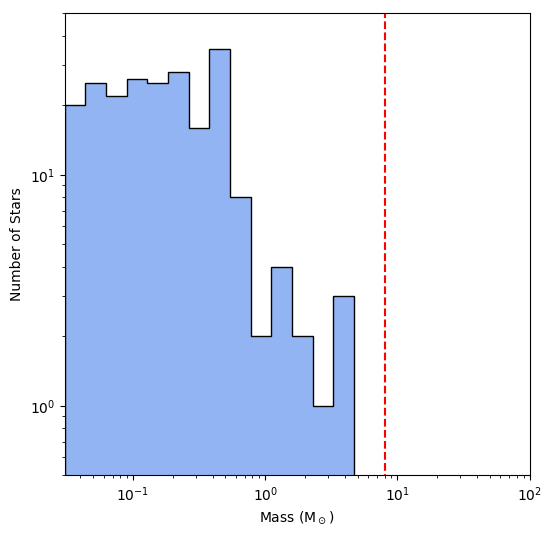

In [101]:
cluster = imf.make_cluster(70)
print cluster.max()
plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6))
###
ax.set_ylabel('Number of Stars')
ax.set_xlabel('Mass (M$_\odot$)')

mmin, mmax = min(cluster), max(cluster)
cluster_logbins = np.logspace(np.log10(mmin), np.log10(mmax),15)
h1,l1,p1 = ax.hist(cluster,
                   cluster_logbins, color='cornflowerblue',alpha=0.7, log=True)
h1,l1,p1 = ax.hist(cluster,
                   cluster_logbins, color='k',alpha=1.0,histtype='step', log=True)
ax.plot([8,8],[0,100],color='red',ls='--')
ax.set_xscale("log")
ax.set_ylim(0.5,50)
ax.set_xlim(0,100)
plt.show()

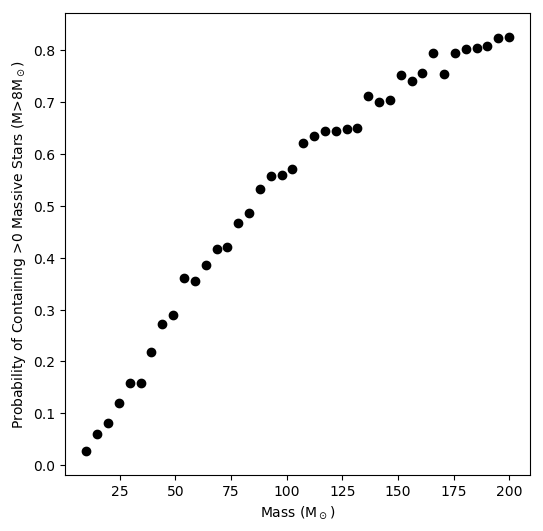

In [96]:
plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(6,6))
ax.scatter(lim_vals,num_massive_avg,marker='o',color='k')
ax.set_xlabel('Mass (M$_\odot$)')
ax.set_ylabel('Probability of Containing >0 Massive Stars (M>8M$_\odot$)')
plt.show()

In [97]:
print lim_vals
print num_massive_avg

[  10.           14.87179487   19.74358974   24.61538462   29.48717949
   34.35897436   39.23076923   44.1025641    48.97435897   53.84615385
   58.71794872   63.58974359   68.46153846   73.33333333   78.20512821
   83.07692308   87.94871795   92.82051282   97.69230769  102.56410256
  107.43589744  112.30769231  117.17948718  122.05128205  126.92307692
  131.79487179  136.66666667  141.53846154  146.41025641  151.28205128
  156.15384615  161.02564103  165.8974359   170.76923077  175.64102564
  180.51282051  185.38461538  190.25641026  195.12820513  200.        ]
[ 0.028  0.06   0.082  0.12   0.159  0.159  0.219  0.273  0.289  0.361
  0.355  0.386  0.416  0.42   0.467  0.486  0.532  0.557  0.56   0.571
  0.621  0.635  0.645  0.645  0.649  0.651  0.712  0.7    0.705  0.752
  0.74   0.756  0.794  0.755  0.795  0.802  0.804  0.808  0.824  0.825]
